<a href="https://colab.research.google.com/github/BarbaraMcG/darwin-semantic-change/blob/main/Semantic_change_Darwin_BMcG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic change in Darwin letters



Barbara McGillivray

This notebook contains the code for pre-processing the corpus of Darwin letters and train the embeddings. As some of the steps can take a long time to run, it is advisable to only run the first part of this notebook at the beginning of the project.

## Note on data

We will use the letters from the Darwin Correspondence Project (https://www.darwinproject.ac.uk/) which can be freely downloaded from https://github.com/cambridge-collection/darwin-correspondence-data ("xml" folder).

# Corpus processing of Darwin letters

## 1. Initialisation

I install version 4.0 of gensim, which is needed to train the word2vec models.

In [1]:
!pip install gensim==4.0


[notice] A new release of pip available: 22.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


I install the language detection module:

In [2]:
!pip install langdetect


[notice] A new release of pip available: 22.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


Download Spacy's English language model:

In [3]:
!python -m spacy download en

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 4.2 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


Import libraries

In [4]:
import os 
from bs4 import BeautifulSoup
#from google.colab import drive
import csv
import numpy as np
import pandas as pd
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import gensim
from scipy import spatial
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
import spacy
import re
from statistics import mean
from langdetect import detect
# to make our plot outputs appear and be stored within the notebook:
%matplotlib inline 

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/barbaramcgillivray/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/barbaramcgillivray/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Users/barbaramcgillivray/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## 2. Reading the files

I define the name of the folder containing the unzipped files:

In [5]:
folder = "/Users/barbaramcgillivray/OneDrive - King's College London/Research/2024/Darwin/data/darwin-correspondence-data-main/xml/letters/"

I define the list of all files:

In [6]:
files = os.listdir(folder)
len(files)

15628

We only want xml files:

In [7]:
files = [f for f in files[:] if f.endswith(".xml")]

In [8]:
len(files)

15619

### Extracting the text of the letters

I create the output folder:

In [9]:
out_folder = "/Users/barbaramcgillivray/OneDrive - King's College London/Research/2024/Darwin/data/preprocessed_text/" 

Testing on one letter:

In [10]:

# I initialise the variable "count" to count the files that I'm reading one by one
count = 0

# I loop over each file in the "files" list
for fname in files:
  
  # The variable "count" is incremented
  count += 1
  #print("Reading file number", str(count), fname)

  # the following two lines can be commented out if we want all files
  #if count > 200:
  #      break
    
  # I open each file
  with open(os.path.join(folder, fname), "r") as infile:

    # I read the content of the file in the variable "content"
    content = infile.read()

    # Initialize the fields required (sender, receiver, date_sent, keywords, abstract, letter_text):
    sender = ""
    receiver = ""
    date_sent = "" # the date in which the letter was sent
    year = ""
    letter_text = "" # transcription of the letter  

    # I parse the XML of the file with BeautifulSoup
    soup = BeautifulSoup(content,'xml')

    # extract sender, receiver and date_sent:

    corr_action = soup.find_all("correspAction")
    if corr_action and "9627F" in fname:
      print("Reading file number", str(count), fname)  
      # loop over all notes under "correspAction":
      for s in corr_action:
          
        #extract receiver's name:
        if s.get('type') == "received":
          try:
            receiver = s.persName.get_text()
            #print("receiver:", receiver)
          except:
            print("No receiver")

        # extract senders' name:
        if s.get('type') == "sent":
          try:
            sender = s.persName.get_text()  
            #print("sender:", sender)
          except:
            print("No sender")
            
          # extract date sent:                  
          try:
            date_sent = s.date["when"]
            # the year is the first four characters of the date:
            year = date_sent[:4]
          except:
            print("No exact date")
            #For ranges where we knew a letter was before a certain date or after a certain date but not more than that, we tended to use as one end of the range the date we knew related to the letter (in this case 1868), and at the other end we put either Darwin’s birth or death. 
            # So we ignore a notBefore=”1809-01-01” and a notAfter=”1882-12-31”
            try:
              date_sent_not_before = s.date["notBefore"]
              # the year is the first four characters of the date:
              year_not_before = date_sent_not_before[:4]
              #print("year_not_before:", year_not_before)
            except:
              print("\tNo notBefore date")
            try:
              date_sent_not_after = s.date["notAfter"]
              year_not_after = date_sent_not_after[:4]
              #print("year_not_after:", year_not_after)
            except:
              print("\tNo notAfter date")
            if date_sent_not_before and date_sent_not_after:
                if date_sent_not_before == "1809-01-01" and date_sent_not_after == "1882-12-31":
                    # a file that has the notBefore as D’s birth and the notAfter as D’s death: in this case we might want to exclude the letter completely – if we left the date range as his whole lifetime we really didn’t know when it was written, which makes it a bit useless in any case for tracing semantic change over time.
                    year = ""
                elif date_sent_not_before == "1809-01-01":
                    year = year_not_after
                elif date_sent_not_after == "1882-12-31":
                    year = year_not_before
                else:
                    year = round(float((int(year_not_before)+int(year_not_after))/2))
              
                #print("3", year)
            elif date_sent_not_before:
              year = year_not_before
              #print("2", year)
            elif date_sent_not_after:
              year = year_not_after
              #print("1", year)

                    
     
      # extract the transcription of the letters:
      text = soup.find_all("div")
      # I loop over all children of nodes in "div":
      for s in text:
        # I save the text of the transcription in the variable "letter_text"
        if s.get('type') == "transcription":
          letter_text = s.get_text()  
          # Remove newlines and tabs:
          letter_text = letter_text.replace("\n", " ").replace("\r", " ").replace("\t", " ").replace("  ", " ")
          # Remove leading and trailing spaces:
          letter_text = letter_text.strip()
          # test print statement:
          #print("letter_text:", letter_text)
          
      if letter_text == "":
        # If the transcription is empty, I save the variable "letter_text" with the value "TRANSCRIPTION MISSING"
        letter_text = "TRANSCRIPTION MISSING"
        # test print statement:
        #print("Tag_text:", letter_text)

      # I only select those letters for which we have a year and that were sent by or received by Charles Darwin:
        
      if year != "" and (sender == "Darwin, C. R." or receiver == "Darwin, C. R.") and letter_text != "TRANSCRIPTION MISSING":
        # write to output file
        print([fname, year, sender, receiver, letter_text])
      else:
        print("not sent or received by C. Darwin")                 
        print("sender:", sender)
        print("receiver:", receiver)
        print("letter_text:", letter_text) 
    
    #else:
    #    print("missing corr_action for ", fname) 

Reading file number 2776 DCP-LETT-9627F.xml
['DCP-LETT-9627F.xml', '1874', 'Darwin, C. R.', 'Marshall, W. C.', 'I am very grateful to you. Your observations are excellent, are put most clearly will be very useful to me. I have picked off 16 seeds from this lot! The plant is certainly to a certain extent graninivorous also somewhat graminivorous, though mainly insectivorous. The rain, I know washes off the secretion with it captured insects ( as you say seeds), which are retained by the incurved edges, which then become more incurved. It is a pretty experiment to put a row of flies or cabbage seeds on one margin of a flat leaf see how the edge of the side curls over in from 12 to 24 hours. With cordial thanks | Yours very sincerely | Ch. Darwin—']


We extract the trascribed text from each letter and save it in an output file.  **You can skip this cell** and go straight to section 4.

In [11]:
outfile = open(os.path.join(out_folder, 'transcription.csv'), 'w+')
output_writer = csv.writer(outfile, delimiter = "\t")

# Write header row:
output_writer.writerow(["File", "Year", "Sender", "Receiver", "Transcription"]) 

# I initialise the variable "count" to count the files that I'm reading one by one
count = 0

# I loop over each file in the "files" list
for fname in files:
  
  # The variable "count" is incremented
  count += 1
  #print("Reading file number", str(count), fname)

  # the following two lines can be commented out if we want all files
  #if count > 200:
  #      break
    
  # I open each file
  with open(os.path.join(folder, fname), "r") as infile:

    # I read the content of the file in the variable "content"
    content = infile.read()

    # Initialize the fields required (sender, receiver, date_sent, keywords, abstract, letter_text):
    sender = ""
    receiver = ""
    date_sent = "" # the date in which the letter was sent
    year = ""
    letter_text = "" # transcription of the letter  

    # I parse the XML of the file with BeautifulSoup
    soup = BeautifulSoup(content,'xml')

    # extract sender, receiver and date_sent:

    corr_action = soup.find_all("correspAction")
    if corr_action: # and "13835" in fname:
      print("Reading file number", str(count), fname)  
      # loop over all notes under "correspAction":
      for s in corr_action:
          
        #extract receiver's name:
        if s.get('type') == "received":
          try:
            receiver = s.persName.get_text()
            #print("receiver:", receiver)
          except:
            print("No receiver")

        # extract senders' name:
        if s.get('type') == "sent":
          try:
            sender = s.persName.get_text()  
            #print("sender:", sender)
          except:
            print("No sender")
            
          # extract date sent:                  
          try:
            date_sent = s.date["when"]
            # the year is the first four characters of the date:
            year = date_sent[:4]
            #print("0:", year)
          except:
            print("No exact date")
            #For ranges where we knew a letter was before a certain date or after a certain date but not more than that, we tended to use as one end of the range the date we knew related to the letter (in this case 1868), and at the other end we put either Darwin’s birth or death. 
            # So we ignore a notBefore=”1809-01-01” and a notAfter=”1882-12-31”
            try:
              date_sent_not_before = s.date["notBefore"]
              # the year is the first four characters of the date:
              year_not_before = date_sent_not_before[:4]
              print("year_not_before:", year_not_before)
            except:
              print("\tNo notBefore date")
            try:
              date_sent_not_after = s.date["notAfter"]
              year_not_after = date_sent_not_after[:4]
              print("year_not_after:", year_not_after)
            except:
              print("\tNo notAfter date")
            if date_sent_not_before and date_sent_not_after:
                if date_sent_not_before == "1809-01-01" and date_sent_not_after == "1882-12-31":
                    # a file that has the notBefore as D’s birth and the notAfter as D’s death: in this case we might want to exclude the letter completely – if we left the date range as his whole lifetime we really didn’t know when it was written, which makes it a bit useless in any case for tracing semantic change over time.
                    year = ""
                elif date_sent_not_before == "1809-01-01":
                    year = year_not_after
                elif date_sent_not_after == "1882-12-31":
                    year = year_not_before
                else:
                    year = round(float((int(year_not_before)+int(year_not_after))/2))
              
                print("3", year)
            elif date_sent_not_before:
              year = year_not_before
              #print("2", year)
            elif date_sent_not_after:
              year = year_not_after
              #print("1", year)

    
      # extract the transcription of the letters:
      text = soup.find_all("div")
      # I loop over all children of nodes in "div":
      for s in text:
        # I save the text of the transcription in the variable "letter_text"
        if s.get('type') == "transcription":
          letter_text = s.get_text()  
          # Remove newlines and tabs:
          letter_text = letter_text.replace("\n", " ").replace("\r", " ").replace("\t", " ").replace("  ", " ")
          # Remove leading and trailing spaces:
          letter_text = letter_text.strip()
          # test print statement:
          #print("letter_text:", letter_text)
          
      if letter_text == "":
        # If the transcription is empty, I save the variable "letter_text" with the value "TRANSCRIPTION MISSING"
        letter_text = "TRANSCRIPTION MISSING"
        # test print statement:
        #print("Tag_text:", letter_text)

      # I only select those letters for which we have a year and that were sent by or received by Charles Darwin:
      if year != "" and (sender == "Darwin, C. R." or receiver == "Darwin, C. R.") and letter_text != "TRANSCRIPTION MISSING":
        # write to output file
        output_writer.writerow([fname, year, sender, receiver, letter_text])
        #print(year)
      else:
        print("missing corr_action")                 
     
outfile.close()

Reading file number 1 DCP-LETT-12349.xml
Reading file number 2 DCP-LETT-13057.xml
Reading file number 3 DCP-LETT-11898.xml
Reading file number 4 DCP-LETT-7806.xml
Reading file number 5 DCP-LETT-11640.xml
Reading file number 6 DCP-LETT-686.xml
Reading file number 7 DCP-LETT-11126.xml
Reading file number 8 DCP-LETT-10238.xml
Reading file number 9 DCP-LETT-9195.xml
No exact date
year_not_before: 1874
year_not_after: 1874
3 1874
Reading file number 10 DCP-LETT-8650F.xml
Reading file number 11 DCP-LETT-13731.xml
Reading file number 12 DCP-LETT-9942F.xml
Reading file number 13 DCP-LETT-13770H.xml
No exact date
year_not_before: 1840
year_not_after: 1877
3 1858
Reading file number 14 DCP-LETT-5977.xml
Reading file number 15 DCP-LETT-13725.xml
Reading file number 16 DCP-LETT-5963.xml
Reading file number 17 DCP-LETT-11132.xml
Reading file number 18 DCP-LETT-692.xml
Reading file number 19 DCP-LETT-9181.xml
Reading file number 20 DCP-LETT-7812.xml
Reading file number 21 DCP-LETT-11654.xml
Reading 

Reading file number 207 DCP-LETT-12822.xml
Reading file number 208 DCP-LETT-4664.xml
Reading file number 209 DCP-LETT-453.xml
Reading file number 210 DCP-LETT-9340.xml
Reading file number 211 DCP-LETT-6073.xml
Reading file number 212 DCP-LETT-3362F.xml
Reading file number 213 DCP-LETT-4894.xml
Reading file number 214 DCP-LETT-5552.xml
Reading file number 215 DCP-LETT-3123.xml
Reading file number 216 DCP-LETT-7345.xml
Reading file number 217 DCP-LETT-8076.xml
Reading file number 218 DCP-LETT-9368.xml
Reading file number 219 DCP-LETT-1734.xml
Reading file number 220 DCP-LETT-1052.xml
Reading file number 222 DCP-LETT-8710.xml
No exact date
year_not_before: 1873
year_not_after: 1873
3 1873
Reading file number 223 DCP-LETT-3645.xml
Reading file number 224 DCP-LETT-5234.xml
Reading file number 225 DCP-LETT-3651.xml
Reading file number 227 DCP-LETT-5220.xml
Reading file number 228 DCP-LETT-1046.xml
No exact date
year_not_before: 1847
year_not_after: 1847
3 1847
missing corr_action
Reading fil

Reading file number 413 DCP-LETT-9977.xml
Reading file number 414 DCP-LETT-10402.xml
Reading file number 415 DCP-LETT-1318.xml
Reading file number 416 DCP-LETT-6477.xml
Reading file number 417 DCP-LETT-9744.xml
Reading file number 418 DCP-LETT-7769.xml
Reading file number 419 DCP-LETT-4260.xml
Reading file number 420 DCP-LETT-2611.xml
Reading file number 421 DCP-LETT-13686.xml
Reading file number 422 DCP-LETT-2177.xml
Reading file number 423 DCP-LETT-36.xml
Reading file number 424 DCP-LETT-5618.xml
Reading file number 425 DCP-LETT-5583A.xml
Reading file number 426 DCP-LETT-4506.xml
Reading file number 427 DCP-LETT-3269.xml
Reading file number 428 DCP-LETT-12598.xml
Reading file number 429 DCP-LETT-11091.xml
Reading file number 430 DCP-LETT-731.xml
Reading file number 431 DCP-LETT-6311.xml
No exact date
year_not_before: 1809
year_not_after: 1868
3 1868
Reading file number 432 DCP-LETT-9022.xml
Reading file number 433 DCP-LETT-725.xml
Reading file number 434 DCP-LETT-11085.xml
No exact d

Reading file number 612 DCP-LETT-5433.xml
Reading file number 613 DCP-LETT-3042.xml
No exact date
year_not_before: 1809
year_not_after: 1861
3 1861
Reading file number 614 DCP-LETT-8117.xml
Reading file number 615 DCP-LETT-7224.xml
Reading file number 616 DCP-LETT-9209.xml
Reading file number 617 DCP-LETT-1655.xml
Reading file number 618 DCP-LETT-8103.xml
No exact date
year_not_before: 1871
year_not_after: 1882
3 1871
Reading file number 619 DCP-LETT-1899.xml
No exact date
year_not_before: 1856
year_not_after: 1856
3 1856
Reading file number 620 DCP-LETT-7230.xml
Reading file number 621 DCP-LETT-1641.xml
Reading file number 622 DCP-LETT-2348.xml
No exact date
	No notBefore date
	No notAfter date
3 1856
missing corr_action
Reading file number 623 DCP-LETT-5427.xml
Reading file number 624 DCP-LETT-4739.xml
missing corr_action
Reading file number 625 DCP-LETT-2513A.xml
Reading file number 626 DCP-LETT-3056.xml
Reading file number 627 DCP-LETT-3730.xml
Reading file number 628 DCP-LETT-5341

Reading file number 820 DCP-LETT-11457.xml
Reading file number 821 DCP-LETT-10991.xml
Reading file number 822 DCP-LETT-8040F.xml
Reading file number 823 DCP-LETT-13240.xml
Reading file number 824 DCP-LETT-3877.xml
Reading file number 825 DCP-LETT-13526.xml
Reading file number 826 DCP-LETT-12638.xml
Reading file number 827 DCP-LETT-1906.xml
Reading file number 828 DCP-LETT-11331.xml
Reading file number 829 DCP-LETT-491.xml
Reading file number 830 DCP-LETT-9382.xml
No exact date
year_not_before: 1874
year_not_after: 1874
3 1874
missing corr_action
Reading file number 831 DCP-LETT-8088.xml
Reading file number 832 DCP-LETT-1912.xml
Reading file number 833 DCP-LETT-485.xml
Reading file number 834 DCP-LETT-11325.xml
Reading file number 835 DCP-LETT-9396.xml
Reading file number 836 DCP-LETT-559F.xml
No exact date
year_not_before: 1840
year_not_after: 1840
3 1840
Reading file number 837 DCP-LETT-13532.xml
Reading file number 838 DCP-LETT-13254.xml
Reading file number 839 DCP-LETT-3863.xml
Read

Reading file number 1024 DCP-LETT-9141.xml
Reading file number 1025 DCP-LETT-6272.xml
Reading file number 1026 DCP-LETT-715F.xml
Reading file number 1027 DCP-LETT-652.xml
Reading file number 1028 DCP-LETT-4465.xml
Reading file number 1029 DCP-LETT-2014.xml
Reading file number 1030 DCP-LETT-4471.xml
Reading file number 1031 DCP-LETT-2000.xml
Reading file number 1032 DCP-LETT-1509.xml
Reading file number 1033 DCP-LETT-9155.xml
Reading file number 1034 DCP-LETT-6266.xml
Reading file number 1035 DCP-LETT-7178.xml
Reading file number 1036 DCP-LETT-646.xml
Reading file number 1037 DCP-LETT-11680.xml
Reading file number 1038 DCP-LETT-120.xml
Reading file number 1039 DCP-LETT-9633.xml
Reading file number 1040 DCP-LETT-11858.xml
Reading file number 1041 DCP-LETT-6500.xml
Reading file number 1042 DCP-LETT-13097.xml
Reading file number 1043 DCP-LETT-2766.xml
Reading file number 1044 DCP-LETT-5009.xml
Reading file number 1045 DCP-LETT-4317.xml
Reading file number 1046 DCP-LETT-3478.xml
Reading fil

Reading file number 1225 DCP-LETT-11535.xml
Reading file number 1226 DCP-LETT-295.xml
No exact date
year_not_before: 1836
year_not_after: 1836
3 1836
Reading file number 1227 DCP-LETT-8698.xml
Reading file number 1228 DCP-LETT-13322.xml
Reading file number 1229 DCP-LETT-3915.xml
Reading file number 1230 DCP-LETT-12982.xml
Reading file number 1231 DCP-LETT-13444.xml
Reading file number 1232 DCP-LETT-1864.xml
Reading file number 1233 DCP-LETT-11253.xml
Reading file number 1234 DCP-LETT-10759F.xml
Reading file number 1235 DCP-LETT-4934.xml
Reading file number 1236 DCP-LETT-3083.xml
Reading file number 1237 DCP-LETT-12772.xml
Reading file number 1238 DCP-LETT-1694.xml
No exact date
year_not_before: 1855
year_not_after: 1855
3 1855
Reading file number 1239 DCP-LETT-10165.xml
Reading file number 1240 DCP-LETT-4147F.xml
Reading file number 1241 DCP-LETT-10603.xml
Reading file number 1242 DCP-LETT-8868.xml
Reading file number 1243 DCP-LETT-6845.xml
Reading file number 1244 DCP-LETT-7583.xml
Re

Reading file number 1396 DCP-LETT-9753.xml
Reading file number 1397 DCP-LETT-11938.xml
Reading file number 1398 DCP-LETT-6460.xml
Reading file number 1399 DCP-LETT-8581A.xml
Reading file number 1400 DCP-LETT-726.xml
Reading file number 1401 DCP-LETT-11086.xml
No exact date
year_not_before: 1877
year_not_after: 1877
3 1877
Reading file number 1402 DCP-LETT-7018.xml
Reading file number 1403 DCP-LETT-9035.xml
No exact date
year_not_before: 1873
year_not_after: 1873
3 1873
Reading file number 1404 DCP-LETT-6306.xml
Reading file number 1405 DCP-LETT-10398.xml
Reading file number 1406 DCP-LETT-1469.xml
Reading file number 1407 DCP-LETT-2160.xml
Reading file number 1408 DCP-LETT-13691.xml
Reading file number 1409 DCP-LETT-1K.xml
Reading file number 1410 DCP-LETT-21.xml
Reading file number 1411 DCP-LETT-10974F.xml
Reading file number 1412 DCP-LETT-4511.xml
Reading file number 1413 DCP-LETT-5582F.xml
Reading file number 1414 DCP-LETT-13849.xml
No exact date
year_not_before: 1871
year_not_after:

Reading file number 1596 DCP-LETT-3041.xml
Reading file number 1597 DCP-LETT-519.xml
Reading file number 1598 DCP-LETT-7227.xml
Reading file number 1599 DCP-LETT-8114.xml
Reading file number 1600 DCP-LETT-6139.xml
Reading file number 1601 DCP-LETT-1656.xml
Reading file number 1602 DCP-LETT-1130.xml
Reading file number 1603 DCP-LETT-2142F.xml
Reading file number 1604 DCP-LETT-7541.xml
Reading file number 1605 DCP-LETT-8672.xml
Reading file number 1606 DCP-LETT-10819.xml
Reading file number 1607 DCP-LETT-6887.xml
Reading file number 1608 DCP-LETT-4995F.xml
missing corr_action
Reading file number 1609 DCP-LETT-3727.xml
Reading file number 1610 DCP-LETT-4048.xml
Reading file number 1611 DCP-LETT-5356.xml
Reading file number 1612 DCP-LETT-2439.xml
Reading file number 1613 DCP-LETT-1118.xml
Reading file number 1614 DCP-LETT-8882.xml
Reading file number 1615 DCP-LETT-9544.xml
Reading file number 1616 DCP-LETT-6677.xml
Reading file number 1617 DCP-LETT-10831.xml
Reading file number 1618 DCP-LE

Reading file number 1807 DCP-LETT-12607.xml
Reading file number 1808 DCP-LETT-4699.xml
Reading file number 1809 DCP-LETT-12161.xml
Reading file number 1810 DCP-LETT-3690.xml
Reading file number 1811 DCP-LETT-3848.xml
Reading file number 1812 DCP-LETT-10776.xml
Reading file number 1813 DCP-LETT-1087.xml
Reading file number 1814 DCP-LETT-6930.xml
Reading file number 1815 DCP-LETT-11468.xml
Reading file number 1816 DCP-LETT-12149.xml
Reading file number 1817 DCP-LETT-5389A.xml
Reading file number 1818 DCP-LETT-13257.xml
Reading file number 1819 DCP-LETT-3860.xml
Reading file number 1820 DCP-LETT-8935.xml
Reading file number 1821 DCP-LETT-11440.xml
Reading file number 1822 DCP-LETT-6918.xml
Reading file number 1823 DCP-LETT-10986.xml
Reading file number 1824 DCP-LETT-1911.xml
Reading file number 1825 DCP-LETT-486.xml
Reading file number 1826 DCP-LETT-11326.xml
Reading file number 1827 DCP-LETT-10038.xml
Reading file number 1828 DCP-LETT-9395.xml
Reading file number 1830 DCP-LETT-13531.xml


Reading file number 2025 DCP-LETT-8266.xml
Reading file number 2026 DCP-LETT-7633.xml
Reading file number 2027 DCP-LETT-8500.xml
Reading file number 2028 DCP-LETT-1242.xml
No exact date
year_not_before: 1849
year_not_after: 1849
3 1849
Reading file number 2029 DCP-LETT-11875.xml
Reading file number 2030 DCP-LETT-5024.xml
Reading file number 2031 DCP-LETT-3455.xml
Reading file number 2032 DCP-LETT-2993.xml
Reading file number 2033 DCP-LETT-5030.xml
Reading file number 2034 DCP-LETT-3441.xml
Reading file number 2035 DCP-LETT-5297F.xml
Reading file number 2036 DCP-LETT-2987.xml
Reading file number 2037 DCP-LETT-7627.xml
Reading file number 2038 DCP-LETT-8514.xml
Reading file number 2039 DCP-LETT-119.xml
Reading file number 2040 DCP-LETT-1256.xml
Reading file number 2041 DCP-LETT-11312A.xml
No exact date
year_not_before: 1877
year_not_after: 1877
3 1877
missing corr_action
Reading file number 2042 DCP-LETT-6539.xml
No exact date
year_not_before: 1869
year_not_after: 1882
3 1869
Reading fil

Reading file number 2238 DCP-LETT-8851.xml
Reading file number 2239 DCP-LETT-9597.xml
Reading file number 2240 DCP-LETT-8689.xml
Reading file number 2241 DCP-LETT-2908A.xml
Reading file number 2242 DCP-LETT-284.xml
Reading file number 2243 DCP-LETT-11524.xml
Reading file number 2244 DCP-LETT-9426F.xml
Reading file number 2245 DCP-LETT-11242.xml
Reading file number 2246 DCP-LETT-1875.xml
Reading file number 2247 DCP-LETT-13455.xml
Reading file number 2248 DCP-LETT-9647A.xml
Reading file number 2249 DCP-LETT-12993.xml
Reading file number 2250 DCP-LETT-13441.xml
Reading file number 2251 DCP-LETT-4919.xml
Reading file number 2252 DCP-LETT-12987.xml
Reading file number 2253 DCP-LETT-8667F.xml
Reading file number 2254 DCP-LETT-11256.xml
Reading file number 2255 DCP-LETT-1861.xml
No exact date
year_not_before: 1856
year_not_after: 1856
3 1856
Reading file number 2256 DCP-LETT-10148.xml
Reading file number 2257 DCP-LETT-8845.xml
Reading file number 2258 DCP-LETT-9583.xml
Reading file number 22

Reading file number 2411 DCP-LETT-8460.xml
Reading file number 2412 DCP-LETT-7035.xml
Reading file number 2413 DCP-LETT-8306.xml
Reading file number 2414 DCP-LETT-1444.xml
Reading file number 2415 DCP-LETT-9018.xml
Reading file number 2416 DCP-LETT-5622.xml
Reading file number 2417 DCP-LETT-3253.xml
No exact date
year_not_before: 1809
year_not_after: 1861
3 1861
Reading file number 2418 DCP-LETT-13864.xml
No exact date
year_not_before: 1838
year_not_after: 1841
3 1840
Reading file number 2419 DCP-LETT-3640F.xml
Reading file number 2420 DCP-LETT-4185F.xml
Reading file number 2421 DCP-LETT-723.xml
No exact date
year_not_before: 1843
year_not_after: 1844
3 1844
Reading file number 2422 DCP-LETT-11083.xml
Reading file number 2423 DCP-LETT-9030.xml
Reading file number 2424 DCP-LETT-6303.xml
Reading file number 2425 DCP-LETT-24.xml
Reading file number 2426 DCP-LETT-2165.xml
Reading file number 2427 DCP-LETT-13694.xml
Reading file number 2428 DCP-LETT-4514.xml
Reading file number 2429 DCP-LET

Reading file number 2603 DCP-LETT-11260F.xml
Reading file number 2604 DCP-LETT-520.xml
Reading file number 2605 DCP-LETT-11280.xml
Reading file number 2606 DCP-LETT-9233.xml
Reading file number 2607 DCP-LETT-6100.xml
Reading file number 2608 DCP-LETT-5409.xml
Reading file number 2609 DCP-LETT-12951.xml
No exact date
year_not_before: 1809
year_not_after: 1880
3 1880
Reading file number 2610 DCP-LETT-2366.xml
Reading file number 2611 DCP-LETT-13497.xml
Reading file number 2612 DCP-LETT-12789.xml
No exact date
year_not_before: 1881
year_not_after: 1881
3 1881
Reading file number 2613 DCP-LETT-3078.xml
Reading file number 2614 DCP-LETT-4717.xml
Reading file number 2615 DCP-LETT-7236.xml
Reading file number 2616 DCP-LETT-8105.xml
Reading file number 2617 DCP-LETT-508.xml
No exact date
year_not_before: 1839
year_not_after: 1839
3 1839
Reading file number 2618 DCP-LETT-1647.xml
Reading file number 2619 DCP-LETT-6128.xml
Reading file number 2620 DCP-LETT-12979.xml
Reading file number 2621 DCP-

Reading file number 2793 DCP-LETT-11337.xml
Reading file number 2794 DCP-LETT-497.xml
Reading file number 2795 DCP-LETT-1900.xml
Reading file number 2796 DCP-LETT-9384.xml
Reading file number 2797 DCP-LETT-10029.xml
Reading file number 2798 DCP-LETT-13508.xml
Reading file number 2799 DCP-LETT-4850.xml
Reading file number 2800 DCP-LETT-5596.xml
Reading file number 2801 DCP-LETT-4688.xml
No exact date
year_not_before: 1809
year_not_after: 1864
3 1864
Reading file number 2802 DCP-LETT-12616.xml
Reading file number 2803 DCP-LETT-7381.xml
Reading file number 2804 DCP-LETT-1928.xml
Reading file number 2805 DCP-LETT-10001.xml
Reading file number 2806 DCP-LETT-1096.xml
Reading file number 2807 DCP-LETT-10767.xml
Reading file number 2808 DCP-LETT-6921.xml
Reading file number 2809 DCP-LETT-11479.xml
Reading file number 2810 DCP-LETT-3681.xml
No exact date
year_not_before: 1809
year_not_after: 1862
3 1862
Reading file number 2811 DCP-LETT-12170.xml
Reading file number 2812 DCP-LETT-3859.xml
Readi

Reading file number 3018 DCP-LETT-7624.xml
Reading file number 3019 DCP-LETT-1255.xml
Reading file number 3020 DCP-LETT-9609.xml
Reading file number 3021 DCP-LETT-11862.xml
Reading file number 3022 DCP-LETT-8503.xml
No exact date
year_not_before: 1872
year_not_after: 1872
3 1872
Reading file number 3023 DCP-LETT-7630.xml
Reading file number 3024 DCP-LETT-2732F.xml
Reading file number 3025 DCP-LETT-1241.xml
Reading file number 3026 DCP-LETT-11876.xml
Reading file number 3027 DCP-LETT-5027.xml
Reading file number 3028 DCP-LETT-2748.xml
Reading file number 3029 DCP-LETT-3456.xml
Reading file number 3030 DCP-LETT-4339.xml
missing corr_action
Reading file number 3031 DCP-LETT-2990.xml
Reading file number 3032 DCP-LETT-5999.xml
Reading file number 3033 DCP-LETT-3330.xml
Reading file number 3034 DCP-LETT-11743F.xml
Reading file number 3035 DCP-LETT-5741.xml
Reading file number 3036 DCP-LETT-6248.xml
Reading file number 3037 DCP-LETT-1527.xml
Reading file number 3038 DCP-LETT-11522A.xml
Readin

Reading file number 3225 DCP-LETT-7585.xml
Reading file number 3226 DCP-LETT-6843.xml
Reading file number 3227 DCP-LETT-12012.xml
missing corr_action
Reading file number 3228 DCP-LETT-5392.xml
Reading file number 3229 DCP-LETT-8846.xml
missing corr_action
Reading file number 3230 DCP-LETT-9580.xml
Reading file number 3231 DCP-LETT-12440G.xml
Reading file number 3232 DCP-LETT-11533.xml
Reading file number 3233 DCP-LETT-293.xml
Reading file number 3234 DCP-LETT-9077A.xml
Reading file number 3235 DCP-LETT-3913.xml
Reading file number 3236 DCP-LETT-13324.xml
Reading file number 3237 DCP-LETT-13442.xml
Reading file number 3238 DCP-LETT-12984.xml
Reading file number 3239 DCP-LETT-11978F.xml
Reading file number 3240 DCP-LETT-11255.xml
Reading file number 3241 DCP-LETT-4074F.xml
Reading file number 3242 DCP-LETT-1862.xml
No exact date
year_not_before: 1856
year_not_after: 1856
3 1856
Reading file number 3243 DCP-LETT-11241.xml
Reading file number 3244 DCP-LETT-1876.xml
Reading file number 3245

Reading file number 3427 DCP-LETT-9999.xml
Reading file number 3428 DCP-LETT-4265.xml
Reading file number 3429 DCP-LETT-3211A.xml
No exact date
	No notBefore date
	No notAfter date
3 1872
missing corr_action
Reading file number 3430 DCP-LETT-2614.xml
Reading file number 3431 DCP-LETT-4271.xml
Reading file number 3432 DCP-LETT-2476G.xml
Reading file number 3433 DCP-LETT-2600.xml
Reading file number 3434 DCP-LETT-6466.xml
Reading file number 3435 DCP-LETT-9755.xml
Reading file number 3436 DCP-LETT-1309.xml
Reading file number 3437 DCP-LETT-7778.xml
Reading file number 3438 DCP-LETT-720.xml
Reading file number 3439 DCP-LETT-11080.xml
Reading file number 3440 DCP-LETT-6300.xml
No exact date
year_not_before: 1868
year_not_after: 1868
3 1868
No receiver
Reading file number 3441 DCP-LETT-9033.xml
Reading file number 3442 DCP-LETT-1M.xml
Reading file number 3443 DCP-LETT-27.xml
Reading file number 3444 DCP-LETT-5609.xml
Reading file number 3445 DCP-LETT-2166.xml
No exact date
year_not_before: 

Reading file number 3634 DCP-LETT-1644.xml
No exact date
year_not_before: 1809
year_not_after: 1855
3 1855
Reading file number 3635 DCP-LETT-9218.xml
Reading file number 3636 DCP-LETT-5422.xml
Reading file number 3637 DCP-LETT-9778F.xml
missing corr_action
Reading file number 3638 DCP-LETT-3053.xml
Reading file number 3639 DCP-LETT-12749.xml
Reading file number 3640 DCP-LETT-12991.xml
No exact date
year_not_before: 1881
year_not_after: 1882
3 1881
Reading file number 3641 DCP-LETT-13457.xml
Reading file number 3642 DCP-LETT-1877.xml
Reading file number 3643 DCP-LETT-11240.xml
Reading file number 3644 DCP-LETT-11526.xml
Reading file number 3645 DCP-LETT-286.xml
Reading file number 3646 DCP-LETT-9595.xml
Reading file number 3647 DCP-LETT-10638.xml
Reading file number 3648 DCP-LETT-8853.xml
No exact date
year_not_before: 1809
year_not_after: 1873
3 1873
Reading file number 3649 DCP-LETT-13331.xml
Reading file number 3650 DCP-LETT-3906.xml
Reading file number 3651 DCP-LETT-13325.xml
Readin

Reading file number 3811 DCP-LETT-9299A.xml
Reading file number 3812 DCP-LETT-7382.xml
Reading file number 3813 DCP-LETT-10002.xml
Reading file number 3814 DCP-LETT-9620.xml
Reading file number 3815 DCP-LETT-6513.xml
Reading file number 3816 DCP-LETT-11693.xml
Reading file number 3817 DCP-LETT-133.xml
Reading file number 3818 DCP-LETT-4304.xml
missing corr_action
Reading file number 3819 DCP-LETT-10061A.xml
Reading file number 3820 DCP-LETT-13084.xml
Reading file number 3822 DCP-LETT-2013.xml
Reading file number 3823 DCP-LETT-4462.xml
missing corr_action
Reading file number 3824 DCP-LETT-8258.xml
Reading file number 3825 DCP-LETT-655.xml
missing corr_action
Reading file number 3826 DCP-LETT-4609G.xml
Reading file number 3827 DCP-LETT-9146.xml
Reading file number 3828 DCP-LETT-6275.xml
Reading file number 3829 DCP-LETT-641.xml
Reading file number 3830 DCP-LETT-9152.xml
Reading file number 3831 DCP-LETT-899.xml
No exact date
year_not_before: 1845
year_not_after: 1845
3 1845
Reading file 

Reading file number 4005 DCP-LETT-6574.xml
Reading file number 4006 DCP-LETT-10067F.xml
No sender
Reading file number 4007 DCP-LETT-2712.xml
Reading file number 4008 DCP-LETT-4383F.xml
No exact date
	No notBefore date
	No notAfter date
3 1832
missing corr_action
Reading file number 4009 DCP-LETT-4363.xml
No exact date
year_not_before: 1809
year_not_after: 1864
3 1864
Reading file number 4010 DCP-LETT-4405.xml
Reading file number 4011 DCP-LETT-2074.xml
Reading file number 4012 DCP-LETT-6214F.xml
Reading file number 4013 DCP-LETT-13785.xml
Reading file number 4014 DCP-LETT-9121.xml
No exact date
year_not_before: 1873
year_not_after: 1873
3 1873
Reading file number 4015 DCP-LETT-6212.xml
Reading file number 4016 DCP-LETT-632.xml
Reading file number 4017 DCP-LETT-11192.xml
Reading file number 4018 DCP-LETT-3342.xml
Reading file number 4019 DCP-LETT-5733.xml
Reading file number 4020 DCP-LETT-1555.xml
No exact date
year_not_before: 1809
year_not_after: 1854
3 1854
Reading file number 4021 DC

Reading file number 4209 DCP-LETT-4940.xml
missing corr_action
Reading file number 4210 DCP-LETT-13418.xml
Reading file number 4211 DCP-LETT-12706.xml
Reading file number 4212 DCP-LETT-4798.xml
Reading file number 4213 DCP-LETT-1838.xml
Reading file number 4214 DCP-LETT-7291.xml
Reading file number 4215 DCP-LETT-13523F.xml
No exact date
year_not_before: 1881
year_not_after: 1881
3 1881
Reading file number 4216 DCP-LETT-10111.xml
Reading file number 4217 DCP-LETT-7285.xml
Reading file number 4218 DCP-LETT-10105.xml
Reading file number 4219 DCP-LETT-5492.xml
Reading file number 4220 DCP-LETT-4954.xml
Reading file number 4221 DCP-LETT-4320A.xml
missing corr_action
Reading file number 4222 DCP-LETT-12712.xml
Reading file number 4223 DCP-LETT-3785.xml
Reading file number 4224 DCP-LETT-12074.xml
Reading file number 4225 DCP-LETT-1192.xml
Reading file number 4226 DCP-LETT-10663.xml
Reading file number 4227 DCP-LETT-8808.xml
Reading file number 4228 DCP-LETT-6825.xml
Reading file number 4229 D

Reading file number 4381 DCP-LETT-41.xml
Reading file number 4382 DCP-LETT-4571.xml
Reading file number 4383 DCP-LETT-13829.xml
No exact date
year_not_before: 1859
year_not_after: 1882
3 1859
Reading file number 4384 DCP-LETT-746.xml
Reading file number 4385 DCP-LETT-7078.xml
No exact date
year_not_before: 1870
year_not_after: 1882
3 1870
Reading file number 4386 DCP-LETT-9055.xml
Reading file number 4387 DCP-LETT-2020A.xml
Reading file number 4388 DCP-LETT-6366.xml
Reading file number 4389 DCP-LETT-1409.xml
Reading file number 4390 DCP-LETT-2128.xml
Reading file number 4391 DCP-LETT-69.xml
Reading file number 4392 DCP-LETT-5647.xml
Reading file number 4393 DCP-LETT-13801.xml
No exact date
year_not_before: 1849
year_not_after: 1849
3 1849
Reading file number 4394 DCP-LETT-4559.xml
Reading file number 4395 DCP-LETT-3236.xml
Reading file number 4396 DCP-LETT-7050.xml
No exact date
year_not_before: 1870
year_not_after: 1882
3 1870
Reading file number 4397 DCP-LETT-8363.xml
Reading file nu

Reading file number 4591 DCP-LETT-4772.xml
Reading file number 4592 DCP-LETT-545.xml
Reading file number 4593 DCP-LETT-8148.xml
Reading file number 4594 DCP-LETT-9256.xml
Reading file number 4595 DCP-LETT-6165.xml
Reading file number 4596 DCP-LETT-9530.xml
Reading file number 4597 DCP-LETT-6603.xml
Reading file number 4598 DCP-LETT-10845.xml
Reading file number 4599 DCP-LETT-223.xml
Reading file number 4600 DCP-LETT-11583.xml
Reading file number 4601 DCP-LETT-4014.xml
Reading file number 4602 DCP-LETT-2465.xml
Reading file number 4603 DCP-LETT-13394.xml
Reading file number 4604 DCP-LETT-4000.xml
Reading file number 4605 DCP-LETT-13380.xml
Reading file number 4606 DCP-LETT-2471.xml
Reading file number 4607 DCP-LETT-1178.xml
Reading file number 4608 DCP-LETT-10689.xml
Reading file number 4609 DCP-LETT-9524.xml
No exact date
year_not_before: 1871
year_not_after: 1871
3 1871
Reading file number 4610 DCP-LETT-6617.xml
Reading file number 4611 DCP-LETT-10851.xml
Reading file number 4612 DCP-

Reading file number 4796 DCP-LETT-11420.xml
Reading file number 4797 DCP-LETT-6978.xml
Reading file number 4798 DCP-LETT-12129.xml
No exact date
year_not_before: 1879
year_not_after: 1882
3 1879
Reading file number 4799 DCP-LETT-13237.xml
Reading file number 4800 DCP-LETT-3800.xml
Reading file number 4801 DCP-LETT-12897.xml
Reading file number 4802 DCP-LETT-4809.xml
Reading file number 4803 DCP-LETT-13551.xml
Reading file number 4804 DCP-LETT-1971.xml
Reading file number 4805 DCP-LETT-11346.xml
Reading file number 4806 DCP-LETT-10058.xml
Reading file number 4807 DCP-LETT-1226.xml
Reading file number 4808 DCP-LETT-11811.xml
Reading file number 4809 DCP-LETT-6549.xml
Reading file number 4810 DCP-LETT-8564.xml
Reading file number 4811 DCP-LETT-7657.xml
Reading file number 4812 DCP-LETT-169.xml
No exact date
year_not_before: 1832
year_not_after: 1832
3 1832
Reading file number 4813 DCP-LETT-3431.xml
Reading file number 4814 DCP-LETT-5040.xml
Reading file number 4815 DCP-LETT-2049.xml
Readi

Reading file number 4975 DCP-LETT-2077.xml
Reading file number 4976 DCP-LETT-13786.xml
Reading file number 4977 DCP-LETT-2037F.xml
Reading file number 4978 DCP-LETT-6211.xml
Reading file number 4979 DCP-LETT-9122.xml
No exact date
year_not_before: 1873
year_not_after: 1873
3 1873
No receiver
Reading file number 4980 DCP-LETT-631.xml
No exact date
year_not_before: 1841
year_not_after: 1841
3 1841
Reading file number 4981 DCP-LETT-11191.xml
Reading file number 4982 DCP-LETT-157.xml
Reading file number 4983 DCP-LETT-7669.xml
Reading file number 4984 DCP-LETT-6577.xml
Reading file number 4985 DCP-LETT-6977F.xml
Reading file number 4986 DCP-LETT-9644.xml
Reading file number 4987 DCP-LETT-1218.xml
No exact date
year_not_before: 1849
year_not_after: 1849
3 1849
Reading file number 4988 DCP-LETT-2711.xml
Reading file number 4989 DCP-LETT-4360.xml
missing corr_action
Reading file number 4990 DCP-LETT-2705.xml
Reading file number 4991 DCP-LETT-4374.xml
missing corr_action
Reading file number 499

Reading file number 5153 DCP-LETT-5254.xml
Reading file number 5154 DCP-LETT-1032.xml
Reading file number 5155 DCP-LETT-7443.xml
Reading file number 5156 DCP-LETT-8770.xml
Reading file number 5157 DCP-LETT-6985.xml
Reading file number 5158 DCP-LETT-8837.xml
Reading file number 5159 DCP-LETT-1066F.xml
No exact date
year_not_before: 1847
year_not_after: 1847
3 1847
Reading file number 5160 DCP-LETT-11542.xml
Reading file number 5161 DCP-LETT-10884.xml
Reading file number 5162 DCP-LETT-13355.xml
Reading file number 5163 DCP-LETT-3962.xml
Reading file number 5164 DCP-LETT-13433.xml
No exact date
year_not_before: 1881
year_not_after: 1882
3 1881
Reading file number 5165 DCP-LETT-12017F.xml
Reading file number 5166 DCP-LETT-8189.xml
Reading file number 5167 DCP-LETT-1813.xml
Reading file number 5168 DCP-LETT-584.xml
Reading file number 5169 DCP-LETT-11224.xml
Reading file number 5171 DCP-LETT-1807.xml
No exact date
year_not_before: 1856
year_not_after: 1856
3 1856
Reading file number 5172 DC

Reading file number 5321 DCP-LETT-9903.xml
Reading file number 5322 DCP-LETT-1387.xml
Reading file number 5323 DCP-LETT-10476.xml
Reading file number 5324 DCP-LETT-8564A.xml
Reading file number 5325 DCP-LETT-976.xml
Reading file number 5326 DCP-LETT-10310.xml
Reading file number 5327 DCP-LETT-7090.xml
Reading file number 5328 DCP-LETT-4599.xml
Reading file number 5329 DCP-LETT-12507.xml
Reading file number 5330 DCP-LETT-13619.xml
Reading file number 5331 DCP-LETT-5687.xml
Reading file number 5332 DCP-LETT-2103.xml
Reading file number 5333 DCP-LETT-42.xml
Reading file number 5334 DCP-LETT-565F.xml
Reading file number 5335 DCP-LETT-4572.xml
Reading file number 5336 DCP-LETT-745.xml
Reading file number 5337 DCP-LETT-8348.xml
Reading file number 5338 DCP-LETT-6365.xml
Reading file number 5339 DCP-LETT-9056.xml
Reading file number 5340 DCP-LETT-3001A.xml
Reading file number 5341 DCP-LETT-6403.xml
No exact date
year_not_before: 1867
year_not_after: 1882
3 1867
Reading file number 5342 DCP-LE

Reading file number 5524 DCP-LETT-2328.xml
Reading file number 5525 DCP-LETT-8118A.xml
Reading file number 5526 DCP-LETT-5447.xml
Reading file number 5527 DCP-LETT-4759.xml
Reading file number 5528 DCP-LETT-3036.xml
No exact date
year_not_before: 1860
year_not_after: 1860
3 1860
Reading file number 5529 DCP-LETT-8379F.xml
Reading file number 5530 DCP-LETT-8163.xml
Reading file number 5531 DCP-LETT-7250.xml
Reading file number 5532 DCP-LETT-1621.xml
No exact date
year_not_before: 1848
year_not_after: 1848
3 1848
Reading file number 5533 DCP-LETT-1147.xml
Reading file number 5534 DCP-LETT-12595J.xml
No receiver
Reading file number 5536 DCP-LETT-6628.xml
Reading file number 5537 DCP-LETT-8605.xml
Reading file number 5538 DCP-LETT-7536.xml
Reading file number 5539 DCP-LETT-208.xml
Reading file number 5540 DCP-LETT-7761G.xml
No exact date
year_not_before: 1871
year_not_after: 1882
3 1871
Reading file number 5541 DCP-LETT-3750.xml
Reading file number 5542 DCP-LETT-5321.xml
Reading file numbe

Reading file number 5740 DCP-LETT-7495.xml
Reading file number 5741 DCP-LETT-10179G.xml
Reading file number 5742 DCP-LETT-12102.xml
missing corr_action
Reading file number 5743 DCP-LETT-5282.xml
Reading file number 5744 DCP-LETT-381A.xml
Reading file number 5745 DCP-LETT-4822.xml
No exact date
year_not_before: 1864
year_not_after: 1864
3 1864
Reading file number 5746 DCP-LETT-12664.xml
Reading file number 5747 DCP-LETT-3195.xml
Reading file number 5748 DCP-LETT-10073.xml
Reading file number 5749 DCP-LETT-1782.xml
Reading file number 5750 DCP-LETT-12894.xml
Reading file number 5751 DCP-LETT-13552.xml
Reading file number 5752 DCP-LETT-1267F.xml
Reading file number 5753 DCP-LETT-12646F.xml
Reading file number 5754 DCP-LETT-1972.xml
Reading file number 5755 DCP-LETT-11345.xml
Reading file number 5756 DCP-LETT-9490.xml
Reading file number 5757 DCP-LETT-8956.xml
Reading file number 5758 DCP-LETT-383.xml
Reading file number 5759 DCP-LETT-11423.xml
Reading file number 5760 DCP-LETT-13234.xml
R

Reading file number 5905 DCP-LETT-2099.xml
Reading file number 5906 DCP-LETT-3387.xml
Reading file number 5907 DCP-LETT-12476.xml
Reading file number 5908 DCP-LETT-12310.xml
Reading file number 5909 DCP-LETT-2927.xml
Reading file number 5910 DCP-LETT-5090.xml
missing corr_action
Reading file number 5911 DCP-LETT-10507.xml
Reading file number 5912 DCP-LETT-1816A.xml
Reading file number 5913 DCP-LETT-6599.xml
Reading file number 5914 DCP-LETT-6848F.xml
Reading file number 5915 DCP-LETT-7687.xml
Reading file number 5916 DCP-LETT-11619.xml
Reading file number 5917 DCP-LETT-9872.xml
Reading file number 5918 DCP-LETT-12338.xml
Reading file number 5919 DCP-LETT-13026.xml
Reading file number 5920 DCP-LETT-7877.xml
Reading file number 5921 DCP-LETT-9682.xml
Reading file number 5922 DCP-LETT-11631.xml
Reading file number 5923 DCP-LETT-191.xml
Reading file number 5924 DCP-LETT-11157.xml
Reading file number 5925 DCP-LETT-10249.xml
No exact date
year_not_before: 1809
year_not_after: 1875
3 1875
Rea

Reading file number 6113 DCP-LETT-4173.xml
Reading file number 6114 DCP-LETT-2502.xml
Reading file number 6115 DCP-LETT-12853.xml
No exact date
year_not_before: 1880
year_not_after: 1882
3 1880
Reading file number 6116 DCP-LETT-2264.xml
Reading file number 6117 DCP-LETT-13595.xml
Reading file number 6118 DCP-LETT-4615.xml
Reading file number 6119 DCP-LETT-422.xml
No exact date
year_not_before: 1838
year_not_after: 1838
3 1838
Reading file number 6120 DCP-LETT-11382.xml
Reading file number 6121 DCP-LETT-10416F.xml
Reading file number 6122 DCP-LETT-9331.xml
Reading file number 6123 DCP-LETT-6002.xml
Reading file number 6124 DCP-LETT-7829A.xml
Reading file number 6125 DCP-LETT-7283.xml
Reading file number 6126 DCP-LETT-10103.xml
Reading file number 6127 DCP-LETT-4952.xml
Reading file number 6128 DCP-LETT-5494.xml
Reading file number 6129 DCP-LETT-12714.xml
Reading file number 6130 DCP-LETT-3783.xml
Reading file number 6131 DCP-LETT-12072.xml
Reading file number 6132 DCP-LETT-9705F.xml
No 

Reading file number 6329 DCP-LETT-2890.xml
Reading file number 6330 DCP-LETT-3556.xml
Reading file number 6331 DCP-LETT-2648.xml
Reading file number 6332 DCP-LETT-5127.xml
Reading file number 6333 DCP-LETT-6406.xml
Reading file number 6334 DCP-LETT-9735.xml
Reading file number 6335 DCP-LETT-4881A.xml
Reading file number 6336 DCP-LETT-10498.xml
Reading file number 6337 DCP-LETT-1369.xml
Reading file number 6338 DCP-LETT-11786.xml
Reading file number 6339 DCP-LETT-7718.xml
Reading file number 6340 DCP-LETT-4211.xml
Reading file number 6341 DCP-LETT-2660.xml
Reading file number 6342 DCP-LETT-13191.xml
Reading file number 6343 DCP-LETT-9882F.xml
Reading file number 6344 DCP-LETT-47.xml
Reading file number 6345 DCP-LETT-5669.xml
Reading file number 6346 DCP-LETT-2106.xml
Reading file number 6347 DCP-LETT-8790F.xml
Reading file number 6348 DCP-LETT-3218.xml
Reading file number 6349 DCP-LETT-4577.xml
missing corr_action
Reading file number 6350 DCP-LETT-740.xml
Reading file number 6351 DCP-LE

Reading file number 6541 DCP-LETT-13392.xml
Reading file number 6542 DCP-LETT-1142.xml
No exact date
year_not_before: 1848
year_not_after: 1848
3 1848
Reading file number 6543 DCP-LETT-8600.xml
Reading file number 6544 DCP-LETT-7533.xml
Reading file number 6545 DCP-LETT-3755.xml
Reading file number 6546 DCP-LETT-5324.xml
Reading file number 6547 DCP-LETT-5442.xml
Reading file number 6548 DCP-LETT-4984.xml
Reading file number 6549 DCP-LETT-3033.xml
Reading file number 6550 DCP-LETT-10533A.xml
No exact date
year_not_before: 1876
year_not_after: 1876
3 1876
Reading file number 6551 DCP-LETT-8166.xml
Reading file number 6552 DCP-LETT-7255.xml
Reading file number 6553 DCP-LETT-1624.xml
No exact date
year_not_before: 1855
year_not_after: 1855
3 1855
Reading file number 6554 DCP-LETT-9278.xml
missing corr_action
Reading file number 6555 DCP-LETT-8172.xml
Reading file number 6556 DCP-LETT-7241.xml
Reading file number 6557 DCP-LETT-1630.xml
Reading file number 6558 DCP-LETT-5456.xml
Reading fil

Reading file number 6715 DCP-LETT-1963.xml
Reading file number 6716 DCP-LETT-13543.xml
Reading file number 6717 DCP-LETT-12885.xml
Reading file number 6718 DCP-LETT-13889A.xml
Reading file number 6719 DCP-LETT-3812.xml
Reading file number 6720 DCP-LETT-13225.xml
Reading file number 6721 DCP-LETT-8947.xml
Reading file number 6722 DCP-LETT-9481.xml
Reading file number 6723 DCP-LETT-11432.xml
Reading file number 6724 DCP-LETT-392.xml
Reading file number 6725 DCP-LETT-12113.xml
Reading file number 6726 DCP-LETT-5293.xml
Reading file number 6727 DCP-LETT-10704.xml
Reading file number 6728 DCP-LETT-7484.xml
Reading file number 6729 DCP-LETT-6942.xml
Reading file number 6730 DCP-LETT-1793.xml
Reading file number 6731 DCP-LETT-10062.xml
Reading file number 6732 DCP-LETT-4833.xml
Reading file number 6733 DCP-LETT-13866A.xml
Reading file number 6734 DCP-LETT-3184.xml
Reading file number 6735 DCP-LETT-12675.xml
Reading file number 6736 DCP-LETT-4827.xml
Reading file number 6737 DCP-LETT-2348F.xml

Reading file number 6917 DCP-LETT-8574.xml
Reading file number 6918 DCP-LETT-179.xml
No exact date
year_not_before: 1832
year_not_after: 1832
3 1832
Reading file number 6919 DCP-LETT-1236.xml
Reading file number 6920 DCP-LETT-6559.xml
Reading file number 6921 DCP-LETT-11801.xml
Reading file number 6922 DCP-LETT-5050.xml
Reading file number 6923 DCP-LETT-8159F.xml
Reading file number 6924 DCP-LETT-3421.xml
Reading file number 6925 DCP-LETT-13148F.xml
Reading file number 6926 DCP-LETT-4428.xml
Reading file number 6927 DCP-LETT-3347.xml
Reading file number 6928 DCP-LETT-2059.xml
Reading file number 6929 DCP-LETT-5736.xml
Reading file number 6930 DCP-LETT-1550.xml
Reading file number 6931 DCP-LETT-7121.xml
Reading file number 6932 DCP-LETT-8212.xml
Reading file number 6933 DCP-LETT-9118.xml
Reading file number 6934 DCP-LETT-1544.xml
No exact date
year_not_before: 1809
year_not_after: 1855
3 1855
Reading file number 6935 DCP-LETT-3124A.xml
Reading file number 6936 DCP-LETT-7135.xml
Reading 

Reading file number 7132 DCP-LETT-2283F.xml
Reading file number 7133 DCP-LETT-13409.xml
Reading file number 7134 DCP-LETT-5497.xml
Reading file number 7135 DCP-LETT-4789.xml
Reading file number 7136 DCP-LETT-12717.xml
missing corr_action
Reading file number 7137 DCP-LETT-11236.xml
Reading file number 7138 DCP-LETT-596.xml
Reading file number 7139 DCP-LETT-1801.xml
Reading file number 7140 DCP-LETT-9285.xml
Reading file number 7141 DCP-LETT-10128.xml
Reading file number 7142 DCP-LETT-13421.xml
Reading file number 7143 DCP-LETT-4979.xml
No exact date
year_not_before: 1866
year_not_after: 1882
3 1866
Reading file number 7144 DCP-LETT-12059.xml
Reading file number 7145 DCP-LETT-3970.xml
Reading file number 7146 DCP-LETT-13041A.xml
Reading file number 7147 DCP-LETT-13347.xml
Reading file number 7148 DCP-LETT-8825.xml
Reading file number 7149 DCP-LETT-10896.xml
Reading file number 7150 DCP-LETT-13220F.xml
Reading file number 7151 DCP-LETT-6808.xml
Reading file number 7152 DCP-LETT-11550.xml


Reading file number 7324 DCP-LETT-7727.xml
Reading file number 7325 DCP-LETT-8414.xml
Reading file number 7326 DCP-LETT-4206.xml
Reading file number 7327 DCP-LETT-3569.xml
Reading file number 7328 DCP-LETT-12298.xml
Reading file number 7329 DCP-LETT-13186.xml
Reading file number 7330 DCP-LETT-2677.xml
Reading file number 7331 DCP-LETT-5118.xml
Reading file number 7332 DCP-LETT-9722.xml
Reading file number 7333 DCP-LETT-11949.xml
Reading file number 7334 DCP-LETT-6411.xml
Reading file number 7335 DCP-LETT-11791.xml
Reading file number 7336 DCP-LETT-7069.xml
Reading file number 7337 DCP-LETT-757.xml
Reading file number 7338 DCP-LETT-1418.xml
Reading file number 7339 DCP-LETT-7605F.xml
Reading file number 7340 DCP-LETT-9044.xml
Reading file number 7341 DCP-LETT-6377.xml
Reading file number 7342 DCP-LETT-50.xml
Reading file number 7343 DCP-LETT-2111.xml
Reading file number 7344 DCP-LETT-4560.xml
Reading file number 7345 DCP-LETT-13838.xml
No exact date
year_not_before: 1809
year_not_after:

Reading file number 7485 DCP-LETT-6389.xml
Reading file number 7486 DCP-LETT-10317.xml
missing corr_action
Reading file number 7487 DCP-LETT-9535.xml
Reading file number 7488 DCP-LETT-6606.xml
Reading file number 7489 DCP-LETT-10698.xml
Reading file number 7490 DCP-LETT-1169.xml
Reading file number 7491 DCP-LETT-226.xml
Reading file number 7492 DCP-LETT-11586.xml
Reading file number 7493 DCP-LETT-10840.xml
Reading file number 7494 DCP-LETT-7518.xml
Reading file number 7495 DCP-LETT-4011.xml
Reading file number 7496 DCP-LETT-2460.xml
Reading file number 7497 DCP-LETT-13391.xml
Reading file number 7498 DCP-LETT-5469.xml
Reading file number 7499 DCP-LETT-12931.xml
Reading file number 7500 DCP-LETT-2306.xml
Reading file number 7501 DCP-LETT-3018.xml
Reading file number 7502 DCP-LETT-5478F.xml
No exact date
	No notBefore date
	No notAfter date
3 1846
missing corr_action
Reading file number 7503 DCP-LETT-4777.xml
Reading file number 7504 DCP-LETT-540.xml
Reading file number 7505 DCP-LETT-925

Reading file number 7696 DCP-LETT-13889B.xml
Reading file number 7697 DCP-LETT-13554.xml
Reading file number 7698 DCP-LETT-12892.xml
Reading file number 7699 DCP-LETT-11343.xml
Reading file number 7700 DCP-LETT-1974.xml
No exact date
year_not_before: 1856
year_not_after: 1856
3 1856
Reading file number 7701 DCP-LETT-8950.xml
Reading file number 7702 DCP-LETT-9496.xml
Reading file number 7703 DCP-LETT-8788.xml
Reading file number 7704 DCP-LETT-385.xml
Reading file number 7705 DCP-LETT-11425.xml
Reading file number 7706 DCP-LETT-3805.xml
Reading file number 7707 DCP-LETT-13232.xml
Reading file number 7708 DCP-LETT-10713.xml
No exact date
year_not_before: 1876
year_not_after: 1878
3 1877
Reading file number 7709 DCP-LETT-8978.xml
Reading file number 7710 DCP-LETT-7493.xml
Reading file number 7711 DCP-LETT-9334F.xml
Reading file number 7712 DCP-LETT-6955.xml
Reading file number 7713 DCP-LETT-12104.xml
No exact date
year_not_before: 1879
year_not_after: 1882
3 1879
Reading file number 7714 

Reading file number 7908 DCP-LETT-12445.xml
Reading file number 7909 DCP-LETT-4430.xml
Reading file number 7910 DCP-LETT-2041.xml
Reading file number 7911 DCP-LETT-1548.xml
Reading file number 7912 DCP-LETT-9114.xml
Reading file number 7913 DCP-LETT-6227.xml
Reading file number 7914 DCP-LETT-7139.xml
Reading file number 7915 DCP-LETT-607.xml
Reading file number 7916 DCP-LETT-161.xml
Reading file number 7917 DCP-LETT-11819.xml
Reading file number 7918 DCP-LETT-9672.xml
Reading file number 7919 DCP-LETT-6541.xml
No exact date
year_not_before: 1869
year_not_after: 1869
3 1869
Reading file number 7920 DCP-LETT-7887.xml
No exact date
year_not_before: 1871
year_not_after: 1882
3 1871
Reading file number 7921 DCP-LETT-2727.xml
Reading file number 7922 DCP-LETT-5048.xml
Reading file number 7923 DCP-LETT-7240F.xml
No exact date
year_not_before: 1809
year_not_after: 1870
3 1870
Reading file number 7924 DCP-LETT-4356.xml
missing corr_action
Reading file number 7925 DCP-LETT-3439.xml
Reading file 

Reading file number 8117 DCP-LETT-10118.xml
Reading file number 8118 DCP-LETT-6186.xml
Reading file number 8119 DCP-LETT-13411.xml
Reading file number 8120 DCP-LETT-4949.xml
Reading file number 8121 DCP-LETT-4791.xml
Reading file number 8122 DCP-LETT-3798.xml
No exact date
year_not_before: 1809
year_not_after: 1862
3 1862
Reading file number 8123 DCP-LETT-12069.xml
Reading file number 8124 DCP-LETT-13377.xml
Reading file number 8125 DCP-LETT-2486.xml
Reading file number 8126 DCP-LETT-3940.xml
Reading file number 8127 DCP-LETT-8815.xml
Reading file number 8128 DCP-LETT-6838.xml
Reading file number 8129 DCP-LETT-11560.xml
Reading file number 8130 DCP-LETT-12041.xml
Reading file number 8131 DCP-LETT-9835F.xml
Reading file number 8132 DCP-LETT-10819F.xml
Reading file number 8133 DCP-LETT-3968.xml
Reading file number 8134 DCP-LETT-10656.xml
Reading file number 8135 DCP-LETT-11548.xml
Reading file number 8136 DCP-LETT-6810.xml
Reading file number 8137 DCP-LETT-1819.xml
No exact date
year_not

Reading file number 8329 DCP-LETT-12280.xml
Reading file number 8330 DCP-LETT-5100.xml
Reading file number 8331 DCP-LETT-1366.xml
Reading file number 8332 DCP-LETT-10497.xml
Reading file number 8333 DCP-LETT-6409.xml
Reading file number 8334 DCP-LETT-11951.xml
Reading file number 8335 DCP-LETT-7717.xml
Reading file number 8336 DCP-LETT-8424.xml
Reading file number 8337 DCP-LETT-11789.xml
Reading file number 8338 DCP-LETT-10483.xml
Reading file number 8339 DCP-LETT-1372.xml
No receiver
Reading file number 8340 DCP-LETT-11945.xml
No exact date
year_not_before: 1809
year_not_after: 1879
3 1879
Reading file number 8341 DCP-LETT-7703.xml
Reading file number 8342 DCP-LETT-8430.xml
Reading file number 8343 DCP-LETT-12294.xml
Reading file number 8345 DCP-LETT-5114.xml
Reading file number 8346 DCP-LETT-5672.xml
Reading file number 8347 DCP-LETT-13834.xml
Reading file number 8348 DCP-LETT-3203.xml
Reading file number 8349 DCP-LETT-7065.xml
No exact date
year_not_before: 1867
year_not_after: 1868

Reading file number 8538 DCP-LETT-3996.xml
Reading file number 8539 DCP-LETT-2450.xml
Reading file number 8540 DCP-LETT-2336.xml
Reading file number 8541 DCP-LETT-5459.xml
Reading file number 8542 DCP-LETT-12901.xml
Reading file number 8543 DCP-LETT-4747.xml
Reading file number 8544 DCP-LETT-3028.xml
Reading file number 8545 DCP-LETT-570.xml
Reading file number 8546 DCP-LETT-9263.xml
Reading file number 8548 DCP-LETT-9288.xml
Reading file number 8549 DCP-LETT-10125.xml
Reading file number 8550 DCP-LETT-8196.xml
Reading file number 8551 DCP-LETT-1506G.xml
Reading file number 8552 DCP-LETT-12732.xml
Reading file number 8553 DCP-LETT-6484F.xml
Reading file number 8554 DCP-LETT-4974.xml
Reading file number 8555 DCP-LETT-12054.xml
Reading file number 8556 DCP-LETT-6805.xml
missing corr_action
Reading file number 8557 DCP-LETT-8828.xml
Reading file number 8558 DCP-LETT-10643.xml
Reading file number 8559 DCP-LETT-6811.xml
Reading file number 8560 DCP-LETT-11549.xml
Reading file number 8561 DC

Reading file number 8760 DCP-LETT-1213.xml
No exact date
year_not_before: 1851
year_not_after: 1851
3 1851
Reading file number 8761 DCP-LETT-11824.xml
Reading file number 8762 DCP-LETT-8551.xml
Reading file number 8763 DCP-LETT-7662.xml
missing corr_action
Reading file number 8764 DCP-LETT-9897.xml
Reading file number 8765 DCP-LETT-3404.xml
Reading file number 8766 DCP-LETT-5075.xml
Reading file number 8767 DCP-LETT-7892.xml
Reading file number 8768 DCP-LETT-6554.xml
Reading file number 8769 DCP-LETT-9667.xml
Reading file number 8770 DCP-LETT-8579.xml
Reading file number 8771 DCP-LETT-174.xml
missing corr_action
Reading file number 8772 DCP-LETT-4343.xml
missing corr_action
Reading file number 8773 DCP-LETT-2732.xml
Reading file number 8774 DCP-LETT-2054.xml
Reading file number 8775 DCP-LETT-9678A.xml
Reading file number 8776 DCP-LETT-4425.xml
Reading file number 8777 DCP-LETT-612.xml
No exact date
year_not_before: 1809
year_not_after: 1841
3 1841
No receiver
Reading file number 8778 D

Reading file number 8955 DCP-LETT-7660.xml
Reading file number 8956 DCP-LETT-11826.xml
Reading file number 8957 DCP-LETT-1211.xml
Reading file number 8958 DCP-LETT-1577.xml
Reading file number 8959 DCP-LETT-10286.xml
Reading file number 8960 DCP-LETT-6218.xml
No exact date
	No notBefore date
	No notAfter date
3 1864
missing corr_action
Reading file number 8961 DCP-LETT-8235.xml
Reading file number 8962 DCP-LETT-7106.xml
Reading file number 8963 DCP-LETT-11198.xml
Reading file number 8964 DCP-LETT-638.xml
Reading file number 8965 DCP-LETT-3360.xml
Reading file number 8966 DCP-LETT-12491.xml
Reading file number 8967 DCP-LETT-5711.xml
Reading file number 8968 DCP-LETT-13055F.xml
Reading file number 8969 DCP-LETT-3837.xml
No exact date
year_not_before: 1862
year_not_after: 1882
3 1862
Reading file number 8970 DCP-LETT-13200.xml
Reading file number 8971 DCP-LETT-4180.xml
Reading file number 8972 DCP-LETT-11209A.xml
Reading file number 8973 DCP-LETT-7489.xml
Reading file number 8974 DCP-LETT

Reading file number 9125 DCP-LETT-599.xml
Reading file number 9126 DCP-LETT-11239.xml
missing corr_action
Reading file number 9127 DCP-LETT-10127.xml
Reading file number 9128 DCP-LETT-8180.xml
Reading file number 9129 DCP-LETT-10133.xml
Reading file number 9130 DCP-LETT-9137A.xml
Reading file number 9131 DCP-LETT-4962.xml
Reading file number 9132 DCP-LETT-12724.xml
Reading file number 9133 DCP-LETT-12042.xml
Reading file number 9134 DCP-LETT-10655.xml
Reading file number 9135 DCP-LETT-6813.xml
Reading file number 9136 DCP-LETT-200.xml
Reading file number 9137 DCP-LETT-2633F.xml
Reading file number 9138 DCP-LETT-10866.xml
Reading file number 9139 DCP-LETT-11212F.xml
Reading file number 9140 DCP-LETT-9513.xml
Reading file number 9141 DCP-LETT-6620.xml
Reading file number 9142 DCP-LETT-2446.xml
Reading file number 9143 DCP-LETT-5329.xml
Reading file number 9144 DCP-LETT-3980.xml
Reading file number 9145 DCP-LETT-4037.xml
Reading file number 9146 DCP-LETT-3758.xml
Reading file number 9147 

Reading file number 9336 DCP-LETT-12282.xml
No exact date
year_not_before: 1879
year_not_after: 1879
3 1879
Reading file number 9337 DCP-LETT-3573.xml
Reading file number 9338 DCP-LETT-3215.xml
Reading file number 9339 DCP-LETT-13822.xml
Reading file number 9340 DCP-LETT-5664.xml
Reading file number 9341 DCP-LETT-1402.xml
Reading file number 9342 DCP-LETT-995.xml
No exact date
year_not_before: 1846
year_not_after: 1846
3 1846
Reading file number 9343 DCP-LETT-3777F.xml
Reading file number 9344 DCP-LETT-7073.xml
No exact date
year_not_before: 1809
year_not_after: 1870
3 1870
Reading file number 9345 DCP-LETT-8340.xml
Reading file number 9346 DCP-LETT-1416.xml
Reading file number 9347 DCP-LETT-6379.xml
Reading file number 9348 DCP-LETT-981.xml
Reading file number 9349 DCP-LETT-7067.xml
Reading file number 9350 DCP-LETT-8354.xml
Reading file number 9351 DCP-LETT-759.xml
Reading file number 9352 DCP-LETT-3201.xml
Reading file number 9353 DCP-LETT-13836.xml
Reading file number 9354 DCP-LETT

Reading file number 9554 DCP-LETT-2490.xml
Reading file number 9555 DCP-LETT-11576.xml
Reading file number 9556 DCP-LETT-8803.xml
Reading file number 9557 DCP-LETT-1199.xml
Reading file number 9558 DCP-LETT-10668.xml
Reading file number 9559 DCP-LETT-11562.xml
Reading file number 9560 DCP-LETT-8817.xml
Reading file number 9561 DCP-LETT-3942.xml
Reading file number 9562 DCP-LETT-2484.xml
Reading file number 9563 DCP-LETT-13375.xml
Reading file number 9564 DCP-LETT-9635A.xml
Reading file number 9565 DCP-LETT-4793.xml
Reading file number 9566 DCP-LETT-13413.xml
Reading file number 9567 DCP-LETT-6184.xml
Reading file number 9568 DCP-LETT-7919F.xml
Reading file number 9569 DCP-LETT-11204.xml
Reading file number 9570 DCP-LETT-1833.xml
Reading file number 9571 DCP-LETT-1774.xml
Reading file number 9572 DCP-LETT-10085.xml
Reading file number 9573 DCP-LETT-9328.xml
Reading file number 9574 DCP-LETT-8036.xml
Reading file number 9575 DCP-LETT-7305.xml
Reading file number 9576 DCP-LETT-3163.xml
Re

Reading file number 9726 DCP-LETT-1478A.xml
Reading file number 9727 DCP-LETT-2725.xml
Reading file number 9728 DCP-LETT-7885.xml
Reading file number 9729 DCP-LETT-9670.xml
Reading file number 9730 DCP-LETT-6543.xml
Reading file number 9731 DCP-LETT-163.xml
Reading file number 9732 DCP-LETT-605.xml
No exact date
year_not_before: 1842
year_not_after: 1842
3 1842
Reading file number 9733 DCP-LETT-12392F.xml
Reading file number 9734 DCP-LETT-8208.xml
Reading file number 9735 DCP-LETT-9116.xml
Reading file number 9736 DCP-LETT-6225.xml
Reading file number 9737 DCP-LETT-2043.xml
Reading file number 9738 DCP-LETT-4432.xml
Reading file number 9739 DCP-LETT-1249F.xml
Reading file number 9740 DCP-LETT-2057.xml
Reading file number 9741 DCP-LETT-5738.xml
Reading file number 9742 DCP-LETT-4426.xml
missing corr_action
Reading file number 9743 DCP-LETT-10967A.xml
Reading file number 9744 DCP-LETT-3349.xml
Reading file number 9745 DCP-LETT-611.xml
No exact date
year_not_before: 1841
year_not_after: 1

Reading file number 9918 DCP-LETT-12899.xml
Reading file number 9919 DCP-LETT-4807.xml
No exact date
year_not_before: 1865
year_not_after: 1865
3 1865
Reading file number 9920 DCP-LETT-10056.xml
Reading file number 9921 DCP-LETT-11348.xml
Reading file number 9922 DCP-LETT-6976.xml
Reading file number 9923 DCP-LETT-8783.xml
Reading file number 9924 DCP-LETT-13306F.xml
Reading file number 9925 DCP-LETT-10730.xml
Reading file number 9926 DCP-LETT-13239.xml
Reading file number 9927 DCP-LETT-12127.xml
Reading file number 9928 DCP-LETT-12133.xml
Reading file number 9929 DCP-LETT-6962.xml
Reading file number 9930 DCP-LETT-6759F.xml
Reading file number 9931 DCP-LETT-8797.xml
Reading file number 9932 DCP-LETT-9489.xml
Reading file number 9933 DCP-LETT-10724.xml
Reading file number 9934 DCP-LETT-10042.xml
Reading file number 9935 DCP-LETT-12655.xml
Reading file number 9936 DCP-LETT-13864A.xml
No exact date
year_not_before: 1878
year_not_after: 1880
3 1879
Reading file number 9937 DCP-LETT-4813.x

Reading file number 10129 DCP-LETT-5338.xml
No exact date
year_not_before: 1809
year_not_after: 1872
3 1872
Reading file number 10130 DCP-LETT-3991.xml
Reading file number 10131 DCP-LETT-2457.xml
Reading file number 10132 DCP-LETT-13608A.xml
Reading file number 10133 DCP-LETT-3749.xml
Reading file number 10134 DCP-LETT-4026.xml
Reading file number 10135 DCP-LETT-10877.xml
Reading file number 10136 DCP-LETT-211.xml
Reading file number 10137 DCP-LETT-9502.xml
Reading file number 10138 DCP-LETT-6631.xml
Reading file number 10139 DCP-LETT-9264.xml
Reading file number 10140 DCP-LETT-6157.xml
Reading file number 10141 DCP-LETT-1638.xml
No exact date
year_not_before: 1809
year_not_after: 1855
3 1855
Reading file number 10142 DCP-LETT-577.xml
missing corr_action
Reading file number 10143 DCP-LETT-7249.xml
Reading file number 10144 DCP-LETT-4740.xml
Reading file number 10145 DCP-LETT-4998.xml
Reading file number 10146 DCP-LETT-2331.xml
No exact date
year_not_before: 1858
year_not_after: 1858
3 

Reading file number 10294 DCP-LETT-2898.xml
Reading file number 10295 DCP-LETT-4557.xml
Reading file number 10296 DCP-LETT-5891.xml
Reading file number 10297 DCP-LETT-3238.xml
Reading file number 10298 DCP-LETT-2126.xml
Reading file number 10299 DCP-LETT-5649.xml
Reading file number 10300 DCP-LETT-67.xml
Reading file number 10301 DCP-LETT-9073.xml
Reading file number 10302 DCP-LETT-4929A.xml
Reading file number 10303 DCP-LETT-6340.xml
No exact date
	No notBefore date
	No notAfter date
3 1872
missing corr_action
Reading file number 10304 DCP-LETT-760.xml
Reading file number 10305 DCP-LETT-13827.xml
No exact date
year_not_before: 1859
year_not_after: 1861
3 1860
Reading file number 10306 DCP-LETT-3210.xml
Reading file number 10307 DCP-LETT-5661.xml
Reading file number 10308 DCP-LETT-6368.xml
Reading file number 10309 DCP-LETT-990.xml
Reading file number 10310 DCP-LETT-1407.xml
Reading file number 10311 DCP-LETT-748.xml
Reading file number 10312 DCP-LETT-7076.xml
Reading file number 10313

Reading file number 10485 DCP-LETT-8403F.xml
missing corr_action
Reading file number 10486 DCP-LETT-1836.xml
Reading file number 10487 DCP-LETT-11201.xml
Reading file number 10488 DCP-LETT-11567.xml
Reading file number 10489 DCP-LETT-8812.xml
Reading file number 10490 DCP-LETT-10679.xml
Reading file number 10491 DCP-LETT-1188.xml
Reading file number 10492 DCP-LETT-2481.xml
Reading file number 10493 DCP-LETT-13370.xml
Reading file number 10494 DCP-LETT-3947.xml
Reading file number 10495 DCP-LETT-8053F.xml
Reading file number 10496 DCP-LETT-6817.xml
Reading file number 10497 DCP-LETT-10889.xml
Reading file number 10498 DCP-LETT-10651.xml
Reading file number 10499 DCP-LETT-13358.xml
Reading file number 10500 DCP-LETT-12046.xml
Reading file number 10501 DCP-LETT-12720.xml
Reading file number 10502 DCP-LETT-4966.xml
No exact date
year_not_before: 1866
year_not_after: 1866
3 1866
Reading file number 10503 DCP-LETT-10137.xml
Reading file number 10504 DCP-LETT-8184.xml
Reading file number 1050

Reading file number 10703 DCP-LETT-10296.xml
No exact date
year_not_before: 1875
year_not_after: 1875
3 1875
Reading file number 10704 DCP-LETT-6208.xml
Reading file number 10705 DCP-LETT-5701.xml
Reading file number 10706 DCP-LETT-3370.xml
Reading file number 10707 DCP-LETT-12481.xml
Reading file number 10708 DCP-LETT-5932.xml
Reading file number 10709 DCP-LETT-2085.xml
Reading file number 10710 DCP-LETT-13774.xml
Reading file number 10711 DCP-LETT-11163.xml
Reading file number 10712 DCP-LETT-11605.xml
Reading file number 10713 DCP-LETT-9462A.xml
Reading file number 10714 DCP-LETT-6585.xml
Reading file number 10715 DCP-LETT-7843.xml
Reading file number 10716 DCP-LETT-13012.xml
Reading file number 10717 DCP-LETT-4392.xml
Reading file number 10718 DCP-LETT-13006.xml
Reading file number 10719 DCP-LETT-5098.xml
Reading file number 10720 DCP-LETT-4386.xml
Reading file number 10721 DCP-LETT-12318.xml
Reading file number 10722 DCP-LETT-11611.xml
Reading file number 10723 DCP-LETT-6591.xml
Re

Reading file number 10870 DCP-LETT-5059.xml
Reading file number 10871 DCP-LETT-2736.xml
Reading file number 10872 DCP-LETT-3428.xml
No exact date
year_not_before: 1809
year_not_after: 1862
3 1862
Reading file number 10873 DCP-LETT-4347.xml
Reading file number 10874 DCP-LETT-170.xml
No exact date
year_not_before: 1832
year_not_after: 1832
3 1832
Reading file number 10875 DCP-LETT-8209F.xml
No exact date
year_not_before: 1871
year_not_after: 1871
3 1871
Reading file number 10876 DCP-LETT-7896.xml
Reading file number 10877 DCP-LETT-11808.xml
Reading file number 10878 DCP-LETT-9663.xml
Reading file number 10879 DCP-LETT-6550.xml
Reading file number 10880 DCP-LETT-10041.xml
Reading file number 10881 DCP-LETT-1968.xml
Reading file number 10882 DCP-LETT-12656.xml
Reading file number 10883 DCP-LETT-4810.xml
Reading file number 10884 DCP-LETT-13548.xml
Reading file number 10885 DCP-LETT-3819.xml
Reading file number 10886 DCP-LETT-13166F.xml
Reading file number 10887 DCP-LETT-12130.xml
Reading f

Reading file number 11036 DCP-LETT-12078.xml
Reading file number 11037 DCP-LETT-3789.xml
Reading file number 11038 DCP-LETT-3951.xml
No exact date
year_not_before: 1809
year_not_after: 1863
3 1863
Reading file number 11039 DCP-LETT-2497.xml
No exact date
year_not_before: 1859
year_not_after: 1859
3 1859
Reading file number 11040 DCP-LETT-13366.xml
No exact date
year_not_before: 1881
year_not_after: 1881
3 1881
Reading file number 11041 DCP-LETT-3945.xml
Reading file number 11042 DCP-LETT-13372.xml
Reading file number 11043 DCP-LETT-2483.xml
Reading file number 11044 DCP-LETT-8810.xml
Reading file number 11045 DCP-LETT-11565.xml
Reading file number 11046 DCP-LETT-11203.xml
Reading file number 11047 DCP-LETT-1834.xml
Reading file number 11048 DCP-LETT-6183.xml
Reading file number 11049 DCP-LETT-13414.xml
Reading file number 11050 DCP-LETT-4794.xml
Reading file number 11051 DCP-LETT-3010.xml
Reading file number 11052 DCP-LETT-5461.xml
Reading file number 11053 DCP-LETT-12939.xml
Reading f

Reading file number 11232 DCP-LETT-9071.xml
Reading file number 11233 DCP-LETT-6342.xml
Reading file number 11234 DCP-LETT-65.xml
Reading file number 11235 DCP-LETT-2124.xml
Reading file number 11236 DCP-LETT-5893.xml
Reading file number 11237 DCP-LETT-4555.xml
Reading file number 11238 DCP-LETT-4233.xml
No exact date
year_not_before: 1863
year_not_after: 1863
3 1863
Reading file number 11239 DCP-LETT-2.xml
Reading file number 11240 DCP-LETT-356F.xml
No exact date
year_not_before: 1837
year_not_after: 1882
3 1837
Reading file number 11241 DCP-LETT-2642.xml
Reading file number 11242 DCP-LETT-9717.xml
Reading file number 11243 DCP-LETT-6424.xml
Reading file number 11244 DCP-LETT-2920A.xml
Reading file number 11245 DCP-LETT-8409.xml
Reading file number 11246 DCP-LETT-4554.xml
Reading file number 11247 DCP-LETT-5892.xml
Reading file number 11248 DCP-LETT-2125.xml
Reading file number 11249 DCP-LETT-64.xml
Reading file number 11250 DCP-LETT-6343.xml
Reading file number 11251 DCP-LETT-9070.xm

Reading file number 11392 DCP-LETT-3039.xml
No exact date
year_not_before: 1809
year_not_after: 1861
3 1861
Reading file number 11393 DCP-LETT-4756.xml
Reading file number 11394 DCP-LETT-12904.xml
Reading file number 11395 DCP-LETT-2333.xml
Reading file number 11396 DCP-LETT-11970F.xml
No exact date
year_not_before: 1879
year_not_after: 1882
3 1879
Reading file number 11397 DCP-LETT-4742.xml
Reading file number 11398 DCP-LETT-8178.xml
Reading file number 11399 DCP-LETT-575.xml
Reading file number 11400 DCP-LETT-9266.xml
Reading file number 11401 DCP-LETT-6155.xml
missing corr_action
Reading file number 11402 DCP-LETT-9500.xml
Reading file number 11403 DCP-LETT-6633.xml
Reading file number 11404 DCP-LETT-213.xml
Reading file number 11405 DCP-LETT-10875.xml
Reading file number 11406 DCP-LETT-4024.xml
Reading file number 11407 DCP-LETT-377A.xml
Reading file number 11408 DCP-LETT-2455.xml
Reading file number 11409 DCP-LETT-3993.xml
Reading file number 11410 DCP-LETT-662A.xml
No exact date


Reading file number 11589 DCP-LETT-11768H.xml
No exact date
year_not_before: 1878
year_not_after: 1878
3 1878
Reading file number 11590 DCP-LETT-11376.xml
Reading file number 11591 DCP-LETT-1941.xml
Reading file number 11592 DCP-LETT-11438A.xml
Reading file number 11593 DCP-LETT-10068.xml
Reading file number 11594 DCP-LETT-1799.xml
Reading file number 11595 DCP-LETT-11362.xml
Reading file number 11596 DCP-LETT-1955.xml
Reading file number 11597 DCP-LETT-13575.xml
Reading file number 11598 DCP-LETT-2284.xml
Reading file number 11599 DCP-LETT-4193.xml
Reading file number 11600 DCP-LETT-3824.xml
Reading file number 11601 DCP-LETT-13213.xml
Reading file number 11602 DCP-LETT-8971.xml
Reading file number 11603 DCP-LETT-6784.xml
missing corr_action
Reading file number 11604 DCP-LETT-11404.xml
Reading file number 11605 DCP-LETT-12125.xml
Reading file number 11606 DCP-LETT-4343F.xml
missing corr_action
Reading file number 11607 DCP-LETT-4504G.xml
Reading file number 11608 DCP-LETT-383F.xml
Rea

Reading file number 11759 DCP-LETT-7199.xml
Reading file number 11760 DCP-LETT-11107.xml
Reading file number 11761 DCP-LETT-10219.xml
Reading file number 11762 DCP-LETT-6287.xml
Reading file number 11763 DCP-LETT-11113.xml
Reading file number 11764 DCP-LETT-6293.xml
Reading file number 11765 DCP-LETT-13704.xml
Reading file number 11766 DCP-LETT-5942.xml
Reading file number 11767 DCP-LETT-4484.xml
Reading file number 11768 DCP-LETT-2793.xml
Reading file number 11769 DCP-LETT-13062.xml
Reading file number 11770 DCP-LETT-7833.xml
missing corr_action
Reading file number 11771 DCP-LETT-11675.xml
Reading file number 11772 DCP-LETT-2963.xml
Reading file number 11773 DCP-LETT-12354.xml
Reading file number 11774 DCP-LETT-11885.xml
Reading file number 11775 DCP-LETT-10543.xml
Reading file number 11776 DCP-LETT-9836.xml
Reading file number 11777 DCP-LETT-8296.xml
Reading file number 11778 DCP-LETT-10225.xml
Reading file number 11779 DCP-LETT-843.xml
Reading file number 11780 DCP-LETT-9188.xml
Rea

Reading file number 11957 DCP-LETT-12195.xml
Reading file number 11958 DCP-LETT-3664.xml
Reading file number 11959 DCP-LETT-5215.xml
Reading file number 11960 DCP-LETT-10782.xml
Reading file number 11961 DCP-LETT-1073.xml
Reading file number 11962 DCP-LETT-672F.xml
Reading file number 11963 DCP-LETT-7402.xml
Reading file number 11964 DCP-LETT-8731.xml
Reading file number 11965 DCP-LETT-1067.xml
Reading file number 11966 DCP-LETT-10796.xml
Reading file number 11967 DCP-LETT-6708.xml
Reading file number 11969 DCP-LETT-8725.xml
Reading file number 11970 DCP-LETT-11488.xml
Reading file number 11971 DCP-LETT-328.xml
missing corr_action
Reading file number 11972 DCP-LETT-3670.xml
Reading file number 11973 DCP-LETT-12181.xml
Reading file number 11974 DCP-LETT-5201.xml
Reading file number 11975 DCP-LETT-2208.xml
Reading file number 11976 DCP-LETT-7564F.xml
No exact date
year_not_before: 1871
year_not_after: 1871
3 1871
Reading file number 11977 DCP-LETT-5567.xml
Reading file number 11978 DCP-L

Reading file number 12165 DCP-LETT-17.xml
Reading file number 12166 DCP-LETT-5639.xml
missing corr_action
Reading file number 12167 DCP-LETT-4527.xml
Reading file number 12168 DCP-LETT-3248.xml
Reading file number 12169 DCP-LETT-2142.xml
Reading file number 12170 DCP-LETT-10002F.xml
Reading file number 12171 DCP-LETT-4533.xml
Reading file number 12172 DCP-LETT-704.xml
No exact date
year_not_before: 1843
year_not_after: 1843
3 1843
Reading file number 12173 DCP-LETT-8309.xml
Reading file number 12174 DCP-LETT-6324.xml
Reading file number 12175 DCP-LETT-9017.xml
Reading file number 12176 DCP-LETT-7984.xml
Reading file number 12177 DCP-LETT-3073F.xml
Reading file number 12178 DCP-LETT-6442.xml
No exact date
year_not_before: 1809
year_not_after: 1869
3 1869
Reading file number 12179 DCP-LETT-9771.xml
Reading file number 12180 DCP-LETT-4255.xml
Reading file number 12181 DCP-LETT-2624.xml
No exact date
year_not_before: 1860
year_not_after: 1860
3 1860
Reading file number 12182 DCP-LETT-1305.

Reading file number 12344 DCP-LETT-1674.xml
Reading file number 12345 DCP-LETT-4149F.xml
Reading file number 12346 DCP-LETT-5412.xml
No receiver
Reading file number 12347 DCP-LETT-12792.xml
Reading file number 12348 DCP-LETT-3063.xml
Reading file number 12349 DCP-LETT-13498.xml
Reading file number 12350 DCP-LETT-2369.xml
Reading file number 12351 DCP-LETT-5406.xml
Reading file number 12352 DCP-LETT-4718.xml
Reading file number 12353 DCP-LETT-3077.xml
Reading file number 12354 DCP-LETT-12786.xml
Reading file number 12355 DCP-LETT-11516F.xml
missing corr_action
Reading file number 12356 DCP-LETT-8122.xml
missing corr_action
Reading file number 12357 DCP-LETT-7211.xml
No exact date
year_not_before: 1870
year_not_after: 1882
3 1870
Reading file number 12358 DCP-LETT-1660.xml
Reading file number 12359 DCP-LETT-10191.xml
Reading file number 12360 DCP-LETT-1106.xml
Reading file number 12361 DCP-LETT-2706A.xml
Reading file number 12362 DCP-LETT-8490F.xml
Reading file number 12363 DCP-LETT-1829

Reading file number 12502 DCP-LETT-473.xml
Reading file number 12503 DCP-LETT-1728.xml
Reading file number 12504 DCP-LETT-6047.xml
Reading file number 12505 DCP-LETT-9374.xml
Reading file number 12506 DCP-LETT-7359.xml
Reading file number 12507 DCP-LETT-2966B.xml
Reading file number 12508 DCP-LETT-467.xml
No exact date
year_not_before: 1838
year_not_after: 1838
3 1838
Reading file number 12509 DCP-LETT-4650.xml
Reading file number 12510 DCP-LETT-12816.xml
Reading file number 12511 DCP-LETT-2221.xml
Reading file number 12512 DCP-LETT-4888.xml
No exact date
year_not_before: 1877
year_not_after: 1877
3 1877
Reading file number 12513 DCP-LETT-2547.xml
Reading file number 12514 DCP-LETT-3881.xml
Reading file number 12515 DCP-LETT-5228.xml
Reading file number 12516 DCP-LETT-4136.xml
Reading file number 12517 DCP-LETT-3659.xml
Reading file number 12518 DCP-LETT-301.xml
Reading file number 12519 DCP-LETT-10967.xml
Reading file number 12520 DCP-LETT-6721.xml
Reading file number 12521 DCP-LETT-9

Reading file number 12704 DCP-LETT-5799.xml
Reading file number 12705 DCP-LETT-13707.xml
Reading file number 12706 DCP-LETT-5941.xml
Reading file number 12707 DCP-LETT-12419.xml
Reading file number 12708 DCP-LETT-4487.xml
missing corr_action
Reading file number 12709 DCP-LETT-13713.xml
Reading file number 12710 DCP-LETT-5955.xml
Reading file number 12711 DCP-LETT-4493.xml
Reading file number 12712 DCP-LETT-3658A.xml
No exact date
year_not_before: 1809
year_not_after: 1862
3 1862
Reading file number 12713 DCP-LETT-11104.xml
Reading file number 12714 DCP-LETT-6284.xml
Reading file number 12715 DCP-LETT-7824.xml
Reading file number 12716 DCP-LETT-9809.xml
Reading file number 12717 DCP-LETT-11662.xml
Reading file number 12718 DCP-LETT-13075.xml
Reading file number 12719 DCP-LETT-2784.xml
Reading file number 12720 DCP-LETT-11892.xml
Reading file number 12721 DCP-LETT-10554.xml
No exact date
year_not_before: 1877
year_not_after: 1882
3 1877
Reading file number 12722 DCP-LETT-5851F.xml
Readin

Reading file number 12904 DCP-LETT-5564.xml
Reading file number 12905 DCP-LETT-3115.xml
Reading file number 12906 DCP-LETT-8040.xml
No exact date
year_not_before: 1871
year_not_after: 1882
3 1871
Reading file number 12907 DCP-LETT-7373.xml
Reading file number 12908 DCP-LETT-1702.xml
Reading file number 12909 DCP-LETT-10366F.xml
No exact date
year_not_before: 1850
year_not_after: 1876
3 1863
Reading file number 12910 DCP-LETT-1064.xml
Reading file number 12911 DCP-LETT-10795.xml
Reading file number 12912 DCP-LETT-9438.xml
Reading file number 12913 DCP-LETT-8726.xml
Reading file number 12914 DCP-LETT-7415.xml
No exact date
year_not_before: 1809
year_not_after: 1871
3 1871
Reading file number 12915 DCP-LETT-3673.xml
No exact date
year_not_before: 1862
year_not_after: 1862
3 1862
Reading file number 12916 DCP-LETT-12182.xml
Reading file number 12917 DCP-LETT-5202.xml
No exact date
year_not_before: 1866
year_not_after: 1866
3 1866
Reading file number 12918 DCP-LETT-12196.xml
Reading file nu

Reading file number 13111 DCP-LETT-2814.xml
Reading file number 13112 DCP-LETT-8487.xml
Reading file number 13113 DCP-LETT-9941.xml
Reading file number 13114 DCP-LETT-10434.xml
Reading file number 13115 DCP-LETT-9799.xml
Reading file number 13116 DCP-LETT-7987.xml
Reading file number 13117 DCP-LETT-11919.xml
Reading file number 13118 DCP-LETT-9772.xml
Reading file number 13119 DCP-LETT-6441.xml
missing corr_action
Reading file number 13120 DCP-LETT-3539.xml
Reading file number 13121 DCP-LETT-4256.xml
Reading file number 13122 DCP-LETT-5148.xml
Reading file number 13123 DCP-LETT-2627.xml
No exact date
year_not_before: 1860
year_not_after: 1860
3 1860
Reading file number 13124 DCP-LETT-2141.xml
Reading file number 13125 DCP-LETT-4530.xml
Reading file number 13126 DCP-LETT-13868.xml
Reading file number 13127 DCP-LETT-7461A.xml
Reading file number 13128 DCP-LETT-707.xml
Reading file number 13129 DCP-LETT-7039.xml
Reading file number 13130 DCP-LETT-9014.xml
Reading file number 13131 DCP-LET

Reading file number 13315 DCP-LETT-3712.xml
Reading file number 13316 DCP-LETT-10167F.xml
Reading file number 13317 DCP-LETT-5363.xml
Reading file number 13318 DCP-LETT-5405.xml
Reading file number 13319 DCP-LETT-3074.xml
No exact date
year_not_before: 1809
year_not_after: 1861
3 1861
Reading file number 13320 DCP-LETT-12785.xml
Reading file number 13321 DCP-LETT-7212.xml
Reading file number 13322 DCP-LETT-8121.xml
Reading file number 13323 DCP-LETT-10537F.xml
Reading file number 13324 DCP-LETT-1663.xml
Reading file number 13325 DCP-LETT-10192.xml
Reading file number 13326 DCP-LETT-538.xml
Reading file number 13327 DCP-LETT-11298.xml
Reading file number 13328 DCP-LETT-7206.xml
Reading file number 13329 DCP-LETT-8135.xml
Reading file number 13330 DCP-LETT-6118.xml
Reading file number 13331 DCP-LETT-10186.xml
Reading file number 13332 DCP-LETT-1677.xml
Reading file number 13333 DCP-LETT-12949.xml
Reading file number 13334 DCP-LETT-5411.xml
Reading file number 13335 DCP-LETT-12791.xml
Rea

Reading file number 13518 DCP-LETT-11449.xml
Reading file number 13519 DCP-LETT-12140.xml
Reading file number 13520 DCP-LETT-7285F.xml
Reading file number 13521 DCP-LETT-13726G.xml
Reading file number 13522 DCP-LETT-3869.xml
Reading file number 13523 DCP-LETT-8914.xml
Reading file number 13524 DCP-LETT-13474F.xml
Reading file number 13525 DCP-LETT-11461.xml
Reading file number 13526 DCP-LETT-6939.xml
Reading file number 13527 DCP-LETT-8465F.xml
Reading file number 13528 DCP-LETT-3699.xml
Reading file number 13529 DCP-LETT-12168.xml
Reading file number 13530 DCP-LETT-13276.xml
Reading file number 13531 DCP-LETT-2587.xml
Reading file number 13532 DCP-LETT-3841.xml
Reading file number 13533 DCP-LETT-4848.xml
Reading file number 13534 DCP-LETT-13510.xml
Reading file number 13535 DCP-LETT-10890A.xml
No exact date
year_not_before: 1809
year_not_after: 1877
3 1877
Reading file number 13536 DCP-LETT-4690.xml
Reading file number 13537 DCP-LETT-11782A.xml
Reading file number 13538 DCP-LETT-1930.

Reading file number 13735 DCP-LETT-1505.xml
Reading file number 13736 DCP-LETT-7174.xml
Reading file number 13737 DCP-LETT-8247.xml
Reading file number 13738 DCP-LETT-8982A.xml
Reading file number 13739 DCP-LETT-3312.xml
Reading file number 13740 DCP-LETT-598A.xml
No exact date
year_not_before: 1841
year_not_after: 1841
3 1841
Reading file number 13741 DCP-LETT-5763.xml
No exact date
	No notBefore date
	No notAfter date
3 1841
missing corr_action
Reading file number 13742 DCP-LETT-5005.xml
Reading file number 13743 DCP-LETT-13839A.xml
Reading file number 13744 DCP-LETT-12385.xml
No exact date
year_not_before: 1871
year_not_after: 1882
3 1871
Reading file number 13745 DCP-LETT-3474.xml
Reading file number 13746 DCP-LETT-7612.xml
Reading file number 13747 DCP-LETT-8521.xml
Reading file number 13748 DCP-LETT-10592.xml
Reading file number 13749 DCP-LETT-1263.xml
No exact date
year_not_before: 1809
year_not_after: 1849
3 1849
Reading file number 13750 DCP-LETT-653F.xml
Reading file number 1

Reading file number 13896 DCP-LETT-6753F.xml
Reading file number 13897 DCP-LETT-7404.xml
No exact date
year_not_before: 1871
year_not_after: 1871
3 1871
Reading file number 13898 DCP-LETT-4125.xml
Reading file number 13899 DCP-LETT-2554.xml
Reading file number 13900 DCP-LETT-3892.xml
Reading file number 13901 DCP-LETT-6732.xml
Reading file number 13902 DCP-LETT-9401.xml
Reading file number 13903 DCP-LETT-312.xml
No exact date
year_not_before: 1836
year_not_after: 1836
3 1836
Reading file number 13904 DCP-LETT-10974.xml
Reading file number 13905 DCP-LETT-8079.xml
Reading file number 13906 DCP-LETT-474.xml
No exact date
year_not_before: 1839
year_not_after: 1842
3 1840
Reading file number 13907 DCP-LETT-7904F.xml
Reading file number 13908 DCP-LETT-6054.xml
Reading file number 13909 DCP-LETT-9367.xml
Reading file number 13910 DCP-LETT-12805.xml
Reading file number 13911 DCP-LETT-3414F.xml
Reading file number 13912 DCP-LETT-2232.xml
Reading file number 13913 DCP-LETT-13881A.xml
Reading fil

Reading file number 14105 DCP-LETT-8333.xml
Reading file number 14106 DCP-LETT-10380.xml
Reading file number 14107 DCP-LETT-1471.xml
Reading file number 14108 DCP-LETT-39.xml
Reading file number 14109 DCP-LETT-5617.xml
Reading file number 14110 DCP-LETT-2178.xml
Reading file number 14111 DCP-LETT-13689.xml
Reading file number 14112 DCP-LETT-12597.xml
Reading file number 14113 DCP-LETT-3266.xml
Reading file number 14114 DCP-LETT-13851.xml
No exact date
year_not_before: 1866
year_not_after: 1882
3 1866
Reading file number 14115 DCP-LETT-4509.xml
Reading file number 14116 DCP-LETT-3500.xml
Reading file number 14117 DCP-LETT-5171.xml
Reading file number 14118 DCP-LETT-6478.xml
Reading file number 14119 DCP-LETT-11920.xml
Reading file number 14120 DCP-LETT-1317.xml
Reading file number 14121 DCP-LETT-9993.xml
Reading file number 14122 DCP-LETT-7766.xml
Reading file number 14123 DCP-LETT-8455.xml
Reading file number 14124 DCP-LETT-11934.xml
Reading file number 14125 DCP-LETT-1303.xml
Reading 

Reading file number 14322 DCP-LETT-9574.xml
Reading file number 14323 DCP-LETT-6647.xml
Reading file number 14324 DCP-LETT-1128.xml
Reading file number 14325 DCP-LETT-267.xml
Reading file number 14326 DCP-LETT-10801.xml
Reading file number 14327 DCP-LETT-7559.xml
Reading file number 14328 DCP-LETT-4050.xml
No exact date
year_not_before: 1863
year_not_after: 1882
3 1863
Reading file number 14329 DCP-LETT-2421.xml
No exact date
year_not_before: 1858
year_not_after: 1858
3 1858
missing corr_action
Reading file number 14330 DCP-LETT-2454F.xml
Reading file number 14331 DCP-LETT-13048F.xml
No exact date
year_not_before: 1881
year_not_after: 1882
3 1881
missing corr_action
Reading file number 14332 DCP-LETT-5428.xml
Reading file number 14333 DCP-LETT-12970.xml
Reading file number 14334 DCP-LETT-2347.xml
Reading file number 14335 DCP-LETT-3059.xml
Reading file number 14336 DCP-LETT-4736.xml
Reading file number 14337 DCP-LETT-1896.xml
Reading file number 14338 DCP-LETT-501.xml
Reading file numb

Reading file number 14485 DCP-LETT-10791.xml
Reading file number 14486 DCP-LETT-1060.xml
Reading file number 14487 DCP-LETT-3874A.xml
Reading file number 14488 DCP-LETT-6069.xml
No exact date
year_not_before: 1868
year_not_after: 1882
3 1868
Reading file number 14489 DCP-LETT-1706.xml
Reading file number 14490 DCP-LETT-5738F.xml
Reading file number 14491 DCP-LETT-449.xml
Reading file number 14492 DCP-LETT-7377.xml
Reading file number 14493 DCP-LETT-6817F.xml
missing corr_action
Reading file number 14494 DCP-LETT-8044.xml
Reading file number 14495 DCP-LETT-3111.xml
Reading file number 14496 DCP-LETT-12838.xml
Reading file number 14497 DCP-LETT-5560.xml
Reading file number 14498 DCP-LETT-13515.xml
Reading file number 14499 DCP-LETT-4695.xml
Reading file number 14500 DCP-LETT-11302.xml
No exact date
year_not_before: 1878
year_not_after: 1878
3 1878
Reading file number 14501 DCP-LETT-1935.xml
No exact date
year_not_before: 1856
year_not_after: 1856
3 1856
Reading file number 14502 DCP-LETT

Reading file number 14640 DCP-LETT-12245A.xml
Reading file number 14641 DCP-LETT-11114.xml
Reading file number 14642 DCP-LETT-9819.xml
Reading file number 14643 DCP-LETT-11672.xml
missing corr_action
Reading file number 14644 DCP-LETT-12474F.xml
Reading file number 14645 DCP-LETT-7834.xml
Reading file number 14646 DCP-LETT-13065.xml
Reading file number 14647 DCP-LETT-2794.xml
missing corr_action
Reading file number 14648 DCP-LETT-9831.xml
Reading file number 14649 DCP-LETT-11882.xml
Reading file number 14650 DCP-LETT-10544.xml
Reading file number 14651 DCP-LETT-2964.xml
Reading file number 14652 DCP-LETT-12353.xml
Reading file number 14653 DCP-LETT-12435.xml
Reading file number 14654 DCP-LETT-10222.xml
Reading file number 14655 DCP-LETT-844.xml
Reading file number 14656 DCP-LETT-8291.xml
Reading file number 14657 DCP-LETT-10236.xml
Reading file number 14658 DCP-LETT-850.xml
No exact date
year_not_before: 1845
year_not_after: 1845
3 1845
Reading file number 14659 DCP-LETT-8285.xml
Readi

Reading file number 14853 DCP-LETT-8052.xml
Reading file number 14854 DCP-LETT-1710.xml
Reading file number 14855 DCP-LETT-5576.xml
Reading file number 14856 DCP-LETT-2219.xml
Reading file number 14857 DCP-LETT-3107.xml
Reading file number 14858 DCP-LETT-7322F.xml
Reading file number 14859 DCP-LETT-4668.xml
Reading file number 14860 DCP-LETT-5562.xml
Reading file number 14861 DCP-LETT-3113.xml
Reading file number 14862 DCP-LETT-7375.xml
Reading file number 14863 DCP-LETT-8046.xml
Reading file number 14864 DCP-LETT-1704.xml
Reading file number 14865 DCP-LETT-9358.xml
Reading file number 14866 DCP-LETT-1062.xml
Reading file number 14867 DCP-LETT-10793.xml
Reading file number 14868 DCP-LETT-7413.xml
No exact date
year_not_before: 1868
year_not_after: 1882
3 1868
Reading file number 14869 DCP-LETT-8720.xml
Reading file number 14870 DCP-LETT-3675.xml
Reading file number 14871 DCP-LETT-12184.xml
Reading file number 14872 DCP-LETT-5204.xml
missing corr_action
Reading file number 14873 DCP-LET

Reading file number 15055 DCP-LETT-13649.xml
Reading file number 15056 DCP-LETT-10340.xml
missing corr_action
Reading file number 15057 DCP-LETT-926.xml
Reading file number 15058 DCP-LETT-13654F.xml
Reading file number 15059 DCP-LETT-5827.xml
No exact date
year_not_before: 1809
year_not_after: 1868
3 1868
Reading file number 15060 DCP-LETT-13661.xml
Reading file number 15061 DCP-LETT-2190.xml
Reading file number 15062 DCP-LETT-1499.xml
Reading file number 15063 DCP-LETT-10368.xml
Reading file number 15064 DCP-LETT-5077F.xml
missing corr_action
Reading file number 15065 DCP-LETT-11076.xml
Reading file number 15066 DCP-LETT-11710.xml
Reading file number 15067 DCP-LETT-6490.xml
Reading file number 15068 DCP-LETT-7956.xml
Reading file number 15069 DCP-LETT-13107.xml
Reading file number 15070 DCP-LETT-2479A.xml
Reading file number 15071 DCP-LETT-5199.xml
Reading file number 15072 DCP-LETT-4287.xml
Reading file number 15073 DCP-LETT-12219.xml
Reading file number 15074 DCP-LETT-13113.xml
Read

Reading file number 15274 DCP-LETT-9211.xml
No sender
No receiver
missing corr_action
Reading file number 15275 DCP-LETT-6644.xml
Reading file number 15276 DCP-LETT-9219A.xml
No exact date
year_not_before: 1875
year_not_after: 1876
3 1876
Reading file number 15277 DCP-LETT-9577.xml
Reading file number 15278 DCP-LETT-12593F.xml
No receiver
Reading file number 15279 DCP-LETT-264.xml
Reading file number 15280 DCP-LETT-10802.xml
Reading file number 15281 DCP-LETT-8669.xml
Reading file number 15282 DCP-LETT-4053.xml
Reading file number 15283 DCP-LETT-370F.xml
Reading file number 15284 DCP-LETT-2422.xml
Reading file number 15285 DCP-LETT-4047.xml
Reading file number 15286 DCP-LETT-3728.xml
Reading file number 15287 DCP-LETT-2436.xml
Reading file number 15288 DCP-LETT-5359.xml
Reading file number 15289 DCP-LETT-6650.xml
Reading file number 15290 DCP-LETT-9563.xml
Reading file number 15291 DCP-LETT-6888.xml
Reading file number 15292 DCP-LETT-270.xml
No exact date
year_not_before: 1835
year_not

Reading file number 15486 DCP-LETT-11329.xml
Reading file number 15487 DCP-LETT-489.xml
Reading file number 15488 DCP-LETT-8084.xml
Reading file number 15489 DCP-LETT-10037.xml
Reading file number 15490 DCP-LETT-10751.xml
No exact date
year_not_before: 1877
year_not_after: 1882
3 1877
Reading file number 15491 DCP-LETT-10989.xml
Reading file number 15492 DCP-LETT-6917.xml
Reading file number 15493 DCP-LETT-12146.xml
Reading file number 15494 DCP-LETT-7359F.xml
Reading file number 15495 DCP-LETT-13258.xml
Reading file number 15496 DCP-LETT-9717F.xml
Reading file number 15497 DCP-LETT-12152.xml
Reading file number 15498 DCP-LETT-11829F.xml
Reading file number 15499 DCP-LETT-10745.xml
No exact date
year_not_before: 1876
year_not_after: 1876
3 1876
Reading file number 15500 DCP-LETT-6903.xml
Reading file number 15501 DCP-LETT-8090.xml
Reading file number 15502 DCP-LETT-10023.xml
Reading file number 15503 DCP-LETT-4872.xml
Reading file number 15504 DCP-LETT-1516A.xml
Reading file number 155

I define a dataframe from the csv file:

In [12]:
df = pd.read_csv(os.path.join(out_folder, 'transcription.csv'), sep = "\t")

In [13]:
df.shape

(14916, 5)

In [14]:
df.head()

,File,Year,Sender,Receiver,Transcription
0,DCP-LETT-12349.xml,1879,"Darwin, C. R.","Payne, A. H.",I have no objection to express my opinion on t...
1,DCP-LETT-13057.xml,1881,"Allen, Grant","Darwin, C. R.",I was greatly gratified and not a little flatt...
2,DCP-LETT-11898.xml,1879,"Hamilton, C. W.","Darwin, C. R.",I almost feel that you will not consider me in...
3,DCP-LETT-7806.xml,1871,"Darwin, C. R.","Darwin, Francis",Very many thanks for all that you have done fo...
4,DCP-LETT-11640.xml,1878,"Darwin, C. R.","Flower, W. H.",You will remember the dried wings of the goose...


Number of letters per year

In [15]:
df0 = df.groupby(['Year']).count()
df0 = df0['File']
df0

Year
1821      1
1822      9
1823      3
1824      1
1825     10
       ... 
1878    563
1879    634
1880    629
1881    715
1882    205
Name: File, Length: 62, dtype: int64

Visualize number of letters per year with a bar plot:

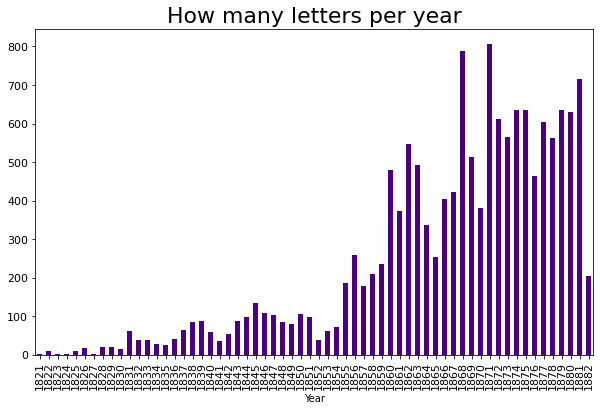

In [16]:
ax = df0.plot(kind='bar', figsize=(10,6), color="indigo", fontsize=11);
#ax.set_alpha(0.5)
ax.set_title("How many letters per year", fontsize=22)
plt.show()

I check the letters containing the word _insectivorous_:

In [17]:
pd.set_option('display.max_colwidth', 60)
word_of_interest = "insectivorous"

def extract_context(text, word, window=30):
    pattern = re.compile(rf".{{0,{window}}}{word}.{{0,{window}}}", re.IGNORECASE)
    match = pattern.search(text)
    return match.group(0) if match else ''

filtered_df = df[df['Transcription'].str.contains(word_of_interest, case=False, na=False)]
filtered_df['Context'] = filtered_df['Transcription'].apply(lambda x: extract_context(x, word_of_interest))
# Temporarily set options to display all rows and columns
pd.set_option('display.max_rows', None)  # None means no limit

print(filtered_df[['Year', 'Context']].sort_values(by='Year'))

# Reset options to default if needed
pd.reset_option('display.max_rows')
pd.reset_option('display.max_colwidth')

       Year                                                      Context
7312   1846  ggot within; so that they are insectivorous.— A Cychrus ...
9839   1860   Feet ———–Birds of Prey. some insectivorous ————Some fis...
1009   1861  colour by the check caused by insectivorous animals. The...
4757   1862  ou sugar? Is the little Heron insectivorous? State somew...
9965   1866  a scarlet insect thus attract insectivorous birds, or fr...
14308  1867  ny one who keeps a variety of insectivorous birds. They ...
8255   1867  They have not even our little insectivorous quadruped th...
14816  1868  resume that on that island no insectivorous bird exists ...
11391  1868  ms a nice fat mouthful for an insectivorous bird, but by...
8136   1868  be exempt from the attacks of insectivorous birds; these...
12845  1868  the necessity there is for an insectivorous non-migrator...
1985   1868  t is but rarely discovered by insectivorous animals and ...
14324  1869  larvæ c. eaten or rejected by insectiv

<ipython-input-17-3e4a2d54cb03>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Context'] = filtered_df['Transcription'].apply(lambda x: extract_context(x, word_of_interest))


In [18]:
filtered_df[['Year', 'Context']].groupby('Year').size().reset_index(name='count_of_texts')

,Year,count_of_texts
0,1846,1
1,1860,1
2,1861,1
3,1862,1
4,1866,1
5,1867,2
6,1868,5
7,1869,2
8,1871,2
9,1874,4


## 3. Linguistic pre-processing

**NB**: From here you can **skip** to the code line "df = pd.read_csv(os.path.join(out_folder, 'transcription_tokens.csv'), sep = "\t")"

Add a space before and after every m-dash:

In [19]:
s = "– – –Museum three — one from"
pat = re.compile(r"(\u2014)")
s = pat.sub(" \\1 ", s)
pat1 = re.compile(r"(\u2013)")
s = pat1.sub(" \\1 ", s)
s = s.replace("  ", " ")
s

' –  –  – Museum three — one from'

In [20]:
s = "– – –Museum three — one from"
pat = re.compile(r"(\u2014)")
pat1 = re.compile(r"(\u2013)")
s = pat.sub(" \\1 ", pat1.sub(" \\1 ", s)).replace("  ", " ")
s

' –  –  – Museum three — one from'

In [21]:
pat = re.compile(r"(\u2014)")
pat1 = re.compile(r"(\u2013)")
df['Transcription'] = [pat.sub(" \\1 ", pat1.sub(" \\1 ", df['Transcription'].iloc[i])).replace("  ", " ") for i in range(df.shape[0])]
df

,File,Year,Sender,Receiver,Transcription
0,DCP-LETT-12349.xml,1879,"Darwin, C. R.","Payne, A. H.",I have no objection to express my opinion on t...
1,DCP-LETT-13057.xml,1881,"Allen, Grant","Darwin, C. R.",I was greatly gratified and not a little flatt...
2,DCP-LETT-11898.xml,1879,"Hamilton, C. W.","Darwin, C. R.",I almost feel that you will not consider me in...
3,DCP-LETT-7806.xml,1871,"Darwin, C. R.","Darwin, Francis",Very many thanks for all that you have done fo...
4,DCP-LETT-11640.xml,1878,"Darwin, C. R.","Flower, W. H.",You will remember the dried wings of the goose...
...,...,...,...,...,...
14911,DCP-LETT-11659.xml,1878,"Darwin, C. R.","Gray, Asa","Dr. Hugo de Vries, who has done such excellent..."
14912,DCP-LETT-11881.xml,1879,"Darwin, C. R.","Vries, Hugo de",I am going to beg a favour of you. I have just...
14913,DCP-LETT-10547.xml,1862,"Walker, Francis","Darwin, C. R.",I received your letter today. The larger brown...
14914,DCP-LETT-2967.xml,1860,"Darwin, C. R.","Sharpey, William",My dear Dr. Sharpey I hear that Mr. Oliver is ...


In [22]:
df[df['File'] == "DCP-LETT-6078.xml"]

,File,Year,Sender,Receiver,Transcription
12845,DCP-LETT-6078.xml,1868,"Weir, J. J.","Darwin, C. R.",I was in Spitalfields recently had some furthe...


load the spaCy language model:

In [23]:
sp = spacy.load("en_core_web_sm")

I split the letters into sentences, although this step may not be needed in the end. **NB** This can take about 10 minutes.

In [24]:
#df['Transcription_sentences'] = [sp(df['Transcription'].iloc[i]) for i in range(df.shape[0])]
df['Transcription_spacy'] = [sp(df['Transcription'].iloc[i]) for i in range(df.shape[0])]
#df['Transcription_sentences'] = [ sentence for sentence in (df['Transcription'].iloc[i]).sents for i in range(df.shape[0])]
df

,File,Year,Sender,Receiver,Transcription,Transcription_spacy
0,DCP-LETT-12349.xml,1879,"Darwin, C. R.","Payne, A. H.",I have no objection to express my opinion on t...,"(I, have, no, objection, to, express, my, opin..."
1,DCP-LETT-13057.xml,1881,"Allen, Grant","Darwin, C. R.",I was greatly gratified and not a little flatt...,"(I, was, greatly, gratified, and, not, a, litt..."
2,DCP-LETT-11898.xml,1879,"Hamilton, C. W.","Darwin, C. R.",I almost feel that you will not consider me in...,"(I, almost, feel, that, you, will, not, consid..."
3,DCP-LETT-7806.xml,1871,"Darwin, C. R.","Darwin, Francis",Very many thanks for all that you have done fo...,"(Very, many, thanks, for, all, that, you, have..."
4,DCP-LETT-11640.xml,1878,"Darwin, C. R.","Flower, W. H.",You will remember the dried wings of the goose...,"(You, will, remember, the, dried, wings, of, t..."
...,...,...,...,...,...,...
14911,DCP-LETT-11659.xml,1878,"Darwin, C. R.","Gray, Asa","Dr. Hugo de Vries, who has done such excellent...","(Dr., Hugo, de, Vries, ,, who, has, done, such..."
14912,DCP-LETT-11881.xml,1879,"Darwin, C. R.","Vries, Hugo de",I am going to beg a favour of you. I have just...,"(I, am, going, to, beg, a, favour, of, you, .,..."
14913,DCP-LETT-10547.xml,1862,"Walker, Francis","Darwin, C. R.",I received your letter today. The larger brown...,"(I, received, your, letter, today, ., The, lar..."
14914,DCP-LETT-2967.xml,1860,"Darwin, C. R.","Sharpey, William",My dear Dr. Sharpey I hear that Mr. Oliver is ...,"(My, dear, Dr., Sharpey, I, hear, that, Mr., O..."


A token simply refers to an individual part of a sentence having some semantic value. Let's see what tokens we have in our document. **NB This takes about 12 minutes**.

In [25]:
df['Tokens'] = [[word.text for word in sp(df['Transcription'].iloc[i])] for i in range(df.shape[0])]
df

,File,Year,Sender,Receiver,Transcription,Transcription_spacy,Tokens
0,DCP-LETT-12349.xml,1879,"Darwin, C. R.","Payne, A. H.",I have no objection to express my opinion on t...,"(I, have, no, objection, to, express, my, opin...","[I, have, no, objection, to, express, my, opin..."
1,DCP-LETT-13057.xml,1881,"Allen, Grant","Darwin, C. R.",I was greatly gratified and not a little flatt...,"(I, was, greatly, gratified, and, not, a, litt...","[I, was, greatly, gratified, and, not, a, litt..."
2,DCP-LETT-11898.xml,1879,"Hamilton, C. W.","Darwin, C. R.",I almost feel that you will not consider me in...,"(I, almost, feel, that, you, will, not, consid...","[I, almost, feel, that, you, will, not, consid..."
3,DCP-LETT-7806.xml,1871,"Darwin, C. R.","Darwin, Francis",Very many thanks for all that you have done fo...,"(Very, many, thanks, for, all, that, you, have...","[Very, many, thanks, for, all, that, you, have..."
4,DCP-LETT-11640.xml,1878,"Darwin, C. R.","Flower, W. H.",You will remember the dried wings of the goose...,"(You, will, remember, the, dried, wings, of, t...","[You, will, remember, the, dried, wings, of, t..."
...,...,...,...,...,...,...,...
14911,DCP-LETT-11659.xml,1878,"Darwin, C. R.","Gray, Asa","Dr. Hugo de Vries, who has done such excellent...","(Dr., Hugo, de, Vries, ,, who, has, done, such...","[Dr., Hugo, de, Vries, ,, who, has, done, such..."
14912,DCP-LETT-11881.xml,1879,"Darwin, C. R.","Vries, Hugo de",I am going to beg a favour of you. I have just...,"(I, am, going, to, beg, a, favour, of, you, .,...","[I, am, going, to, beg, a, favour, of, you, .,..."
14913,DCP-LETT-10547.xml,1862,"Walker, Francis","Darwin, C. R.",I received your letter today. The larger brown...,"(I, received, your, letter, today, ., The, lar...","[I, received, your, letter, today, ., The, lar..."
14914,DCP-LETT-2967.xml,1860,"Darwin, C. R.","Sharpey, William",My dear Dr. Sharpey I hear that Mr. Oliver is ...,"(My, dear, Dr., Sharpey, I, hear, that, Mr., O...","[My, dear, Dr., Sharpey, I, hear, that, Mr., O..."


In [26]:
df[df['File'] == "DCP-LETT-686.xml"]

,File,Year,Sender,Receiver,Transcription,Transcription_spacy,Tokens
5,DCP-LETT-686.xml,1843,"Waterhouse, G. R.","Darwin, C. R.",– Museum three — one from Dr. Richardson who ...,"( , –, Museum, three, —, one, from, Dr., Richa...","[ , –, Museum, three, —, one, from, Dr., Richa..."


### Lemmatisation

I lemmatise the letters. **NB this can take about 12 minutes.**

In [27]:
df['Lemmas'] = [[word.lemma_ for word in sp(df['Transcription'].iloc[i])] for i in range(df.shape[0])]
df

,File,Year,Sender,Receiver,Transcription,Transcription_spacy,Tokens,Lemmas
0,DCP-LETT-12349.xml,1879,"Darwin, C. R.","Payne, A. H.",I have no objection to express my opinion on t...,"(I, have, no, objection, to, express, my, opin...","[I, have, no, objection, to, express, my, opin...","[I, have, no, objection, to, express, my, opin..."
1,DCP-LETT-13057.xml,1881,"Allen, Grant","Darwin, C. R.",I was greatly gratified and not a little flatt...,"(I, was, greatly, gratified, and, not, a, litt...","[I, was, greatly, gratified, and, not, a, litt...","[I, be, greatly, gratified, and, not, a, littl..."
2,DCP-LETT-11898.xml,1879,"Hamilton, C. W.","Darwin, C. R.",I almost feel that you will not consider me in...,"(I, almost, feel, that, you, will, not, consid...","[I, almost, feel, that, you, will, not, consid...","[I, almost, feel, that, you, will, not, consid..."
3,DCP-LETT-7806.xml,1871,"Darwin, C. R.","Darwin, Francis",Very many thanks for all that you have done fo...,"(Very, many, thanks, for, all, that, you, have...","[Very, many, thanks, for, all, that, you, have...","[very, many, thank, for, all, that, you, have,..."
4,DCP-LETT-11640.xml,1878,"Darwin, C. R.","Flower, W. H.",You will remember the dried wings of the goose...,"(You, will, remember, the, dried, wings, of, t...","[You, will, remember, the, dried, wings, of, t...","[you, will, remember, the, dry, wing, of, the,..."
...,...,...,...,...,...,...,...,...
14911,DCP-LETT-11659.xml,1878,"Darwin, C. R.","Gray, Asa","Dr. Hugo de Vries, who has done such excellent...","(Dr., Hugo, de, Vries, ,, who, has, done, such...","[Dr., Hugo, de, Vries, ,, who, has, done, such...","[Dr., Hugo, de, Vries, ,, who, have, do, such,..."
14912,DCP-LETT-11881.xml,1879,"Darwin, C. R.","Vries, Hugo de",I am going to beg a favour of you. I have just...,"(I, am, going, to, beg, a, favour, of, you, .,...","[I, am, going, to, beg, a, favour, of, you, .,...","[I, be, go, to, beg, a, favour, of, you, ., I,..."
14913,DCP-LETT-10547.xml,1862,"Walker, Francis","Darwin, C. R.",I received your letter today. The larger brown...,"(I, received, your, letter, today, ., The, lar...","[I, received, your, letter, today, ., The, lar...","[I, receive, your, letter, today, ., the, larg..."
14914,DCP-LETT-2967.xml,1860,"Darwin, C. R.","Sharpey, William",My dear Dr. Sharpey I hear that Mr. Oliver is ...,"(My, dear, Dr., Sharpey, I, hear, that, Mr., O...","[My, dear, Dr., Sharpey, I, hear, that, Mr., O...","[my, dear, Dr., Sharpey, I, hear, that, Mr., O..."


#### Stopwords exclusion and further filtering
I exclude non-alphabetical characters:

In [28]:
df["Lemmas_clean"] = ''
for i in range(df.shape[0]):
  df['Lemmas_clean'].iloc[i] = [t for t in df['Lemmas'].iloc[i] if t not in '''!()-[]{};:\'"\,<>./?@#$%^&*_~\|–—\“’`''']# and t.isalpha() ]
df

/Users/barbaramcgillivray/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,File,Year,Sender,Receiver,Transcription,Transcription_spacy,Tokens,Lemmas,Lemmas_clean
0,DCP-LETT-12349.xml,1879,"Darwin, C. R.","Payne, A. H.",I have no objection to express my opinion on t...,"(I, have, no, objection, to, express, my, opin...","[I, have, no, objection, to, express, my, opin...","[I, have, no, objection, to, express, my, opin...","[I, have, no, objection, to, express, my, opin..."
1,DCP-LETT-13057.xml,1881,"Allen, Grant","Darwin, C. R.",I was greatly gratified and not a little flatt...,"(I, was, greatly, gratified, and, not, a, litt...","[I, was, greatly, gratified, and, not, a, litt...","[I, be, greatly, gratified, and, not, a, littl...","[I, be, greatly, gratified, and, not, a, littl..."
2,DCP-LETT-11898.xml,1879,"Hamilton, C. W.","Darwin, C. R.",I almost feel that you will not consider me in...,"(I, almost, feel, that, you, will, not, consid...","[I, almost, feel, that, you, will, not, consid...","[I, almost, feel, that, you, will, not, consid...","[I, almost, feel, that, you, will, not, consid..."
3,DCP-LETT-7806.xml,1871,"Darwin, C. R.","Darwin, Francis",Very many thanks for all that you have done fo...,"(Very, many, thanks, for, all, that, you, have...","[Very, many, thanks, for, all, that, you, have...","[very, many, thank, for, all, that, you, have,...","[very, many, thank, for, all, that, you, have,..."
4,DCP-LETT-11640.xml,1878,"Darwin, C. R.","Flower, W. H.",You will remember the dried wings of the goose...,"(You, will, remember, the, dried, wings, of, t...","[You, will, remember, the, dried, wings, of, t...","[you, will, remember, the, dry, wing, of, the,...","[you, will, remember, the, dry, wing, of, the,..."
...,...,...,...,...,...,...,...,...,...
14911,DCP-LETT-11659.xml,1878,"Darwin, C. R.","Gray, Asa","Dr. Hugo de Vries, who has done such excellent...","(Dr., Hugo, de, Vries, ,, who, has, done, such...","[Dr., Hugo, de, Vries, ,, who, has, done, such...","[Dr., Hugo, de, Vries, ,, who, have, do, such,...","[Dr., Hugo, de, Vries, who, have, do, such, ex..."
14912,DCP-LETT-11881.xml,1879,"Darwin, C. R.","Vries, Hugo de",I am going to beg a favour of you. I have just...,"(I, am, going, to, beg, a, favour, of, you, .,...","[I, am, going, to, beg, a, favour, of, you, .,...","[I, be, go, to, beg, a, favour, of, you, ., I,...","[I, be, go, to, beg, a, favour, of, you, I, ha..."
14913,DCP-LETT-10547.xml,1862,"Walker, Francis","Darwin, C. R.",I received your letter today. The larger brown...,"(I, received, your, letter, today, ., The, lar...","[I, received, your, letter, today, ., The, lar...","[I, receive, your, letter, today, ., the, larg...","[I, receive, your, letter, today, the, large, ..."
14914,DCP-LETT-2967.xml,1860,"Darwin, C. R.","Sharpey, William",My dear Dr. Sharpey I hear that Mr. Oliver is ...,"(My, dear, Dr., Sharpey, I, hear, that, Mr., O...","[My, dear, Dr., Sharpey, I, hear, that, Mr., O...","[my, dear, Dr., Sharpey, I, hear, that, Mr., O...","[my, dear, Dr., Sharpey, I, hear, that, Mr., O..."


I exclude stop words, although they will be needed for word embedding training:

In [29]:
stopWords = set(stopwords.words('english'))
df["Lemmas_nostop"] = ''
for i in range(df.shape[0]):
  df['Lemmas_nostop'].iloc[i] = [t for t in df['Lemmas'].iloc[i] if t not in stopWords]
df

/Users/barbaramcgillivray/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,File,Year,Sender,Receiver,Transcription,Transcription_spacy,Tokens,Lemmas,Lemmas_clean,Lemmas_nostop
0,DCP-LETT-12349.xml,1879,"Darwin, C. R.","Payne, A. H.",I have no objection to express my opinion on t...,"(I, have, no, objection, to, express, my, opin...","[I, have, no, objection, to, express, my, opin...","[I, have, no, objection, to, express, my, opin...","[I, have, no, objection, to, express, my, opin...","[I, objection, express, opinion, subject, vivi..."
1,DCP-LETT-13057.xml,1881,"Allen, Grant","Darwin, C. R.",I was greatly gratified and not a little flatt...,"(I, was, greatly, gratified, and, not, a, litt...","[I, was, greatly, gratified, and, not, a, litt...","[I, be, greatly, gratified, and, not, a, littl...","[I, be, greatly, gratified, and, not, a, littl...","[I, greatly, gratified, little, flatter, kind,..."
2,DCP-LETT-11898.xml,1879,"Hamilton, C. W.","Darwin, C. R.",I almost feel that you will not consider me in...,"(I, almost, feel, that, you, will, not, consid...","[I, almost, feel, that, you, will, not, consid...","[I, almost, feel, that, you, will, not, consid...","[I, almost, feel, that, you, will, not, consid...","[I, almost, feel, consider, I, intrusive, ask,..."
3,DCP-LETT-7806.xml,1871,"Darwin, C. R.","Darwin, Francis",Very many thanks for all that you have done fo...,"(Very, many, thanks, for, all, that, you, have...","[Very, many, thanks, for, all, that, you, have...","[very, many, thank, for, all, that, you, have,...","[very, many, thank, for, all, that, you, have,...","[many, thank, I, ., —, earth, Mivart, mean, id..."
4,DCP-LETT-11640.xml,1878,"Darwin, C. R.","Flower, W. H.",You will remember the dried wings of the goose...,"(You, will, remember, the, dried, wings, of, t...","[You, will, remember, the, dried, wings, of, t...","[you, will, remember, the, dry, wing, of, the,...","[you, will, remember, the, dry, wing, of, the,...","[remember, dry, wing, goose, wish, wing, spiri..."
...,...,...,...,...,...,...,...,...,...,...
14911,DCP-LETT-11659.xml,1878,"Darwin, C. R.","Gray, Asa","Dr. Hugo de Vries, who has done such excellent...","(Dr., Hugo, de, Vries, ,, who, has, done, such...","[Dr., Hugo, de, Vries, ,, who, has, done, such...","[Dr., Hugo, de, Vries, ,, who, have, do, such,...","[Dr., Hugo, de, Vries, who, have, do, such, ex...","[Dr., Hugo, de, Vries, ,, excellent, work, cli..."
14912,DCP-LETT-11881.xml,1879,"Darwin, C. R.","Vries, Hugo de",I am going to beg a favour of you. I have just...,"(I, am, going, to, beg, a, favour, of, you, .,...","[I, am, going, to, beg, a, favour, of, you, .,...","[I, be, go, to, beg, a, favour, of, you, ., I,...","[I, be, go, to, beg, a, favour, of, you, I, ha...","[I, go, beg, favour, ., I, read, ,, great, int..."
14913,DCP-LETT-10547.xml,1862,"Walker, Francis","Darwin, C. R.",I received your letter today. The larger brown...,"(I, received, your, letter, today, ., The, lar...","[I, received, your, letter, today, ., The, lar...","[I, receive, your, letter, today, ., the, larg...","[I, receive, your, letter, today, the, large, ...","[I, receive, letter, today, ., large, brown, f..."
14914,DCP-LETT-2967.xml,1860,"Darwin, C. R.","Sharpey, William",My dear Dr. Sharpey I hear that Mr. Oliver is ...,"(My, dear, Dr., Sharpey, I, hear, that, Mr., O...","[My, dear, Dr., Sharpey, I, hear, that, Mr., O...","[my, dear, Dr., Sharpey, I, hear, that, Mr., O...","[my, dear, Dr., Sharpey, I, hear, that, Mr., O...","[dear, Dr., Sharpey, I, hear, Mr., Oliver, can..."


I add the language of the letters in an additional column. **NB This takes 2 minutes.**

In [30]:
transcriptions = df[['Transcription']].to_numpy().flatten().tolist()
df[['language']] = [detect(x) for x in transcriptions]

In [31]:
df

,File,Year,Sender,Receiver,Transcription,Transcription_spacy,Tokens,Lemmas,Lemmas_clean,Lemmas_nostop,language
0,DCP-LETT-12349.xml,1879,"Darwin, C. R.","Payne, A. H.",I have no objection to express my opinion on t...,"(I, have, no, objection, to, express, my, opin...","[I, have, no, objection, to, express, my, opin...","[I, have, no, objection, to, express, my, opin...","[I, have, no, objection, to, express, my, opin...","[I, objection, express, opinion, subject, vivi...",en
1,DCP-LETT-13057.xml,1881,"Allen, Grant","Darwin, C. R.",I was greatly gratified and not a little flatt...,"(I, was, greatly, gratified, and, not, a, litt...","[I, was, greatly, gratified, and, not, a, litt...","[I, be, greatly, gratified, and, not, a, littl...","[I, be, greatly, gratified, and, not, a, littl...","[I, greatly, gratified, little, flatter, kind,...",en
2,DCP-LETT-11898.xml,1879,"Hamilton, C. W.","Darwin, C. R.",I almost feel that you will not consider me in...,"(I, almost, feel, that, you, will, not, consid...","[I, almost, feel, that, you, will, not, consid...","[I, almost, feel, that, you, will, not, consid...","[I, almost, feel, that, you, will, not, consid...","[I, almost, feel, consider, I, intrusive, ask,...",en
3,DCP-LETT-7806.xml,1871,"Darwin, C. R.","Darwin, Francis",Very many thanks for all that you have done fo...,"(Very, many, thanks, for, all, that, you, have...","[Very, many, thanks, for, all, that, you, have...","[very, many, thank, for, all, that, you, have,...","[very, many, thank, for, all, that, you, have,...","[many, thank, I, ., —, earth, Mivart, mean, id...",en
4,DCP-LETT-11640.xml,1878,"Darwin, C. R.","Flower, W. H.",You will remember the dried wings of the goose...,"(You, will, remember, the, dried, wings, of, t...","[You, will, remember, the, dried, wings, of, t...","[you, will, remember, the, dry, wing, of, the,...","[you, will, remember, the, dry, wing, of, the,...","[remember, dry, wing, goose, wish, wing, spiri...",en
...,...,...,...,...,...,...,...,...,...,...,...
14911,DCP-LETT-11659.xml,1878,"Darwin, C. R.","Gray, Asa","Dr. Hugo de Vries, who has done such excellent...","(Dr., Hugo, de, Vries, ,, who, has, done, such...","[Dr., Hugo, de, Vries, ,, who, has, done, such...","[Dr., Hugo, de, Vries, ,, who, have, do, such,...","[Dr., Hugo, de, Vries, who, have, do, such, ex...","[Dr., Hugo, de, Vries, ,, excellent, work, cli...",en
14912,DCP-LETT-11881.xml,1879,"Darwin, C. R.","Vries, Hugo de",I am going to beg a favour of you. I have just...,"(I, am, going, to, beg, a, favour, of, you, .,...","[I, am, going, to, beg, a, favour, of, you, .,...","[I, be, go, to, beg, a, favour, of, you, ., I,...","[I, be, go, to, beg, a, favour, of, you, I, ha...","[I, go, beg, favour, ., I, read, ,, great, int...",en
14913,DCP-LETT-10547.xml,1862,"Walker, Francis","Darwin, C. R.",I received your letter today. The larger brown...,"(I, received, your, letter, today, ., The, lar...","[I, received, your, letter, today, ., The, lar...","[I, receive, your, letter, today, ., the, larg...","[I, receive, your, letter, today, the, large, ...","[I, receive, letter, today, ., large, brown, f...",en
14914,DCP-LETT-2967.xml,1860,"Darwin, C. R.","Sharpey, William",My dear Dr. Sharpey I hear that Mr. Oliver is ...,"(My, dear, Dr., Sharpey, I, hear, that, Mr., O...","[My, dear, Dr., Sharpey, I, hear, that, Mr., O...","[my, dear, Dr., Sharpey, I, hear, that, Mr., O...","[my, dear, Dr., Sharpey, I, hear, that, Mr., O...","[dear, Dr., Sharpey, I, hear, Mr., Oliver, can...",en


How many letters per language?

In [32]:
df[['language']].value_counts()

language
en          14883
fr             12
de             10
ca              4
pt              3
af              1
et              1
it              1
vi              1
dtype: int64

Only keep letters in English:

In [33]:
#df = df[~df.language.isin(['de', 'fr'])]
df = df[df.language.isin(['en'])]
df.shape

(14883, 11)

We only select the letters written by Charles Darwin:

In [34]:
df1 = df[df['Sender'] == "Darwin, C. R."]
df1.shape

(8182, 11)

I check the frequencies of *insectivorous*: (In the context of pandas DataFrames, lambda functions are often used with methods like apply to perform row-wise or column-wise operations in a concise manner)

In [35]:
df[df['Lemmas'].apply(lambda x: 'insectivorous' in x)]

,File,Year,Sender,Receiver,Transcription,Transcription_spacy,Tokens,Lemmas,Lemmas_clean,Lemmas_nostop,language
135,DCP-LETT-10990.xml,1877,"Martins, C. F.","Darwin, C. R.",I am happy to learn that the translation into ...,"(I, am, happy, to, learn, that, the, translati...","[I, am, happy, to, learn, that, the, translati...","[I, be, happy, to, learn, that, the, translati...","[I, be, happy, to, learn, that, the, translati...","[I, happy, learn, translation, French, insecti...",en
318,DCP-LETT-11287.xml,1877,"Darwin, C. R.","Saporta, L. C. J. G. de",I thank you sincerely for your long most inter...,"(I, thank, you, sincerely, for, your, long, mo...","[I, thank, you, sincerely, for, your, long, mo...","[I, thank, you, sincerely, for, your, long, mo...","[I, thank, you, sincerely, for, your, long, mo...","[I, thank, sincerely, long, interesting, lette...",en
662,DCP-LETT-10173.xml,1878,"Marshall, W. C.","Darwin, C. R.",I am sending you with this a plant which I sus...,"(I, am, sending, you, with, this, a, plant, wh...","[I, am, sending, you, with, this, a, plant, wh...","[I, be, send, you, with, this, a, plant, which...","[I, be, send, you, with, this, a, plant, which...","[I, send, plant, I, suspect, insectivorous, ,,...",en
727,DCP-LETT-11494.xml,1878,"Farrer, T. H.","Darwin, C. R.",I inclose a bit of Ledum which if not insectiv...,"(I, inclose, a, bit, of, Ledum, which, if, not...","[I, inclose, a, bit, of, Ledum, which, if, not...","[I, inclose, a, bit, of, Ledum, which, if, not...","[I, inclose, a, bit, of, Ledum, which, if, not...","[I, inclose, bit, Ledum, insectivorous, —, cer...",en
772,DCP-LETT-10007.xml,1875,"Tait, R. L.","Darwin, C. R.",Dr. Burdon Sandersons paper on the leaf curren...,"(Dr., Burdon, Sandersons, paper, on, the, leaf...","[Dr., Burdon, Sandersons, paper, on, the, leaf...","[Dr., Burdon, Sandersons, paper, on, the, leaf...","[Dr., Burdon, Sandersons, paper, on, the, leaf...","[Dr., Burdon, Sandersons, paper, leaf, current...",en
...,...,...,...,...,...,...,...,...,...,...,...
14353,DCP-LETT-10354.xml,1876,"Darwin, C. R.","Dallinger, W. H.",You will find at p. 404 of my Insectivorous Pl...,"(You, will, find, at, p., , 404, , of, my, I...","[You, will, find, at, p., , 404, , of, my, I...","[you, will, find, at, p., , 404, , of, my, i...","[you, will, find, at, p., , 404, , of, my, i...","[find, p., , 404, , insectivorous, plant, re...",en
14655,DCP-LETT-10619.xml,1876,"Darwin, C. R.","Carus, J. V.",I sent by this morning’s Post the 4 first perf...,"(I, sent, by, this, morning, ’s, Post, the, 4,...","[I, sent, by, this, morning, ’s, Post, the, 4,...","[I, send, by, this, morning, ’s, post, the, 4,...","[I, send, by, this, morning, ’s, post, the, 4,...","[I, send, morning, ’s, post, 4, , first, perf...",en
14780,DCP-LETT-11301.xml,1875,"Thiselton-Dyer, W. T.","Darwin, C. R.",In Insectivorous plants p. 353 you suggest tha...,"(In, Insectivorous, plants, p., , 353, , you...","[In, Insectivorous, plants, p., , 353, , you...","[in, insectivorous, plant, p., , 353, , you,...","[in, insectivorous, plant, p., , 353, , you,...","[insectivorous, plant, p., , 353, , suggest,...",en
14816,DCP-LETT-5985.xml,1868,"Weir, J. J.","Darwin, C. R.",I am very much obliged to you for your Work on...,"(I, am, very, much, obliged, to, you, for, you...","[I, am, very, much, obliged, to, you, for, you...","[I, be, very, much, obliged, to, you, for, you...","[I, be, very, much, obliged, to, you, for, you...","[I, much, obliged, work, domesticate, animal, ...",en


In [36]:
len(df[df['Lemmas'].apply(lambda x: 'insectivorous' in x)])

92

In [37]:
len(df1[df1['Lemmas'].apply(lambda x: 'insectivorous' in x)])

25

In [38]:
len(df[df['Lemmas'].apply(lambda x: 'transmutation' in x)])

44

In [39]:
len(df1[df1['Lemmas'].apply(lambda x: 'transmutation' in x)])

4

In [40]:
word_of_interest = 'insectivorous'
filtered_df1 = df1[df1['Lemmas_clean'].apply(lambda x: word_of_interest in x)]
pd.set_option('display.max_colwidth', 100)

filtered_df1.shape
filtered_df1[['Year']].groupby('Year').size().reset_index(name='count_of_texts')

,Year,count_of_texts
0,1846,1
1,1862,1
2,1874,3
3,1875,12
4,1876,4
5,1877,1
6,1879,1
7,1881,1
8,1882,1


In [41]:
word_of_interest = 'insectivorous'
filtered_df1 = df1[df1['Transcription'].str.contains(word_of_interest, case=False, na=False)]
pd.set_option('display.max_colwidth', 100)

filtered_df1.shape
filtered_df1[['Year']].groupby('Year').size().reset_index(name='count_of_texts')

,Year,count_of_texts
0,1846,1
1,1862,1
2,1874,3
3,1875,31
4,1876,6
5,1877,3
6,1878,2
7,1879,1
8,1880,1
9,1881,1


In [42]:
word_of_interest = 'transmutation'
filtered_df1 = df1[df1['Lemmas_clean'].apply(lambda x: word_of_interest in x)]
pd.set_option('display.max_colwidth', 100)

filtered_df1.shape
filtered_df1[['Year']].groupby('Year').size().reset_index(name='count_of_texts')

,Year,count_of_texts
0,1844,1
1,1863,2
2,1866,1


In [43]:
df1.columns

Index(['File', 'Year', 'Sender', 'Receiver', 'Transcription',
       'Transcription_spacy', 'Tokens', 'Lemmas', 'Lemmas_clean',
       'Lemmas_nostop', 'language'],
      dtype='object')

In [44]:
df1.head()

,File,Year,Sender,Receiver,Transcription,Transcription_spacy,Tokens,Lemmas,Lemmas_clean,Lemmas_nostop,language
0,DCP-LETT-12349.xml,1879,"Darwin, C. R.","Payne, A. H.","I have no objection to express my opinion on the subject of vivisection. I detest cruelty, any p...","(I, have, no, objection, to, express, my, opinion, on, the, subject, of, vivisection, ., I, dete...","[I, have, no, objection, to, express, my, opinion, on, the, subject, of, vivisection, ., I, dete...","[I, have, no, objection, to, express, my, opinion, on, the, subject, of, vivisection, ., I, det,...","[I, have, no, objection, to, express, my, opinion, on, the, subject, of, vivisection, I, det, cr...","[I, objection, express, opinion, subject, vivisection, ., I, det, cruelty, ,, physiologist, inve...",en
3,DCP-LETT-7806.xml,1871,"Darwin, C. R.","Darwin, Francis",Very many thanks for all that you have done for me. — What on earth Mivart can mean by the ident...,"(Very, many, thanks, for, all, that, you, have, done, for, me, ., —, What, on, earth, Mivart, ca...","[Very, many, thanks, for, all, that, you, have, done, for, me, ., —, What, on, earth, Mivart, ca...","[very, many, thank, for, all, that, you, have, do, for, I, ., —, what, on, earth, Mivart, can, m...","[very, many, thank, for, all, that, you, have, do, for, I, what, on, earth, Mivart, can, mean, b...","[many, thank, I, ., —, earth, Mivart, mean, identity, eye, Cephelopods, Vertebrata, I, conceive,...",en
4,DCP-LETT-11640.xml,1878,"Darwin, C. R.","Flower, W. H.",You will remember the dried wings of the goose your wish for other wings in spirits. I have this...,"(You, will, remember, the, dried, wings, of, the, goose, your, wish, for, other, wings, in, spir...","[You, will, remember, the, dried, wings, of, the, goose, your, wish, for, other, wings, in, spir...","[you, will, remember, the, dry, wing, of, the, goose, your, wish, for, other, wing, in, spirit, ...","[you, will, remember, the, dry, wing, of, the, goose, your, wish, for, other, wing, in, spirit, ...","[remember, dry, wing, goose, wish, wing, spirit, ., I, day, hear, Mr, R., , a., , Blair, Sedal...",en
9,DCP-LETT-8650F.xml,1874,"Darwin, C. R.","Spengel, J. W.","I thank you most sincerely for your kindness in having sent me your Fortschritte c, which it wil...","(I, thank, you, most, sincerely, for, your, kindness, in, having, sent, me, your, Fortschritte, ...","[I, thank, you, most, sincerely, for, your, kindness, in, having, sent, me, your, Fortschritte, ...","[I, thank, you, most, sincerely, for, your, kindness, in, having, send, I, your, Fortschritte, c...","[I, thank, you, most, sincerely, for, your, kindness, in, having, send, I, your, Fortschritte, c...","[I, thank, sincerely, kindness, send, I, Fortschritte, c, ,, extremely, useful, interesting, I, ...",en
10,DCP-LETT-13731.xml,1882,"Darwin, C. R.","Jenner, William",I am much obliged for the honour of your invitation to attend the meeting at the C. of Phys. on ...,"(I, am, much, obliged, for, the, honour, of, your, invitation, to, attend, the, meeting, at, the...","[I, am, much, obliged, for, the, honour, of, your, invitation, to, attend, the, meeting, at, the...","[I, be, much, oblige, for, the, honour, of, your, invitation, to, attend, the, meeting, at, the,...","[I, be, much, oblige, for, the, honour, of, your, invitation, to, attend, the, meeting, at, the,...","[I, much, oblige, honour, invitation, attend, meeting, C., , Phys, ., , 28th, ., —, I, feel, d...",en


I save the dataframe to a file:

In [45]:
df.to_csv(os.path.join(out_folder, 'transcription_tokens.csv'), encoding='utf-8', index = False, sep = "\t", quoting=csv.QUOTE_NONE)
df1.to_csv(os.path.join(out_folder, 'transcription_tokens_onlyDarwin.csv'), encoding='utf-8', index = False, sep = "\t", quoting=csv.QUOTE_NONE)

NB: If you try and read the csv back as a data frame, you will see the columns containing lists of strings appearing with quotes around the list elements; this causes problems when training the Word2Vec models as the models interpret the input as a sequence of characters, rather than a sequence of tokens. So, you should not read the csv to define df and df1, but rather create it with the steps above.

## 4. Training word embeddings

Function for printing the vocabulary of a model

In [46]:
def print_vocab(model, top_n = None):
  count = 0
  if top_n is not None:
    for index, word in enumerate(model.wv.index_to_key):
      count+= 1
      if count < top_n:
        print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")
  else:
    for index, word in enumerate(model.wv.index_to_key):
      print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")

In [47]:
pd.set_option('display.max_colwidth', -1)
(df1['Lemmas_clean']).head()

<ipython-input-47-015f88530530>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


0     [I, have, no, objection, to, express, my, opinion, on, the, subject, of, vivisection, I, det, cruelty, any, physiologist, who, in, investigation, cause, suffering, which, can, possibly, be, avoid, deserve, universal, execration, but, I, be, convinced, that, physiology, which, can, not, progress, without, experiment, on, living, animal, be, one, of, the, most, important, of, the, Sciences, that, it, will, hereafter, confer, inestimable, benefit, on, mankind, whether, or, not, it, have, already, improve, the, practice, of, medicine, be, a, question, of, comparative, insignificance, for, the, history, of, Science, shews, that, benefit, to, man, be, generally, the, indirect, result, of, the, search, for, ...]
3     [very, many, thank, for, all, that, you, have, do, for, I, what, on, earth, Mivart, can, mean, by, the, identity, between, eye, of, Cephelopods, Vertebrata, I, can, not, conceive, they, must, be, transparent, furnish, with, nerve, with, a, lens, of, some, kind, the, striki

In [48]:
print(df1['Lemmas_clean'].head())

0     [I, have, no, objection, to, express, my, opinion, on, the, subject, of, vivisection, I, det, cruelty, any, physiologist, who, in, investigation, cause, suffering, which, can, possibly, be, avoid, deserve, universal, execration, but, I, be, convinced, that, physiology, which, can, not, progress, without, experiment, on, living, animal, be, one, of, the, most, important, of, the, Sciences, that, it, will, hereafter, confer, inestimable, benefit, on, mankind, whether, or, not, it, have, already, improve, the, practice, of, medicine, be, a, question, of, comparative, insignificance, for, the, history, of, Science, shews, that, benefit, to, man, be, generally, the, indirect, result, of, the, search, for, ...]
3     [very, many, thank, for, all, that, you, have, do, for, I, what, on, earth, Mivart, can, mean, by, the, identity, between, eye, of, Cephelopods, Vertebrata, I, can, not, conceive, they, must, be, transparent, furnish, with, nerve, with, a, lens, of, some, kind, the, striki

I train Word2Vec embeddings from the letters. **You can skip this cell.**

`min_count`: the minimum frequency threshold allowed for a word to be included

`vector_size`: the number of dimensions in which we wish to represent our word. This is the size of the word embedding; typically between 100 and 1,000.

`window`: The size of the context window determines how many words before and after a given word would be included as context words of the given word.  Typically between 5 and 10.

`sg`: – Training algorithm: 1 for skip-gram; otherwise CBOW.


In [49]:
start = time.time()
cbow_w5_f1_300 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=1, vector_size=300, window = 5, sg = 0)
end = time.time()
print("It has taken", round(end - start), "seconds")
start = time.time()
cbow_w5_f1_1000 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=1, vector_size=1000, window = 5, sg = 0)
end = time.time()
print("It has taken", round(end - start), "seconds")

It has taken 8 seconds
It has taken 22 seconds


In [50]:
print_vocab(cbow_w5_f1_300, 10)

word #0/32801 is I
word #1/32801 is the
word #2/32801 is be
word #3/32801 is to
word #4/32801 is of
word #5/32801 is have
word #6/32801 is you
word #7/32801 is in
word #8/32801 is a


In [51]:
# Check the vocabulary
vocabulary = list(cbow_w5_f1_300.wv.index_to_key)
print(vocabulary[:20])  # Display the first 20 words in the vocabulary

['I', 'the', 'be', 'to', 'of', 'have', 'you', 'in', 'a', 'that', 'it', '\xa0', 'for', 'not', 'my', 'as', 'your', 'on', 'will', 'with']


Different parameters. **You can skip this cell.**

In [52]:
#300 dimensions:
start = time.time()
cbow_w5_f0_300 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=0, vector_size=300, window = 5, sg = 0)
end = time.time()
print("cbow_w5_f0_300 has taken", round(end - start), "seconds")
start = time.time()
sg_w5_f1_300 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=1, vector_size=300, window = 5, sg = 1)
end = time.time()
print("sg_w5_f1_300 has taken", round(end - start), "seconds")
start = time.time()
sg_w5_f0_300 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=0, vector_size=300, window = 5, sg = 1)
end = time.time()
print("sg_w5_f0_300 has taken", round(end - start), "seconds")
start = time.time()
cbow_w10_f1_300 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=1, vector_size=300, window = 10, sg = 0)
end = time.time()
print("cbow_w10_f1_300 has taken", round(end - start), "seconds")
start = time.time()
cbow_w10_f0_300 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=0, vector_size=300, window = 10, sg = 0)
end = time.time()
print("cbow_w10_f0_300 has taken", round(end - start), "seconds")
start = time.time()
sg_w10_f1_300 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=1, vector_size=300, window = 10, sg = 1)
end = time.time()
print("sg_w10_f1_300 has taken", round(end - start), "seconds")
start = time.time()
sg_w10_f0_300 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=0, vector_size=300, window = 10, sg = 1)
end = time.time()
print("sg_w10_f0_300 has taken", round(end - start), "seconds")
#1000 dimensions:
start = time.time()
cbow_w5_f0_1000 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=0, vector_size=1000, window = 5, sg = 0)
end = time.time()
print("cbow_w5_f0_1000 has taken", round(end - start), "seconds")
start = time.time()
sg_w5_f1_1000 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=1, vector_size=1000, window = 5, sg = 1)
end = time.time()
print("sg_w5_f1_1000 has taken", round(end - start), "seconds")
start = time.time()
sg_w5_f0_1000 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=0, vector_size=1000, window = 5, sg = 1)
end = time.time()
print("sg_w5_f0_1000 has taken", round(end - start), "seconds")
start = time.time()
cbow_w10_f1_1000 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=1, vector_size=1000, window = 10, sg = 0)
end = time.time()
print("cbow_w10_f1_1000 has taken", round(end - start), "seconds")
start = time.time()
cbow_w10_f0_1000 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=0, vector_size=1000, window = 10, sg = 0)
end = time.time()
print("cbow_w10_f0_1000 has taken", round(end - start), "seconds")
start = time.time()
sg_w10_f1_1000 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=1, vector_size=1000, window = 10, sg = 1)
end = time.time()
print("sg_w10_f1_1000 has taken", round(end - start), "seconds")
start = time.time()
sg_w10_f0_1000 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=0, vector_size=1000, window = 10, sg = 1)
end = time.time()
print("sg_w10_f0_1000 has taken", round(end - start), "seconds")

cbow_w5_f0_300 has taken 8 seconds
sg_w5_f1_300 has taken 26 seconds
sg_w5_f0_300 has taken 25 seconds
cbow_w10_f1_300 has taken 9 seconds
cbow_w10_f0_300 has taken 9 seconds
sg_w10_f1_300 has taken 45 seconds
sg_w10_f0_300 has taken 45 seconds
cbow_w5_f0_1000 has taken 16 seconds
sg_w5_f1_1000 has taken 56 seconds
sg_w5_f0_1000 has taken 59 seconds
cbow_w10_f1_1000 has taken 20 seconds
cbow_w10_f0_1000 has taken 20 seconds
sg_w10_f1_1000 has taken 105 seconds
sg_w10_f0_1000 has taken 120 seconds


Skip-gram is more computationally expensive, especially with larger window sizes.

Let's save the models so we can use them later. **You can skip this cell.**

In [53]:
models_folder = '/Users/barbaramcgillivray/Library/CloudStorage/OneDrive-King\'sCollegeLondon/Research/2024/Darwin/Code/Models/'
models = [cbow_w5_f1_300, cbow_w5_f1_1000, cbow_w5_f0_300, cbow_w5_f0_1000, sg_w5_f1_300, sg_w5_f1_1000, sg_w5_f0_300, sg_w5_f0_1000, cbow_w10_f1_300, cbow_w10_f1_1000, cbow_w10_f0_300, cbow_w10_f0_1000, sg_w10_f1_300, sg_w10_f1_1000, sg_w10_f0_300, sg_w10_f0_1000]
models_names = ['cbow_w5_f1_300', 'cbow_w5_f1_1000', 'cbow_w5_f0_300', 'cbow_w5_f0_1000', 'sg_w5_f1_300', 'sg_w5_f1_1000', 'sg_w5_f0_300', 'sg_w5_f0_1000', 'cbow_w10_f1_300', 'cbow_w10_f1_1000', 'cbow_w10_f0_300', 'cbow_w10_f0_1000', 'sg_w10_f1_300', 'sg_w10_f1_1000', 'sg_w10_f0_300', 'sg_w10_f0_1000']
for i in range(len(models)):
  print("Saving model number", i+1)
  models[i].save(os.path.join(models_folder, models_names[i]))

Saving model number 1
Saving model number 2
Saving model number 3
Saving model number 4
Saving model number 5
Saving model number 6
Saving model number 7
Saving model number 8
Saving model number 9
Saving model number 10
Saving model number 11
Saving model number 12
Saving model number 13
Saving model number 14
Saving model number 15
Saving model number 16


Load the models:

In [54]:
models_folder = '/Users/barbaramcgillivray/Library/CloudStorage/OneDrive-King\'sCollegeLondon/Research/2024/Darwin/Code/Models/'
cbow_w5_f1_300 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w5_f1_300"))
cbow_w5_f0_300 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w5_f0_300"))
sg_w5_f1_300 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w5_f1_300"))
sg_w5_f0_300 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w5_f0_300"))
cbow_w10_f1_300 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w10_f1_300"))
cbow_w10_f0_300 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w10_f0_300"))
sg_w10_f1_300 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w10_f1_300"))
sg_w10_f0_300 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w10_f0_300"))
cbow_w5_f1_1000 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w5_f1_1000"))
cbow_w5_f0_1000 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w5_f0_1000"))
sg_w5_f1_1000 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w5_f1_1000"))
sg_w5_f0_1000 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w5_f0_1000"))
cbow_w10_f1_1000 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w10_f1_1000"))
cbow_w10_f0_1000 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w10_f0_1000"))
sg_w10_f1_1000 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w10_f1_1000"))
sg_w10_f0_1000 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w10_f0_1000"))
models = [cbow_w5_f1_300, cbow_w5_f1_1000, cbow_w5_f0_300, cbow_w5_f0_1000, sg_w5_f1_300, sg_w5_f1_1000, sg_w5_f0_300, sg_w5_f0_1000, cbow_w10_f1_300, cbow_w10_f1_1000, cbow_w10_f0_300, cbow_w10_f0_1000, sg_w10_f1_300, sg_w10_f1_1000, sg_w10_f0_300, sg_w10_f0_1000]
models_names = ['cbow_w5_f1_300', 'cbow_w5_f1_1000', 'cbow_w5_f0_300', 'cbow_w5_f0_1000', 'sg_w5_f1_300', 'sg_w5_f1_1000', 'sg_w5_f0_300', 'sg_w5_f0_1000', 'cbow_w10_f1_300', 'cbow_w10_f1_1000', 'cbow_w10_f0_300', 'cbow_w10_f0_1000', 'sg_w10_f1_300', 'sg_w10_f1_1000', 'sg_w10_f0_300', 'sg_w10_f0_1000']


Print the first ten words of the vocabulary of each model

In [55]:
for i in range(len(models)):
  print(models_names[i])
  print_vocab(models[i], 10)

cbow_w5_f1_300
word #0/32801 is I
word #1/32801 is the
word #2/32801 is be
word #3/32801 is to
word #4/32801 is of
word #5/32801 is have
word #6/32801 is you
word #7/32801 is in
word #8/32801 is a
cbow_w5_f1_1000
word #0/32801 is I
word #1/32801 is the
word #2/32801 is be
word #3/32801 is to
word #4/32801 is of
word #5/32801 is have
word #6/32801 is you
word #7/32801 is in
word #8/32801 is a
cbow_w5_f0_300
word #0/32801 is I
word #1/32801 is the
word #2/32801 is be
word #3/32801 is to
word #4/32801 is of
word #5/32801 is have
word #6/32801 is you
word #7/32801 is in
word #8/32801 is a
cbow_w5_f0_1000
word #0/32801 is I
word #1/32801 is the
word #2/32801 is be
word #3/32801 is to
word #4/32801 is of
word #5/32801 is have
word #6/32801 is you
word #7/32801 is in
word #8/32801 is a
sg_w5_f1_300
word #0/32801 is I
word #1/32801 is the
word #2/32801 is be
word #3/32801 is to
word #4/32801 is of
word #5/32801 is have
word #6/32801 is you
word #7/32801 is in
word #8/32801 is a
sg_w5_f1_1000
w

Let's look at the most similar words (i.e. neighbours) of *letter*:

In [56]:
for i in range(len(models)):
  print(models_names[i], models[i].wv.similar_by_word('letter', 10))

cbow_w5_f1_300 [('note', 0.9269230961799622), ('pamphlet', 0.6943146586418152), ('article', 0.6838192343711853), ('essay', 0.6166831851005554), ('lecture', 0.5890665650367737), ('paper', 0.5875340700149536), ('sentence', 0.5856435894966125), ('report', 0.5833606123924255), ('Synonyms', 0.5782941579818726), ('Pharmacology', 0.5753889679908752)]
cbow_w5_f1_1000 [('note', 0.9267536997795105), ('article', 0.6755743622779846), ('pamphlet', 0.6730231046676636), ('essay', 0.6061923503875732), ('paper', 0.600414514541626), ('photograph', 0.5940173864364624), ('message', 0.5881654620170593), ('sentence', 0.5871254205703735), ('biologica', 0.5868968963623047), ('query', 0.5831491351127625)]
cbow_w5_f0_300 [('note', 0.9180386662483215), ('pamphlet', 0.7039083242416382), ('article', 0.6729468107223511), ('essay', 0.6376064419746399), ('sentence', 0.6197246313095093), ('paper', 0.6073863506317139), ('kindness', 0.589067280292511), ('lecture', 0.5777720212936401), ('Review', 0.5628402233123779), ('q

#### Model choice
In order to do a systematic evaluation and choose the best model for our purposes, we would need to test them all against some "gold standard", e.g. a list of known synonyms for this corpus. This is the list suggested by Liz:
superfluous, unnecessary
Display, exhibit
Mimetic, imitative
Disappear, vanish
Alike, identical

In [57]:
synonyms = dict({"superfluous": "unnecessary", "display": "exhibit", "mimetic" : "imitative", "disappear" : "vanish", "alike" : "identical"})
synonyms

{'superfluous': 'unnecessary',
 'display': 'exhibit',
 'mimetic': 'imitative',
 'disappear': 'vanish',
 'alike': 'identical'}

Check that the synonym pairs are preserved by the models:

In [58]:
models_synonymity_average = dict()
for i in range(len(models)):
  print("Model", models_names[i])
  average_synonimity = 0
  synonymities = list()
  for s1 in synonyms:
    print("\tSimilarity between", s1, "and", synonyms[s1],  "in", models_names[i], models[i].wv.similarity(s1, synonyms[s1]))
    synonymities.append(models[i].wv.similarity(s1, synonyms[s1]))
  average_synonimity = mean(synonymities)
  print(average_synonimity)
  models_synonymity_average[models_names[i]] = average_synonimity
models_synonymity_average

Model cbow_w5_f1_300
	Similarity between superfluous and unnecessary in cbow_w5_f1_300 0.44819772
	Similarity between display and exhibit in cbow_w5_f1_300 0.8669995
	Similarity between mimetic and imitative in cbow_w5_f1_300 0.25633436
	Similarity between disappear and vanish in cbow_w5_f1_300 0.51203924
	Similarity between alike and identical in cbow_w5_f1_300 0.74925506
0.56656516
Model cbow_w5_f1_1000
	Similarity between superfluous and unnecessary in cbow_w5_f1_1000 0.6555686
	Similarity between display and exhibit in cbow_w5_f1_1000 0.8169801
	Similarity between mimetic and imitative in cbow_w5_f1_1000 0.33588558
	Similarity between disappear and vanish in cbow_w5_f1_1000 0.49898577
	Similarity between alike and identical in cbow_w5_f1_1000 0.7816464
0.6178133
Model cbow_w5_f0_300
	Similarity between superfluous and unnecessary in cbow_w5_f0_300 0.62625235
	Similarity between display and exhibit in cbow_w5_f0_300 0.803046
	Similarity between mimetic and imitative in cbow_w5_f0_30

{'cbow_w5_f1_300': 0.56656516,
 'cbow_w5_f1_1000': 0.6178133,
 'cbow_w5_f0_300': 0.61118966,
 'cbow_w5_f0_1000': 0.63577884,
 'sg_w5_f1_300': 0.71775895,
 'sg_w5_f1_1000': 0.72672546,
 'sg_w5_f0_300': 0.71218824,
 'sg_w5_f0_1000': 0.7289952,
 'cbow_w10_f1_300': 0.54717714,
 'cbow_w10_f1_1000': 0.52169347,
 'cbow_w10_f0_300': 0.5605578,
 'cbow_w10_f0_1000': 0.5062269,
 'sg_w10_f1_300': 0.67646754,
 'sg_w10_f1_1000': 0.6799563,
 'sg_w10_f0_300': 0.67861974,
 'sg_w10_f0_1000': 0.6752735}

I choose the model that maximises the average similarity between synonyms:

In [59]:
model_chosen_name = max(models_synonymity_average, key=models_synonymity_average.get)
for i in range(len(models)):
  if models_names[i] == model_chosen_name:
    models[i].save(os.path.join(models_folder, "Chosen_model"))
model_chosen_name

'sg_w5_f0_1000'

# 5. Semantic change with cosine similarity

## Step 1: Define two time periods and split the corpus

In [60]:
date = 1859
time_period_1 = list(range(min(df1['Year']),date+1))
time_period_2 = list(range(date+1,max(df1['Year'])+1))
print(time_period_1, time_period_2)

[1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859] [1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882]


In [61]:
(df['Year']).describe()

count    14883.000000
mean     1867.107505 
std      11.500974   
min      1821.000000 
25%      1862.000000 
50%      1869.000000 
75%      1876.000000 
max      1882.000000 
Name: Year, dtype: float64

In [62]:
df_t1 = df1[df1['Year'].isin(time_period_1)]
df_t2 = df1[df1['Year'].isin(time_period_2)]

Check the start and end dates:

In [63]:
max(df_t1['Year'])

1859

Check that I haven't lost any line:

In [70]:
df1.shape[0] == df_t1.shape[0] + df_t2.shape[0]

True

## Step 2. Train word embeddings for the two time periods


I train two word2vec models, one for each dataframe corresponding to a time period. I choose the parameters that led to the best model (sg_w5_f0_1000). This takes approximately 5 minutes. **You can skip this cell.**

In [72]:
model1 = gensim.models.Word2Vec(df_t1['Lemmas_clean'], min_count=1, vector_size=1000, window = 5, sg = 1)
model2 = gensim.models.Word2Vec(df_t2['Lemmas_clean'], min_count=1, vector_size=1000, window = 5, sg = 1)

Save the models. **You can skip this cell.**

In [73]:
models = [model1, model2]
models_names = ["model1", "model2"]
for i in range(len(models)):
  print("Saving model number", i+1)
  models[i].save(os.path.join(models_folder, models_names[i]))

Saving model number 1
Saving model number 2


I load the models:

In [74]:
model1 = gensim.models.Word2Vec.load(os.path.join(models_folder, "model1"))
model2 = gensim.models.Word2Vec.load(os.path.join(models_folder, "model2"))
models = [model1, model2]
models_names = ["model1", "model2"]

What are the vocabularies of these models?

In [75]:
print_vocab(model1, 10)

word #0/19843 is I
word #1/19843 is the
word #2/19843 is be
word #3/19843 is to
word #4/19843 is of
word #5/19843 is have
word #6/19843 is you
word #7/19843 is in
word #8/19843 is a


In [76]:
print_vocab(model2,10)

word #0/24637 is I
word #1/24637 is the
word #2/24637 is be
word #3/24637 is to
word #4/24637 is of
word #5/24637 is have
word #6/24637 is you
word #7/24637 is in
word #8/24637 is a


In [77]:
print(str(len(list(model1.wv.index_to_key))))
print(str(len(list(model2.wv.index_to_key))))

19843
24637


The intersection between the vocabularies of the two models:

In [78]:
vocab1 = set(list(model1.wv.index_to_key))
vocab2 = set(list(model2.wv.index_to_key))
len(vocab1.intersection(vocab2))

11679

## Step 3. Embedding space alignment

I will be using code from https://gist.github.com/zhicongchen/9e23d5c3f1e5b1293b16133485cd17d8, ported from HistWords <https://github.com/williamleif/histwords>.

First, I define a function to find the intersection between the vocabularies of two word2vec models:

In [79]:
def intersection_align_gensim(m1, m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.index_to_key)
    vocab_m2 = set(m2.wv.index_to_key)

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words: common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1 - common_vocab and not vocab_m2 - common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.get_vecattr(w, "count") + m2.wv.get_vecattr(w, "count"), reverse=True)
    # print(len(common_vocab))

    # Then for each model...
    for m in [m1, m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.key_to_index[w] for w in common_vocab]
        old_arr = m.wv.vectors
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.vectors = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        new_key_to_index = {}
        new_index_to_key = []
        for new_index, key in enumerate(common_vocab):
            new_key_to_index[key] = new_index
            new_index_to_key.append(key)
        m.wv.key_to_index = new_key_to_index
        m.wv.index_to_key = new_index_to_key
        
        print(len(m.wv.key_to_index), len(m.wv.vectors))
        
    return (m1,m2)

Then, I define a function for aligning two spaces with [Orthogonal Procrustes](https://simonensemble.github.io/2018-10/orthogonal-procrustes.html):

In [80]:
def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """
    Original script: https://gist.github.com/quadrismegistus/09a93e219a6ffc4f216fb85235535faf
    Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
        
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """

    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the (normalized) embedding matrices
    base_vecs = in_base_embed.wv.get_normed_vectors()
    other_vecs = in_other_embed.wv.get_normed_vectors()

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one, i.e. multiplying the embedding matrix by "ortho"
    other_embed.wv.vectors = (other_embed.wv.vectors).dot(ortho)    
    
    return other_embed

Now I can apply the function to my models:

In [81]:
smart_procrustes_align_gensim(model1, model2, words=None)

11679 11679
11679 11679


Now the two models have been aligned and have the same vocabulary:

In [82]:
len(model1.wv.index_to_key)

11679

In [83]:
len(model2.wv.index_to_key)

11679

In [84]:
model1.wv.index_to_key == model2.wv.index_to_key

True

I print the vocabulary:

In [85]:
model1.wv.index_to_key

['I',
 'the',
 'be',
 'to',
 'of',
 'have',
 'you',
 'in',
 'a',
 'that',
 'it',
 '\xa0',
 'for',
 'not',
 'my',
 'as',
 'your',
 'on',
 'will',
 'with',
 'very',
 'but',
 'which',
 'do',
 'this',
 'he',
 'at',
 'so',
 'if',
 'by',
 'or',
 'from',
 'much',
 'Darwin',
 'think',
 'can',
 'all',
 'and',
 'they',
 'about',
 'one',
 'would',
 'some',
 'see',
 'any',
 'send',
 'good',
 'say',
 'what',
 'we',
 'know',
 'more',
 'write',
 'an',
 'thank',
 'make',
 'most',
 'letter',
 'shall',
 'well',
 'there',
 'no',
 'give',
 'believe',
 '’s',
 'when',
 'work',
 'hear',
 'great',
 'many',
 'time',
 'his',
 'yours',
 'other',
 'case',
 'how',
 'now',
 'C.',
 'dear',
 'whether',
 'like',
 'must',
 'sincerely',
 'plant',
 'hope',
 'shd',
 'could',
 'read',
 'than',
 'go',
 'little',
 'find',
 'Ch',
 'Sir',
 'may',
 'out',
 'seem',
 'such',
 'tell',
 'get',
 'day',
 'come',
 'kind',
 'take',
 'two',
 'long',
 'specie',
 'only',
 'up',
 'note',
 'man',
 'ever',
 'wish',
 'subject',
 'quite',
 'bo

I save the aligned models:

In [86]:
for i in range(len(models)):
  print(models_names[i])
  models[i].save(os.path.join(models_folder, models_names[i] + "_aligned"))

model1
model2


Let's look at the similarity between two words in the two spaces:

In [87]:
model1.wv.similarity("letter", "note")

0.8562598

In [88]:
model2.wv.similarity("letter", "note")

0.843798

## Step 4: Measure change

Now I can measure the cosine similarity between the embedding of a word in the first time period and the embedding of the same word in the second time period. 

Let's define a function that calculates the cosine similarity between the embedding of a word in t1 and the embedding of the same word in t2:

In [89]:
def cosine_similarity(word):
  sc = 1-spatial.distance.cosine(model1.wv[word], model2.wv[word])
  return sc

Now I calculate the semantic similarity for all words in the vocabulary, and store this in the dataframe cosine_similarity; I also add a column for the frequency of the word in the first space and another one for its frequency in the second space:

In [90]:
cosine_similarity_df = pd.DataFrame(([w, cosine_similarity(w), model1.wv.get_vecattr(w, "count") , model2.wv.get_vecattr(w, "count") ] for w in model1.wv.index_to_key), columns = ('Word', 'Cosine_similarity', "Frequency_t1", "Frequency_t2"))
cosine_similarity_df

,Word,Cosine_similarity,Frequency_t1,Frequency_t2
0,I,0.936364,35816,60725
1,the,0.921466,29467,50683
2,be,0.935222,26921,45232
3,to,0.918717,21940,36987
4,of,0.887011,20519,36041
...,...,...,...,...
11674,dwarfer,0.898784,1,2
11675,whera,0.933298,1,2
11676,Perry,0.954648,1,2
11677,withhold,0.949160,1,2


Visualise the distribution of the semantic similarity scores with a histogram:

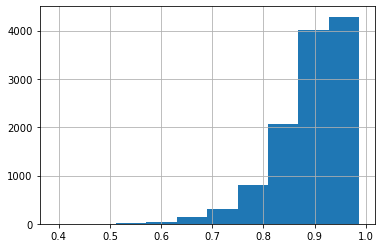

In [91]:
hist = cosine_similarity_df['Cosine_similarity'].hist()

Now I sort by decreasing semantic change score:

In [92]:
cosine_similarity_df_sorted = cosine_similarity_df.sort_values(by='Cosine_similarity', ascending=True)
cosine_similarity_df_sorted.head()

,Word,Cosine_similarity,Frequency_t1,Frequency_t2
1596,Lythrum,0.392441,36,60
1280,Primula,0.425859,48,83
1885,Dallas,0.470409,29,47
1892,,0.470716,28,47
1431,Ammonia,0.490563,42,72


I add the total frequency:

In [93]:
cosine_similarity_df_sorted["Total_Frequency"] = cosine_similarity_df_sorted["Frequency_t1"]+cosine_similarity_df_sorted["Frequency_t2"]
cosine_similarity_df_sorted

,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency
1596,Lythrum,0.392441,36,60,96
1280,Primula,0.425859,48,83,131
1885,Dallas,0.470409,29,47,76
1892,,0.470716,28,47,75
1431,Ammonia,0.490563,42,72,114
...,...,...,...,...,...
10356,translucent,0.983776,2,3,5
11050,fineness,0.983913,2,2,4
9584,qui,0.984091,2,3,5
10441,l’Acad,0.984561,2,3,5


I add a column with the category (function word, foreign word, numeral, and proper noun).

List of function words (from https://www.eltconcourse.com/training/initial/lexis/function_words.html)

In [94]:
function_words = ['after', 'although', 'and', 'as', 'because', 'before', 'both', 'but', 'either', 'for', 'however', 'if','neither','nor','once','or','since','so','than','that','therefore','though','thus','till','unless','until','when','whenever','where','wherever','whether','while','yet	a','all','another','any','both','each','either','every','her','his','its','my','neither','no','other','our','per','some','that','the','their','these','this','those','whatever','whichever','your	about','above','across','after','against','ahead','along','among','amongst','around','as','at','bar','before','behind','below','beneath','beside','besides','between','beyond','but','by','down','during','except','for','from','in','inside','into','less','like	near','of','off','on','onto','opposite','outside','over','past','per','round','save','since','through','till','to','toward','under','underneath','until','up','upon','with','within','without	all','another','any','anybody','anyone','anything','both','each','either','everybody','everyone','everything','few','he','I','it','many','mine','neither','nobody','none','nothing','one','other','several','she','some','somebody','someone','something','that','these','they	this','those','we','what','whatever','which','whichever','who','whoever','whom','whose','you']

Applying the detect package doesn't work on individual words so I use the NLTK's English dictionary instead:

In [95]:
#semantic_change.df.sorted['Language'] = semantic_change.df.sorted['Word'].apply(detect) 
import nltk
nltk.download('words')
english_vocab = set(w.lower() for w in nltk.corpus.words.words())
len(english_vocab)

[nltk_data] Downloading package words to
[nltk_data]     /Users/barbaramcgillivray/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


234377

In [97]:
# create a list of our conditions
conditions = [
    (cosine_similarity_df_sorted['Word'].isin(function_words)), # function words
    ((cosine_similarity_df_sorted.Word.str.isdigit()) | (cosine_similarity_df_sorted['Word'].str.match('^\d*?1st$')) | (cosine_similarity_df_sorted['Word'].str.match('^\d*?2nd$')) | (cosine_similarity_df_sorted['Word'].str.match('^\d*?3rd$')) | (cosine_similarity_df_sorted['Word'].str.match('^\d*[^123]th$'))), # numbers
    (cosine_similarity_df_sorted['Word'].apply(lambda x: x[0].isupper() and x[1:len(x)].islower())), # proper nouns
    (np.invert(cosine_similarity_df_sorted['Word'].str.lower().isin(english_vocab))) # foreign words
    ]

# create a list of the values we want to assign for each condition
values = ['Function word','Numeral', 'Proper noun', 'Foreign word']

# create a new column and use np.select to assign values to it using our lists as arguments
cosine_similarity_df_sorted['Category_automatic'] = np.select(conditions, values, default = "")
cosine_similarity_df_sorted

,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
1596,Lythrum,0.392441,36,60,96,Proper noun
1280,Primula,0.425859,48,83,131,Proper noun
1885,Dallas,0.470409,29,47,76,Proper noun
1892,,0.470716,28,47,75,Foreign word
1431,Ammonia,0.490563,42,72,114,Proper noun
...,...,...,...,...,...,...
10356,translucent,0.983776,2,3,5,
11050,fineness,0.983913,2,2,4,
9584,qui,0.984091,2,3,5,Foreign word
10441,l’Acad,0.984561,2,3,5,Foreign word


I save this to a file:

In [139]:
output_folder = "/Users/barbaramcgillivray/Library/CloudStorage/OneDrive-King\'sCollegeLondon/Research/2024/Darwin/Semantic_change_output/"
if not os.path.exists(output_folder):
  os.makedirs(output_folder)
cosine_similarity_df_sorted.to_csv(os.path.join(output_folder, 'Cosine_similarity_all_words.csv'), encoding='utf-8')

The top most changed words:

In [140]:
cosine_similarity_df_sorted.head(100)

,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
1596,Lythrum,0.392441,36,60,96,Proper noun
1280,Primula,0.425859,48,83,131,Proper noun
1885,Dallas,0.470409,29,47,76,Proper noun
1892,,0.470716,28,47,75,Foreign word
1431,Ammonia,0.490563,42,72,114,Proper noun
...,...,...,...,...,...,...
2071,Balanus,0.650979,25,40,65,Proper noun
2224,Index,0.651404,22,36,58,Proper noun
3512,Postman,0.652241,11,17,28,Proper noun
1939,illeg,0.652524,27,45,72,Foreign word


In [141]:
cosine_similarity_df_sorted[cosine_similarity_df_sorted['Word'] =="insectivorous"]

,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
3549,insectivorous,0.616712,11,17,28,


I plot the terms by their total frequency and semantic change score:

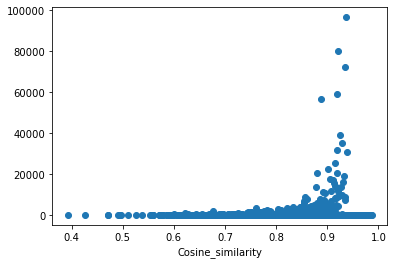

In [142]:
ax = cosine_similarity_df_sorted.set_index('Cosine_similarity')['Total_Frequency'].plot(style='o')

Which words are the outliers? Function words and *Darwin*:

In [143]:
cosine_similarity_df_sorted.loc[cosine_similarity_df_sorted['Total_Frequency'] > 10000].Word.tolist()

['with',
 '\xa0',
 'of',
 'this',
 'he',
 'it',
 'my',
 'which',
 'as',
 'on',
 'that',
 'will',
 'but',
 'for',
 'in',
 'to',
 'do',
 'the',
 'have',
 'very',
 'you',
 'your',
 'not',
 'be',
 'I',
 'a']

I exclude the outliers:

In [144]:
cosine_similarity_df_sorted_nooutliers = cosine_similarity_df_sorted.loc[cosine_similarity_df_sorted['Total_Frequency'] < 10000]
cosine_similarity_df_sorted_nooutliers.shape

(11653, 6)

Plot:

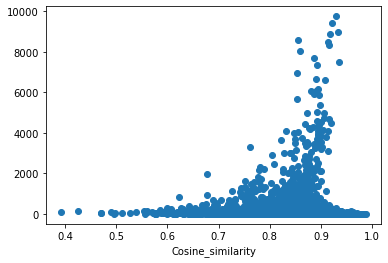

In [145]:
ax = cosine_similarity_df_sorted_nooutliers.set_index('Cosine_similarity')['Total_Frequency'].plot(style='o')

What is the semantic change of the words we have chosen?

In [146]:
words_chosen = ['protoplasm', 'curious', 'fertilisation', 'fertilise', 'analogy', 'analogous', 'homology', 'homologous', 'cleistogamic', 'physiology', 'physiological', 'ferment', 'science', 'scientist', 'scientific', 'evolution', 'evolutionary', 'evolve']

In [147]:
cosine_similarity_df_sorted[cosine_similarity_df_sorted['Word'] == "curious"]


,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
174,curious,0.893503,490,872,1362,


In [148]:
cosine_similarity_chosen = cosine_similarity_df_sorted[cosine_similarity_df_sorted['Word'].isin(words_chosen)]
cosine_similarity_chosen.to_csv(os.path.join(output_folder, 'cosine_similarity_chosen_words.csv'), encoding='utf-8')
cosine_similarity_chosen

,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
777,fertilise,0.668153,89,152,241,Foreign word
3584,ferment,0.720437,11,17,28,
2137,physiological,0.742884,24,38,62,
788,fertilisation,0.747925,88,150,238,Foreign word
4767,homologous,0.811019,7,10,17,
504,science,0.824877,145,257,402,
489,scientific,0.826747,149,265,414,
914,analogous,0.844531,73,124,197,
2450,homology,0.888707,20,30,50,
174,curious,0.893503,490,872,1362,


In [149]:
min(cosine_similarity_chosen.Cosine_similarity)

0.6681525111198425

In [150]:
min(cosine_similarity_chosen.Total_Frequency)

5

In [151]:
min(cosine_similarity_df_sorted.Cosine_similarity)

0.3924412131309509

Now I focus on those words that have a frequency higher than min(semantic_change_chosen.Total_Frequency). How many are there?

In [152]:
cosine_similarity_df_sorted_filtered = cosine_similarity_df_sorted_nooutliers.loc[(cosine_similarity_df_sorted_nooutliers['Total_Frequency'] >= min(cosine_similarity_chosen.Total_Frequency))]
cosine_similarity_df_sorted_filtered.shape

(10690, 6)

Which words are these words?

In [153]:
cosine_similarity_df_sorted_filtered

,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
1596,Lythrum,0.392441,36,60,96,Proper noun
1280,Primula,0.425859,48,83,131,Proper noun
1885,Dallas,0.470409,29,47,76,Proper noun
1892,,0.470716,28,47,75,Foreign word
1431,Ammonia,0.490563,42,72,114,Proper noun
...,...,...,...,...,...,...
9987,Wilton,0.983359,2,3,5,Proper noun
10356,translucent,0.983776,2,3,5,
9584,qui,0.984091,2,3,5,Foreign word
10441,l’Acad,0.984561,2,3,5,Foreign word


Neighbours of *fertilisation* in the two time periods:

In [154]:
print(model1.wv.similar_by_word("fertilisation", 10))
print(model2.wv.similar_by_word("fertilisation", 10))
cosine_similarity_df_sorted_filtered[cosine_similarity_df_sorted_filtered['Word'] == "fertilisation"]

[('attachment', 0.9502705931663513), ('agency', 0.9484695196151733), ('inference', 0.9441410303115845), ('cultivation', 0.9380370378494263), ('constitution', 0.9357308745384216), ('periodical', 0.9343718886375427), ('transportal', 0.9337235689163208), ('proposition', 0.9335793852806091), ('Public', 0.9335466623306274), ('presence', 0.9334656596183777)]
[('contrivance', 0.8465825319290161), ('agency', 0.7990261912345886), ('crossing', 0.7987335920333862), ('self', 0.778497576713562), ('imperfect', 0.7758520841598511), ('indispensable', 0.768123209476471), ('fertilise', 0.7645971775054932), ('artificial', 0.7609658241271973), ('digestion', 0.7587329745292664), ('exclude', 0.7586072683334351)]


,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
788,fertilisation,0.747925,88,150,238,Foreign word


_Fertilization_ was initially heavily associated with flowers and beans in Darwin’s correspondence since its first mention in 1854. The context of usage seems to change in the letters over time. This is exemplified by varying neighbours such as Bees, orchids, and contrivance. After 1870, we noticed that the neighbours reflect his interest in plant behaviour, perhaps relating to his work leading up to the publication of "Cross and Self Fertilisation" in 1876 and "The Power of Movement in Plants" in 1880. 

I create a list for these words:

In [155]:
highfreq_words = cosine_similarity_df_sorted_filtered.Word.tolist()
highfreq_words[:10]

['Lythrum',
 'Primula',
 'Dallas',
 '       ',
 'Ammonia',
 'maker',
 'Domestication',
 'Maer',
 'orchis',
 'Oxalis']

Now I annotate the plot with these:

/Users/barbaramcgillivray/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9002 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/barbaramcgillivray/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9001 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/barbaramcgillivray/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 12297 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/barbaramcgillivray/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 12296 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/barbaramcgillivray/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9002 missing from current font.
  font.set_text(s, 0, flags=flags)
/User

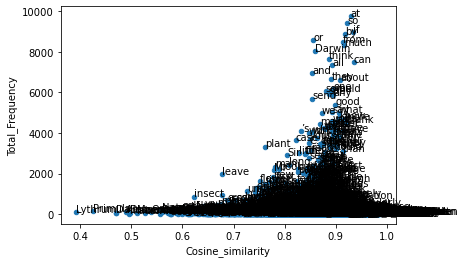

In [156]:
cosine_similarity_df_sorted_filtered_p = cosine_similarity_df_sorted_filtered[['Word','Cosine_similarity', 'Total_Frequency']]
fig, ax = plt.subplots()
cosine_similarity_df_sorted_filtered_p.plot('Cosine_similarity', 'Total_Frequency', kind='scatter', ax=ax)
for k, v in cosine_similarity_df_sorted_filtered_p.iterrows():
  word = v['Word']
  sc = v['Cosine_similarity']
  f = v['Total_Frequency']
  #print("w", v['Word'])
  #print("sc:", str(sc))
  #print("f:", str(f))
  ax.annotate(word, xy=(sc,f))

What are the neighbours of these words in the two spaces?

In [157]:
count = 0
for word in highfreq_words:
  count += 1
  if count < 10:
    print(word)
    print("Neighbours in first space:")
    print(model1.wv.similar_by_word(word, 10))
    print("Neighbours in second space:")
    print(model2.wv.similar_by_word(word, 10))

Lythrum
Neighbours in first space:
[('Lepidopt', 0.9866001009941101), ('Peter', 0.9845079779624939), ('Cooke', 0.9839299917221069), ('saliferous', 0.9836409687995911), ('Cur', 0.9832788705825806), ('pratense', 0.9832539558410645), ('122', 0.9831809401512146), ('precinct', 0.9831198453903198), ('palustris', 0.9829207062721252), ('Henfrey', 0.9825724959373474)]
Neighbours in second space:
[('Primula', 0.8750253915786743), ('Linum', 0.8583705425262451), ('Viola', 0.8290924429893494), ('climbing', 0.8290503621101379), ('Corydalis', 0.824256420135498), ('Oxalis', 0.806993842124939), ('Salvia', 0.7997157573699951), ('Hybrid', 0.7922738790512085), ('imperfect', 0.7890475988388062), ('skeleton', 0.7834983468055725)]
Primula
Neighbours in first space:
[('veris', 0.9941065311431885), ('postman', 0.992296040058136), ('clerical', 0.9915345907211304), ('Fragaria', 0.9914047122001648), ('Galium', 0.9913054704666138), ('Passe', 0.991042971611023), ('122', 0.9907096028327942), ('commun', 0.99042779207

I print this to an output file:

In [158]:
outfile = open(os.path.join(output_folder, 'Neighbours_freq_words.csv'), 'w+')

# Write header row:
outfile.write("Word, followed by  neighbours in first space and neighbours in second space\n") 
for word in highfreq_words:
  #print(word)
  #print("Neighbours in first space:")
  #print(model1.wv.similar_by_word(word, 10))
  #print("Neighbours in second space:")
  #print(model2.wv.similar_by_word(word, 10))
  for (w,c) in model1.wv.similar_by_word(word, 10):
    outfile.write(word+"\t" + w+"\t"+str(c))
  outfile.write("\n")
  for (w,c) in model2.wv.similar_by_word(word, 10):
    outfile.write(word+"\t"+w+"\t"+str(c))
  outfile.write("\n")
  
outfile.close()

## Semantic change detection using neighbours

We're going to implement the method proposed by Gonen, H., Jawahar, G., Seddah, D., & Goldberg, Y. (2020). Simple, Interpretable and Stable Method for Detecting Words with Usage Change across Corpora. In Proceedings of the 58th Annual Meeting of the Association for Computational Linguistics (pp. 538–555). https://doi.org/10.18653/v1/2020.acl-main.51 

Print the histogram of the frequency of the words in the corpus:

               Freq
count  32801.000000
mean   58.297125   
std    1095.194125 
min    1.000000    
25%    1.000000    
50%    2.000000    
75%    7.000000    
max    96541.000000


array([[<AxesSubplot:title={'center':'Freq'}>]], dtype=object)

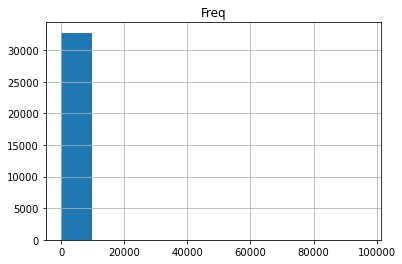

In [159]:
model = sg_w5_f0_1000
vocab = model.wv.index_to_key
frequencies = list()
for w in vocab:
  frequencies.append(model.wv.get_vecattr(w, "count"))
print(pd.DataFrame({'Word':vocab,'Freq':frequencies}).describe())
pd.DataFrame({'Word':vocab,'Freq':frequencies}).hist()

I exclude all words with frequency lower than min_freq and higher than max_freq:

In [160]:
def filter_words(model, min_freq, max_freq):
  vocab = model.wv.index_to_key
  vocab_filtered = []
  for w in vocab:
    if model.wv.get_vecattr(w, "count") <max_freq and model.wv.get_vecattr(w, "count")>min_freq:
      vocab_filtered.append(w)
  return vocab_filtered

vocab1_filtered = filter_words(model1,2,50000)
vocab2_filtered = filter_words(model2,2,50000)
vocab_filtered = list(set(vocab1_filtered) & set(vocab2_filtered))

How many words?

In [161]:
print(str(len(vocab_filtered)))

8336


Distribution of filtered word frequencies:

               Freq
count  11806.000000
mean   159.407251  
std    1821.175033 
min    4.000000    
25%    6.000000    
50%    12.000000   
75%    37.000000   
max    96541.000000


array([[<AxesSubplot:title={'center':'Freq'}>]], dtype=object)

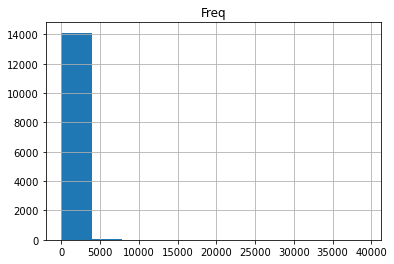

In [162]:
word2freq = pd.DataFrame({'Word':vocab,'Freq':frequencies})
print(word2freq[(word2freq.Freq<100000) & (word2freq.Freq>3)].describe())
word2freq[(word2freq.Freq<50000) & (word2freq.Freq>2)].hist()

I extract the top_n neighbours and save them in a dictionary mapping a word to the list of its 100 neighbours:

In [163]:
def extract_neighbours(w2vmodel, vocab_list, top_n):
  count = 0
  word2neighbours = dict()
  for w in vocab_list:
    count += 1
    #if (count % 100) == 0:
    #  print(str(count), "out of", str(len(vocab_list)), w)
    neighbours = w2vmodel.wv.similar_by_word(w, top_n)
    #print(str(neighbours))
    neighbour_list = list()
    for n in neighbours:
      neighbour_list.append(n[0])
    word2neighbours[w] = neighbour_list
  return word2neighbours

I apply this to model1 and model2 for filtered words:

In [164]:
#word2neighbours1 = extract_neighbours(model1, model1.wv.index_to_key)
word2neighbours1 = extract_neighbours(model1, vocab1_filtered, 100)
#word2neighbours2 = extract_neighbours(model2, model2.wv.index_to_key)
word2neighbours2 = extract_neighbours(model2, vocab2_filtered, 100)

For every word in the intersection between the two vocabularies, compare its neighbours in t1 and its neighbours in t2; the semantic change score is the number of shared neighbours between the two divided by 100.
NB This is different from the formula in Gonen et al. (2020), who take the negative of the overlap.

In [165]:
#vocab_12 = list(set(model1.wv.index_to_key) & set(model2.wv.index_to_key))
w2sc = dict()
for w in vocab_filtered:
  sc = len(list(set(word2neighbours1[w]) & set(word2neighbours2[w])))/100
  w2sc[w] = sc

I have saved these scores in the w2sc dictionary. Now I sort it by decreasing score to see which words changed the most:

In [166]:
w2sc_sorted = sorted(w2sc.items(), key=lambda kv: kv[1], reverse=False)
w2sc_sorted[:10]

[('Missionary', 0.0),
 ('owl', 0.0),
 ('Postscript', 0.0),
 ('rapid', 0.0),
 ('Raspberry', 0.0),
 ('Trent', 0.0),
 ('brilliancy', 0.0),
 ('Col', 0.0),
 ('Balani', 0.0),
 ('Forest', 0.0)]

What are the most changed words?

In [167]:
top_changed = [i[0] for i in w2sc_sorted][:20]
top_changed

['Missionary',
 'owl',
 'Postscript',
 'rapid',
 'Raspberry',
 'Trent',
 'brilliancy',
 'Col',
 'Balani',
 'Forest',
 's',
 'constitutional',
 'golden',
 'Nos',
 'Mammoth',
 'perpetuity',
 'remit',
 'Entomology',
 'gneiss',
 'Caucasus']

What are their neighbours?

In [168]:
for w in top_changed:
  print(w)
  print(str(word2neighbours1[w]))
  print(str(word2neighbours2[w]))

Missionary
['disgracefully', 'proclaim', '1820', 'Hog', 'Cleavage', 'Wright', 'Protection', 'ripen', 'perceptibly', 'kentish', 'immemorial', 'roar', 'revere', 'mouldy', 'Favourite', 'Boulder', 'infusorial', 'siberian', 'canister', 'Runner', 'Capel', 'challenge', 'Invertebrate', 'fibre', 'embankment', 'Toads', 'disinterested', 'fossile', 'repen', 'thunder', 'Burial', 'Sahara', 'supper', 'Statement', 'forthcoming', 'pitcher', 'troubled', 'adhesion', 'spore', 'Grass', 'workmanship', 'Muckul', '423', 'bedevil', 'meditation', 'Anyhow', 'thirty', 'primrose', 'Shows', 'eighteen', 'flowering', 'hack', '59', 'tameness', 'villain', 'mutiny', 'heir', 'cirrhosa', 'hazy', 'granular', 'Ammonites', 'hawk', 'Niagara', 'moschatus', 'Mylodon', 'Delphinus', 'requirement', '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0', 'bot', 'partition', 'intermission', 'consumption', 'himalayan', 'olive', 'High', 'Seychelles', 'Cader', 'median', 'nettle', 'changeable', 'unrivalled', 'sunny', 'methodically', 'stake', 'Notes', 'Euca

In [169]:
neighbours_df = pd.DataFrame(([w, w2sc[w], model1.wv.get_vecattr(w, "count") , model2.wv.get_vecattr(w, "count") ] for w in vocab_filtered), columns = ('Word', 'Neighbour_score', "Frequency_t1", "Frequency_t2"))
neighbours_df.describe()

,Neighbour_score,Frequency_t1,Frequency_t2
count,8336.000000,8336.000000,8336.000000
mean,0.065427,74.351128,129.129319
std,0.082332,613.195720,1063.409754
min,0.000000,3.000000,4.000000
25%,0.010000,4.000000,7.000000
50%,0.030000,8.000000,13.000000
75%,0.090000,25.000000,40.000000
max,0.610000,26921.000000,45232.000000


Visualise the distribution of the semantic change scores with a histogram:

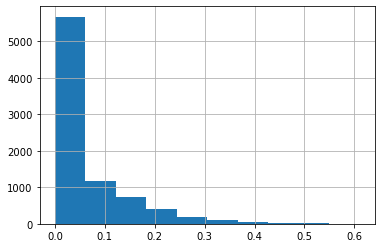

In [170]:
hist = neighbours_df['Neighbour_score'].hist()

Now I sort by increasing neighbour score:

In [171]:
neighbours_df_sorted = neighbours_df.sort_values(by='Neighbour_score', ascending=True)
neighbours_df_sorted.head(50)

,Word,Neighbour_score,Frequency_t1,Frequency_t2
5385,ray,0.0,8,13
2678,City,0.0,4,6
6256,astound,0.0,6,10
7560,Buffon,0.0,6,10
1070,Photographs,0.0,7,11
7564,revolving,0.0,3,4
6248,1861,0.0,4,6
6247,Lawson,0.0,5,8
2691,Breeds,0.0,8,13
1064,ear,0.0,40,67


I add the total frequency:

In [172]:
neighbours_df_sorted["Total_Frequency"] = neighbours_df_sorted["Frequency_t1"]+neighbours_df_sorted["Frequency_t2"]
neighbours_df_sorted

,Word,Neighbour_score,Frequency_t1,Frequency_t2,Total_Frequency
5385,ray,0.00,8,13,21
2678,City,0.00,4,6,10
6256,astound,0.00,6,10,16
7560,Buffon,0.00,6,10,16
1070,Photographs,0.00,7,11,18
...,...,...,...,...,...
2759,30,0.52,61,102,163
7695,20,0.53,64,108,172
3966,1,0.54,181,313,494
6525,40,0.55,31,50,81


I add a column with the category (function word, foreign word, numeral, and proper noun).

In [173]:
# create a list of our conditions
conditions = [
    (neighbours_df_sorted['Word'].isin(function_words)), # function words
    ((neighbours_df_sorted.Word.str.isdigit()) | (neighbours_df_sorted['Word'].str.match('^\d*?1st$')) | (neighbours_df_sorted['Word'].str.match('^\d*?2nd$')) | (neighbours_df_sorted['Word'].str.match('^\d*?3rd$')) | (neighbours_df_sorted['Word'].str.match('^\d*[^123]th$'))), # numbers
    (neighbours_df_sorted['Word'].apply(lambda x: x[0].isupper() and x[1:len(x)].islower())), # proper nouns
    (np.invert(neighbours_df_sorted['Word'].str.lower().isin(english_vocab))) # foreign words
    ]

# create a list of the values we want to assign for each condition
values = ['Function word','Numeral', 'Proper noun', 'Foreign word']

# create a new column and use np.select to assign values to it using our lists as arguments
neighbours_df_sorted['Category_automatic'] = np.select(conditions, values, default = "")
neighbours_df_sorted

,Word,Neighbour_score,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
5385,ray,0.00,8,13,21,
2678,City,0.00,4,6,10,Proper noun
6256,astound,0.00,6,10,16,
7560,Buffon,0.00,6,10,16,Proper noun
1070,Photographs,0.00,7,11,18,Proper noun
...,...,...,...,...,...,...
2759,30,0.52,61,102,163,Numeral
7695,20,0.53,64,108,172,Numeral
3966,1,0.54,181,313,494,Numeral
6525,40,0.55,31,50,81,Numeral


I save this to a file:

In [174]:
if not os.path.exists(output_folder):
  os.makedirs(output_folder)
neighbours_df_sorted.to_csv(os.path.join(output_folder, 'all_words_neighbourscore.csv'), encoding='utf-8')

## Comparison of the two methods for semantic change detection

In [175]:
neighbours_df_sorted.sort_values(by='Word', ascending=True)

,Word,Neighbour_score,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
2909,,0.09,63,107,170,Foreign word
6759,,0.00,8,13,21,Foreign word
6953,,0.02,4,6,10,Foreign word
2516,,0.00,5,8,13,Foreign word
4247,,0.00,28,47,75,Foreign word
...,...,...,...,...,...,...
2949,〈to〉,0.00,3,4,7,Foreign word
7728,〉,0.02,32,53,85,Foreign word
198,☞,0.01,4,6,10,Foreign word
188,〈,0.03,9,14,23,Foreign word


In [176]:
cosine_similarity_df_sorted.sort_values(by='Word', ascending=True)

,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
1031,,0.652774,63,107,170,Foreign word
4135,,0.823183,8,13,21,Foreign word
6490,,0.896450,4,6,10,Foreign word
8340,,0.915544,2,4,6,Foreign word
11671,,0.878033,1,2,3,Foreign word
...,...,...,...,...,...,...
1736,〉,0.674747,32,53,85,Foreign word
9680,〉.,0.878987,2,3,5,Foreign word
6572,☞,0.897494,4,6,10,Foreign word
4039,〈,0.883175,9,14,23,Foreign word


In [177]:
semantic_change_2methods = cosine_similarity_df_sorted.merge(neighbours_df_sorted, how = 'inner')
semantic_change_2methods

,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic,Neighbour_score
0,Lythrum,0.392441,36,60,96,Proper noun,0.04
1,Primula,0.425859,48,83,131,Proper noun,0.02
2,Dallas,0.470409,29,47,76,Proper noun,0.04
3,,0.470716,28,47,75,Foreign word,0.00
4,Ammonia,0.490563,42,72,114,Proper noun,0.01
...,...,...,...,...,...,...,...
8331,153,0.981137,3,4,7,Numeral,0.16
8332,1847,0.981155,3,5,8,Numeral,0.12
8333,laurel,0.981500,3,5,8,,0.02
8334,confuse,0.982586,3,5,8,,0.01


I integrate the neighbour score in the file:

In [178]:
semantic_change_2methods_all = cosine_similarity_df_sorted.merge(neighbours_df_sorted, how = 'outer')
semantic_change_2methods_all.to_csv(os.path.join(output_folder, 'all_words_2scores.csv'), encoding='utf-8')
semantic_change_2methods_all

,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic,Neighbour_score
0,Lythrum,0.392441,36,60,96,Proper noun,0.04
1,Primula,0.425859,48,83,131,Proper noun,0.02
2,Dallas,0.470409,29,47,76,Proper noun,0.04
3,,0.470716,28,47,75,Foreign word,0.00
4,Ammonia,0.490563,42,72,114,Proper noun,0.01
...,...,...,...,...,...,...,...
11674,translucent,0.983776,2,3,5,,NaN
11675,fineness,0.983913,2,2,4,,NaN
11676,qui,0.984091,2,3,5,Foreign word,NaN
11677,l’Acad,0.984561,2,3,5,Foreign word,NaN


In [179]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'] =="scientist"]

,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic,Neighbour_score


I plot the terms by two semantic change scores:

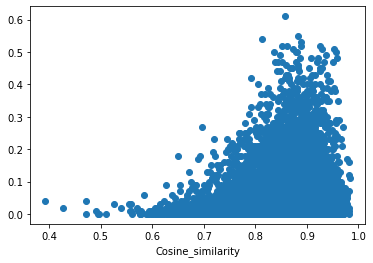

In [180]:
ax = semantic_change_2methods.set_index('Cosine_similarity')['Neighbour_score'].plot(style='o')

In [181]:
semantic_change_2methods_all.corr(method="spearman")

,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Neighbour_score
Cosine_similarity,1.000000,-0.700727,-0.701526,-0.701667,-0.046460
Frequency_t1,-0.700727,1.000000,0.990690,0.994457,0.648922
Frequency_t2,-0.701526,0.990690,1.000000,0.999383,0.647992
Total_Frequency,-0.701667,0.994457,0.999383,1.000000,0.647775
Neighbour_score,-0.046460,0.648922,0.647992,0.647775,1.000000


There seems to be a positive correlation: the higher the cosine similarity the higher the neighbour similarity.



In [182]:
semantic_change_2methods_all.describe()

,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Neighbour_score
count,11679.000000,11679.000000,11679.000000,11679.000000,8336.000000
mean,0.891669,59.178611,102.531124,161.709735,0.065427
std,0.067333,673.064418,1159.415905,1832.080391,0.082332
min,0.392441,1.000000,2.000000,3.000000,0.000000
25%,0.859137,2.000000,4.000000,6.000000,0.010000
50%,0.909613,5.000000,7.000000,12.000000,0.030000
75%,0.941511,15.000000,23.000000,38.000000,0.090000
max,0.987432,35816.000000,60725.000000,96541.000000,0.610000


Scores for chosen words:

In [183]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].describe()

,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Neighbour_score
count,12.000000,12.000000,12.000000,12.000000,11.000000
mean,0.818376,93.833333,163.666667,257.500000,0.127273
std,0.084286,135.041296,241.407740,376.445215,0.099004
min,0.668153,2.000000,3.000000,5.000000,0.000000
25%,0.746665,17.750000,26.750000,44.500000,0.045000
50%,0.825812,50.500000,85.000000,135.500000,0.110000
75%,0.889906,103.000000,178.250000,281.250000,0.185000
max,0.945538,490.000000,872.000000,1362.000000,0.310000


Scores for not chosen words:

In [184]:
semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(words_chosen)].describe()

,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Neighbour_score
count,11667.000000,11667.000000,11667.000000,11667.000000,8325.000000
mean,0.891745,59.142967,102.468244,161.611211,0.065345
std,0.067277,673.396810,1159.986712,1832.983389,0.082285
min,0.392441,1.000000,2.000000,3.000000,0.000000
25%,0.859257,2.000000,4.000000,6.000000,0.010000
50%,0.909682,5.000000,7.000000,12.000000,0.030000
75%,0.941515,15.000000,22.000000,37.000000,0.090000
max,0.987432,35816.000000,60725.000000,96541.000000,0.610000


Compare the two means:

In [185]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[0,4]]

Cosine_similarity    0.818376
Neighbour_score      0.127273
dtype: float64

I define a list of words that I expect did not change:

In [186]:
not_changed = ['the', 'it', 'for', 'a', 'at', 'in', 'be', 'of', 'on', 'over', 'under']

Then I look at their scores:

In [187]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(not_changed)]

,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic,Neighbour_score
341,under,0.726048,404,713,1117,Function word,0.05
3988,over,0.880003,522,987,1509,Function word,0.16
4358,of,0.887011,20519,36041,56560,Function word,0.11
5215,it,0.901047,7604,14638,22242,Function word,0.21
6090,on,0.912979,5517,10267,15784,Function word,0.11
6539,for,0.918536,7265,13212,20477,Function word,0.19
6545,in,0.918585,11810,19751,31561,Function word,0.06
6804,the,0.921466,29467,50683,80150,Function word,NaN
7524,at,0.929343,3613,6133,9746,Function word,0.11
8098,be,0.935222,26921,45232,72153,,0.16


In [188]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(not_changed)].describe()

,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Neighbour_score
count,11.000000,11.000000,11.000000,11.000000,10.000000
mean,0.897076,11375.090909,19742.363636,31117.454545,0.130000
std,0.059639,10082.857834,17118.184596,27195.912492,0.052068
min,0.726048,404.000000,713.000000,1117.000000,0.050000
25%,0.894029,4565.000000,8200.000000,12765.000000,0.110000
50%,0.918536,7604.000000,14638.000000,22242.000000,0.125000
75%,0.925405,16164.500000,27896.000000,44060.500000,0.160000
max,0.937596,29467.000000,50683.000000,80150.000000,0.210000


In [189]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].describe()

,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Neighbour_score
count,12.000000,12.000000,12.000000,12.000000,11.000000
mean,0.818376,93.833333,163.666667,257.500000,0.127273
std,0.084286,135.041296,241.407740,376.445215,0.099004
min,0.668153,2.000000,3.000000,5.000000,0.000000
25%,0.746665,17.750000,26.750000,44.500000,0.045000
50%,0.825812,50.500000,85.000000,135.500000,0.110000
75%,0.889906,103.000000,178.250000,281.250000,0.185000
max,0.945538,490.000000,872.000000,1362.000000,0.310000


Let's look at species:

In [190]:
semantic_change_2methods_all[semantic_change_2methods_all['Word']=='species']

,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic,Neighbour_score
4516,species,0.889884,32,52,84,,0.1


In [191]:
semantic_change_2methods_all[semantic_change_2methods_all['Word']=='descent']

,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic,Neighbour_score
2281,descent,0.843269,33,54,87,,0.17


I compare the means:

In [192]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(not_changed)].mean()[[0,4]]

Cosine_similarity    0.897076
Neighbour_score      0.130000
dtype: float64

### Systematic comparison of cosine similarity and neighbour similarity by different values of parameters

This is the list of non-scientific words currently analysed in the article:

In [193]:
nonsci_analysed = ['lunch', 'presentation', 'herewith', 'heartfelt', 'presentation', 'inconvenient']

This is the list of scientific words currently analysed in the article:

In [194]:
sci_analysed = ['molecule', 'fundamental', 'spiritual', 'latent', 'wriggle', 'sediment']

I define a function that, given a minimum frequency, a maximum frequency and the number of top neighbours, does the following: filter the vocabularies, apply this to model1 and model2 for filtered words, calculates the neghbour similarity score, define a dataframe with this score, save to a file, combine the dataframe with the cosine similarity score, I plot the terms by two semantic change scores, calculate Spearman correlation between the two scores, compares the means of the two scores for the chosen words (gold standard), the words that did not change, the words that were not in the gold standard, the non-scientific words currently analysed in the article and the scientific words currently analysed in the article.

In [195]:
def compare_two_methods(min_freq, max_freq, top_n):
  vocab1_filtered = filter_words(model1,min_freq, max_freq)
  vocab2_filtered = filter_words(model2,min_freq, max_freq)
  #print("Vocabulary 1 filtered: "+str(len(vocab1_filtered)))
  #print("Vocabulary 2 filtered: "+str(len(vocab2_filtered)))
  vocab_filtered = list(set(vocab1_filtered) & set(vocab2_filtered))
  #print("1")
  word2neighbours1 = extract_neighbours(model1, vocab1_filtered, top_n)
  #print("2")
  word2neighbours2 = extract_neighbours(model2, vocab2_filtered, top_n)
  #print("3")
  w2sc = dict()
  for w in vocab_filtered:
    sc = len(list(set(word2neighbours1[w]) & set(word2neighbours2[w])))/100
    w2sc[w] = sc
  #print("4")
  w2sc_sorted = sorted(w2sc.items(), key=lambda kv: kv[1], reverse=False)
  neighbours_df = pd.DataFrame(([w, w2sc[w], model1.wv.get_vecattr(w, "count") , model2.wv.get_vecattr(w, "count") ] for w in vocab_filtered), columns = ('Word', 'Neighbour_score', "Frequency_t1", "Frequency_t2"))
  #print("5")
  #print("6")
  neighbours_df_sorted = neighbours_df.sort_values(by='Neighbour_score', ascending=True)
  #print("7")
  neighbours_df_sorted["Total_Frequency"] = neighbours_df_sorted["Frequency_t1"]+neighbours_df_sorted["Frequency_t2"]
  #print("8")
  conditions = [
    (neighbours_df_sorted['Word'].isin(function_words)), # function words
    ((neighbours_df_sorted.Word.str.isdigit()) | (neighbours_df_sorted['Word'].str.match('^\d*?1st$')) | (neighbours_df_sorted['Word'].str.match('^\d*?2nd$')) | (neighbours_df_sorted['Word'].str.match('^\d*?3rd$')) | (neighbours_df_sorted['Word'].str.match('^\d*[^123]th$'))), # numbers
    (neighbours_df_sorted['Word'].apply(lambda x: x[0].isupper() and x[1:len(x)].islower())), # proper nouns
    (np.invert(neighbours_df_sorted['Word'].str.lower().isin(english_vocab))) # foreign words
    ]
  # create a list of the values we want to assign for each condition
  values = ['Function word','Numeral', 'Proper noun', 'Foreign word']
  neighbours_df_sorted['Category_automatic'] = np.select(conditions, values, default = "")
  #print("9")
  neighbours_df_sorted.to_csv(os.path.join(output_folder, 'all_words_neighbourscore'+str(min_freq)+'-'+str(max_freq)+'-'+str(top_n)+'.csv'), encoding='utf-8')
  #print("10")
  semantic_change_2methods = cosine_similarity_df_sorted.merge(neighbours_df_sorted, how = 'inner')
  #print("11")
  semantic_change_2methods_all = cosine_similarity_df_sorted.merge(neighbours_df_sorted, how = 'outer')
  #print("12")
  semantic_change_2methods_all.to_csv(os.path.join(output_folder, 'all_words_2scores'+str(min_freq)+'-'+str(max_freq)+'-'+str(top_n)+'.csv'), encoding='utf-8')
  #print("13")
  ax = semantic_change_2methods.set_index('Cosine_similarity')['Neighbour_score'].plot(style='o')
  #print("14")
  corr = (semantic_change_2methods_all.corr(method="spearman")).Neighbour_score[0]
  #print("Correlation:",corr)
  #print("Means of chosen words:")
  mean_cos_chosen = semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[0]][0]
  mean_nei_chosen = semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[4]][0]
  median_cos_chosen = semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].median()[[0]][0]
  median_nei_chosen = semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].median()[[4]][0]
  #print(semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[0,4]])
  #print("Means of all other words:")
  mean_cos_other = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[0]][0]
  mean_nei_other = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[4]][0]
  median_cos_other = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(words_chosen)].median()[[0]][0]
  median_nei_other = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(words_chosen)].median()[[4]][0]
  #print(semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[0,4]])
  #print("Means of not changed words:")
  mean_cos_unchanged = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(not_changed)].mean()[[0]][0]
  mean_nei_unchanged = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(not_changed)].mean()[[4]][0]
  median_cos_unchanged = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(not_changed)].median()[[0]][0]
  median_nei_unchanged = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(not_changed)].median()[[4]][0]
  #print(semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(not_changed)].mean()[[0,4]])
  #print("Means of non-scientific words currently analysed in the article:")
  mean_cos_nonscian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(nonsci_analysed)].mean()[[0]][0]
  mean_nei_nonscian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(nonsci_analysed)].mean()[[4]][0]
  median_cos_nonscian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(nonsci_analysed)].median()[[0]][0]
  median_nei_nonscian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(nonsci_analysed)].median()[[4]][0]
  #print(semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(nonsci_analysed)].mean()[[0,4]])
  #print("Means of scientific words currently analysed in the article:")
  mean_cos_scian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(sci_analysed)].mean()[[0]][0]
  mean_nei_scian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(sci_analysed)].mean()[[4]][0]
  median_cos_scian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(sci_analysed)].median()[[0]][0]
  median_nei_scian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(sci_analysed)].median()[[4]][0]
  #print(semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(sci_analysed)].mean()[[0,4]])
  return [vocab1_filtered, vocab2_filtered, vocab_filtered, corr, 
          mean_cos_chosen, mean_nei_chosen, mean_cos_other, mean_nei_other, mean_cos_unchanged, mean_nei_unchanged, mean_cos_nonscian, mean_nei_nonscian, mean_cos_scian, mean_nei_scian, 
          median_cos_chosen, median_nei_chosen, median_cos_other, median_nei_other, median_cos_unchanged, median_nei_unchanged, median_cos_nonscian, median_nei_nonscian, median_cos_scian,median_nei_scian]

I try different parameters:

In [ ]:
summary = open(os.path.join(output_folder, 'summary_results.csv'), 'w+')
writer = csv.writer(summary, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
writer.writerow(['min_freq','max_freq', 'top_n', 'vocab1_filtered', 'vocab2_filtered', 
                 'Spearman correlation cosine_sim-neighbour_sim', 
                 'mean_neighbourscore_chosen_words','mean_cosinescore_chosen_words',
                 'mean_neighbourscore_other_words','mean_cosinescore_other_words',
                 'mean_neighbourscore_unchanged_words','mean_cosinescore_unchanged_words',
                 'mean_neighbourscore_non_sci_words_analysed','mean_cosinescore_non_sci_words_analysed',
                 'mean_neighbourscore_sci_words_analysed','mean_cosinescore_sci_words_analysed',
                 'median_neighbourscore_chosen_words','median_cosinescore_chosen_words',
                 'median_neighbourscore_other_words','median_cosinescore_other_words',
                 'median_neighbourscore_unchanged_words','median_cosinescore_unchanged_words',
                 'median_neighbourscore_non_sci_words_analysed','median_cosinescore_non_sci_words_analysed',
                 'median_neighbourscore_sci_words_analysed','median_cosinescore_sci_words_analysed'])
min_freq_values = [0,1,5,10,50]
max_freq_values = [10000,100000,200000]
top_n_values = [10,50,100,1000]
for min_freq in min_freq_values:
  for max_freq in max_freq_values:
    for top_n in top_n_values:
      print(min_freq, max_freq, top_n)
      [vocab1_filtered, vocab2_filtered, vocab_filtered, corr, 
       mean_cos_chosen, mean_nei_chosen, mean_cos_other, mean_nei_other, mean_cos_unchanged, mean_nei_unchanged, mean_cos_nonscian, mean_nei_nonscian, mean_cos_scian, mean_nei_scian, 
       median_cos_chosen, median_nei_chosen, median_cos_other, median_nei_other, median_cos_unchanged, median_nei_unchanged, median_cos_nonscian, median_nei_nonscian, median_cos_scian, median_nei_scian] = compare_two_methods(min_freq, max_freq, top_n)
      writer.writerow([min_freq, max_freq, top_n, len(vocab1_filtered), len(vocab2_filtered), corr,
                 mean_cos_chosen,mean_nei_chosen,mean_cos_other,mean_nei_other,mean_cos_unchanged,mean_nei_unchanged, mean_cos_nonscian, mean_nei_nonscian,mean_cos_scian,mean_nei_scian,
                 median_cos_chosen,median_nei_chosen,median_cos_other,median_nei_other,median_cos_unchanged,median_nei_unchanged, median_cos_nonscian, median_nei_nonscian,median_cos_scian,median_nei_scian])
summary.close()

0 10000 10
